# VARNN Training Codebase To Share

**Last Updated 3/4/2022**
1. Added VSN updated
2. Added Equation-by-Equation
3. Added support for different hemispheres
4. Execution Code Updated for different num variables, different methods of specifying hyperparams

In [1]:
!pip install statsmodels==0.12.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.5 MB 4.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from tqdm.notebook import tqdm, trange
import copy
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import itertools
from statsmodels.tsa.ar_model import AutoReg
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os
from functools import reduce
from itertools import product

from sklearn.linear_model import LinearRegression
import random
from datetime import datetime

from statsmodels.tsa.api import VAR

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
root_dir = 'drive/MyDrive/EconML DL/Fall 2021'

## Parameters for Model

### Variable Selection Networks

In [5]:
# @title VSN Code

# num_features = variables here
# units = encoding dimension of each feature

class GatedLinearUnit(nn.Module):
  def __init__(self, input_size, units):
    super(GatedLinearUnit, self).__init__()
    self.linear1 = nn.Linear(input_size, units)
    self.linear2 = nn.Linear(input_size, units)
    self.sigmoid = nn.Sigmoid()

    self.input_size = input_size

  def forward(self, inputs):
    #print('glu input size', self.input_size)
    #print('glu input', inputs.shape)
    linear = self.linear1(inputs)
    sigmoid = self.sigmoid(self.linear2(inputs))
    # Element-wise product of linear layer and sigmoid layer
    out = linear * sigmoid
    #print('out', out.shape)
    return out

class GatedResidualNetwork(nn.Module):
  def __init__(self, input_size, units, dropout_rate):
    super(GatedResidualNetwork, self).__init__()
    self.elu_linear = nn.Linear(input_size, units)
    self.elu = nn.ELU()
    self.linear = nn.Linear(units, units)
    self.dropout = nn.Dropout(dropout_rate)
    self.gated_linear_unit = GatedLinearUnit(units, units)
    self.layer_norm = nn.LayerNorm(units)
    self.project = nn.Linear(input_size, units)
    
    self.input_size = input_size
    self.units = units
    
  def forward(self, inputs):
    #print('grn input size', self.input_size)
    #print('grn input', inputs.shape)
    x = self.elu_linear(inputs)
    x = self.elu(x)
    x = self.linear(x)
    x = self.dropout(x)
    # Add the original units to output of GLU to perform residual connection
    #print('x_size', x.shape)
    if inputs.shape[-1] != self.units:
      inputs = self.project(inputs)
    x = inputs + self.gated_linear_unit(x)
    x = self.layer_norm(x)
    return x

# NEW VSN
class VariableSelection(nn.Module):
  def __init__(self, num_features, units, dropout_rate):
    super(VariableSelection, self).__init__()

    # Create a GRN for the concatenation of all the features
    self.grn_concat = GatedResidualNetwork(num_features, units, dropout_rate)
    self.softmax_linear = nn.Linear(units, num_features)

  def forward(self, inputs):
    # Code for this may be questionable
    #v = torch.cat(inputs)

    # size: num_obs x (features x units)
    v = self.grn_concat(inputs)
    # size: num_obs x units
    v = self.softmax_linear(v)
    v = F.softmax(v, dim = -1)
    # size: num_obs x features
    return v

### VARNN Code

In [6]:
# @title CancelOut

class CancelOut(nn.Module):
    '''
    CancelOut Layer
    x - an input data (vector, matrix, tensor)
    '''
    def __init__(self,inp, *kargs, **kwargs):
        super(CancelOut, self).__init__()
        self.weights = nn.Parameter(torch.zeros(inp,requires_grad = True) + 4)
    def forward(self, x):
        return (x * torch.sigmoid(self.weights.float()))

In [7]:
# @title Fully Connected Network Architecture

class FCN(nn.Module):
  def __init__(self, n_features, n_outputs, dropout_rate, nodes, actv):
    super(FCN, self).__init__()

    # Assign the activation function
    exec('self.actv = %s'%actv)

    self.input = nn.Linear(n_features, nodes[0])
    self.hidden = nn.ModuleList([nn.Linear(nodes[node_id], nodes[node_id+1]) for node_id in range(len(nodes)-1)])
    self.output = nn.Linear(nodes[-1], n_outputs)
    self.dropout = nn.Dropout(p = dropout_rate)

  def forward(self, S):

    x = self.actv(self.input(S))
    x = self.dropout(x)

    for i in range(len(self.hidden)):
      x = self.actv(self.hidden[i](x))
      x = self.dropout(x)
    
    output = self.output(x)
    return output

**VARNN Notes**
- Input Dropout currently not working
- Prior shift currently not working (after hemispheres)

In [8]:
# @title VAR NN Architecture Definition

class VARNN(nn.Module):
    def __init__(self, n_features, n_outputs, nodes, x_pos, dropout_rate, input_dropout_rate, 
                 cancel_out, vsn, fcn, neurons_weights, time_hemi_prior_variance,
                 device, actv = 'ReLU()', s_pos = None):
        super(VARNN, self).__init__()

        n_betas = []
        x_indices = []
        self.n_vars = len(x_pos)

        # Assign the activation function
        exec('self.actv = %s'%actv)
        
        s_indices = []
        for i in range(len(s_pos)):
          s_indices.append(torch.tensor(s_pos[i], dtype = torch.int64).to(device))
        self.s_pos = s_indices

        for i in range(self.n_vars):
          x_indices.append(torch.tensor(x_pos[i], dtype = torch.int64).to(device))
          n_betas.append(len(x_pos[i]))

        self.n_betas = n_betas
        self.n_alphas = int(n_outputs * (n_outputs+1) / 2)

        # Hemispheres
        # Number of hemispheres is number of lists within the s_pos list
        self.num_hemispheres = len(self.s_pos)
        self.time_hemi_prior_variance = time_hemi_prior_variance

        self.hemispheres = nn.ModuleList()

        for hemi_id in range(self.num_hemispheres):

          hemi_num_inputs = len(self.s_pos[hemi_id])

          # Defining the TVPL and Output layers - BETAS
          tvpl_all = []
          output_all = []

          for i in range(n_outputs):
            tvpl_var = []
            output_var = []
            for tvpl_archi in neurons_weights:
              # Define the TVPL NN for one layer 
              tvpl_list = [nn.Linear(nodes[-1], tvpl_archi[0])]
              for layer_id in range(len(tvpl_archi) - 1):
                tvpl_list.append(nn.Linear(tvpl_archi[layer_id], tvpl_archi[layer_id+1]))
              tvpl_var.append(nn.ModuleList(tvpl_list))
              output_var.append(nn.Linear(tvpl_archi[-1], 1))
            tvpl_all.append(nn.ModuleList(tvpl_var))
            output_all.append(nn.ModuleList(output_var))      

          # Defining TVPL and Output layers - ALPHAS
          tvpl_alphas = []
          output_alphas = []
          for i in range(self.n_alphas):
            # Just use the 1st tvpl archi for now - could change later
            tvpl_archi = neurons_weights[0]
            tvpl_list = [nn.Linear(nodes[-1], tvpl_archi[0])]
            for layer_id in range(len(tvpl_archi) - 1):
              tvpl_list.append(nn.Linear(tvpl_archi[layer_id], tvpl_archi[layer_id+1]))
            tvpl_alphas.append(nn.ModuleList(tvpl_list))
            output_alphas.append(nn.Linear(tvpl_archi[-1], 1))

            
          self.hemispheres.append(
              nn.ModuleDict({
              'betas': nn.ModuleDict({
                'input': nn.Linear(hemi_num_inputs, nodes[0]).to(device),
                'first': nn.Linear(nodes[0], nodes[0]).to(device),
                'hidden': nn.ModuleList([nn.Linear(nodes[node_id], nodes[node_id+1]) for node_id in range(len(nodes)-1)]).to(device),
                'tvpl': nn.ModuleList(tvpl_all).to(device),
                'output': nn.ModuleList(output_all).to(device)
              }),
              'alphas': nn.ModuleDict({
                'input': nn.Linear(hemi_num_inputs, nodes[0]).to(device),
                'first': nn.Linear(nodes[0], nodes[0]).to(device),
                'hidden': nn.ModuleList([nn.Linear(nodes[node_id], nodes[node_id+1]) for node_id in range(len(nodes)-1)]).to(device),
                'tvpl': nn.ModuleList(tvpl_alphas).to(device),
                'output': nn.ModuleList(output_alphas).to(device)
              })
              }))

        self.dropout = nn.Dropout(p = dropout_rate)
        self.input_dropout = nn.Dropout(p = 0)
        self.input_dropout_enabled = input_dropout_rate == 0
        self.device = device

        # Instantiate the VSN or FCN networks if applicable
        if vsn == True:
          #print('n_features', n_features, 'n_outputs', n_outputs)
          self.vsn = VariableSelection(n_features, n_outputs, input_dropout_rate)
          pytorch_total_params = sum(p.numel() for p in self.vsn.parameters())
        else:
          self.vsn = None

        if fcn == True:
          self.fcn = FCN(n_features, n_outputs, dropout_rate, nodes, actv)
          pytorch_total_params = sum(p.numel() for p in self.fcn.parameters())
        else:
          self.fcn = None

        self.vsn_enabled = vsn
        self.fcn_enabled = fcn

        self.x_indices = x_indices
        self.n_layers = len(nodes)
        
        self.n_outputs = n_outputs
        self.neurons_weights = neurons_weights

    def forward(self, S):
      
      # Get the Xs for the linear part
      dat = torch.index_select(S, 1, self.x_indices[0])
      for i in range(1, self.n_vars):
        alt = torch.index_select(S, 1, self.x_indices[i])
        dat = torch.hstack([dat, alt])
      
      # Append constant column at the front
      dat = torch.hstack([torch.ones(S.size()[0], 1).to(self.device), dat])

      # Pure Fully-connected network if only that is enabled
      if self.fcn_enabled == True:
        y_hat = self.fcn(S)
        return y_hat, [], []

      # Pure VSN layer if only that is enabled
      if self.vsn_enabled == True:
        #print('input to vsn', S.shape)
        v = self.vsn(S)
        # NEW
        v = torch.mean(v, dim = 0)
        v_out = v.unsqueeze(0).repeat(S.shape[0],1) #becomes n_inputs x 1 -> 1 x n_inputs -> n_obs x n_inputs
        # S: n_obs x n_inputs
        S = torch.mul(S, v_out)
      else:
        v = []

      # Then do input layer dropout if activated
      # if self.input_dropout_enabled == True:
      #   S = self.input_dropout(S)

      betas_hemispheres = []
      alphas_hemispheres = []

      for hemi_id in range(self.num_hemispheres):
        # Subset the data going into that hemispheres
        S_hemi = torch.index_select(S, 1, self.s_pos[hemi_id])

        # Divide everything by the sqrt of number of parameters in hemisphere
        num_params = len(self.s_pos[hemi_id])
        S_hemi = S_hemi / (num_params ** 0.5)

        # Multiply by time hemisphere prior variance
        if self.num_hemispheres > 1 and hemi_id == self.num_hemispheres - 1:
          S_hemi = S_hemi * (self.time_hemi_prior_variance ** 2)
        
        # BETAS: Pass the data through beta hemispheres, output betas

        x = self.actv(self.hemispheres[hemi_id]['betas']['input'](S_hemi))
        x = self.dropout(x)
        # Hidden layers
        x = self.actv(self.hemispheres[hemi_id]['betas']['first'](x))
        x = self.dropout(x)
        if self.n_layers > 1:
          for i in range(self.n_layers - 1):
            x = self.actv(self.hemispheres[hemi_id]['betas']['hidden'][i](x))
            x = self.dropout(x)

        betas = []

        for i in range(self.n_outputs):
          # For intercept
          x_i = torch.clone(x)
          for l in range(len(self.hemispheres[hemi_id]['betas']['tvpl'][i][0])):
            x_i = self.actv(self.hemispheres[hemi_id]['betas']['tvpl'][i][0][l](x_i))
          betas_alt = self.hemispheres[hemi_id]['betas']['output'][i][0](x_i)
          del x_i

          # For betas on the variables
          for j in range(1, sum(self.n_betas) + 1):
            x_b = torch.clone(x)
            for l in range(len(self.hemispheres[hemi_id]['betas']['tvpl'][i][j])):
              x_b = self.actv(self.hemispheres[hemi_id]['betas']['tvpl'][i][j][l](x_b))
            alt = self.hemispheres[hemi_id]['betas']['output'][i][j](x_b)
            betas_alt = torch.cat([betas_alt, alt], dim = 1)
            del x_b
          betas.append(betas_alt)
          
        # betas
        betas_combined = torch.stack(betas, axis = 1)
        betas_hemispheres.append(betas_combined)

        # ALPHAS: Pass the data through alpha hemispheres, output alphas
        x = self.actv(self.hemispheres[hemi_id]['alphas']['input'](S_hemi))
        x = self.dropout(x)
        # Hidden layers
        x = self.actv(self.hemispheres[hemi_id]['alphas']['first'](x))
        x = self.dropout(x)
        if self.n_layers > 1:
          for i in range(self.n_layers - 1):
            x = self.actv(self.hemispheres[hemi_id]['alphas']['hidden'][i](x))
            x = self.dropout(x)

        alphas = []

        for i in range(self.n_alphas):
          x_a = torch.clone(x)
          for l in range(len(self.hemispheres[hemi_id]['alphas']['tvpl'][i])):
            x_a = self.actv(self.hemispheres[hemi_id]['alphas']['tvpl'][i][l](x_a))
          alphas_alt = self.hemispheres[hemi_id]['alphas']['output'][i](x_a)
          del x_a
          alphas.append(alphas_alt)
        
        alphas_combined = torch.stack(alphas, axis = 1)
        alphas_hemispheres.append(alphas_combined)
      
      # Impose that the mean of the endog hemisphere is 0
      if len(betas_hemispheres) == 2:
        endog_hemi = betas_hemispheres[0]
        exog_hemi = betas_hemispheres[1]
        
        # hemi dim: n_obs x n_var x n_betas
        # Take the mean of the endog hemi over time
        endog_hemi_mean = torch.nanmean(endog_hemi, axis = 0)
        # Impose the endog hemi mean to be 0
        endog_hemi = endog_hemi - endog_hemi_mean
        exog_hemi = exog_hemi + endog_hemi_mean

        betas_hemispheres = [endog_hemi, exog_hemi]

      # Reorder alphas to the cholesky matrix
      cholesky_hemispheres = []
      for alpha_hemi in alphas_hemispheres:
        alpha_hemi = alpha_hemi.squeeze(-1)
        # Construct precision matrix from the alphas
        n_vars = self.n_outputs
        # Lower-triangular Ct matrix
        c_t = torch.zeros((alpha_hemi.shape[0], n_vars, n_vars))
        i = 0
        for row in range(n_vars):
          for col in range(row+1):
            if row == col:
              # Absolute value for the diagonal elements of the cholesky matrix (6/2)
              c_t[:, row, col] = torch.abs(alpha_hemi[:, i])
            else:
              c_t[:, row, col] = alpha_hemi[:, i]
            i+=1
        cholesky_hemispheres.append(c_t)
      
      # Combine results from different hemispheres (general reduce function to allow for mult or sum)
      # Now we are using sum
      betas_reduced = reduce(lambda x, y: x + y, betas_hemispheres)
      cholesky_reduced = reduce(lambda x, y: x + y, cholesky_hemispheres)
      

      #c_t = n_obs x n_vars x n_vars
      # Multiply by transpose to get precision matrix
      precision = torch.bmm(cholesky_reduced, torch.permute(cholesky_reduced, (0, 2, 1)))
      
      # Generate predictions for this period (i.e. y_hat)
      y_hat = torch.unsqueeze(torch.sum(torch.mul(dat, betas_reduced[:, 0, :]), dim = 1), 1)
      
      for i in range(1, self.n_outputs):
        alt = torch.unsqueeze(torch.sum(torch.mul(dat, betas_reduced[:, i, :]), dim = 1), 1)
        y_hat = torch.hstack([y_hat, alt])

      with torch.no_grad():
        betas_hemispheres_stacked = torch.stack(betas_hemispheres, axis = -1)
        betas_hemispheres_stacked = torch.permute(betas_hemispheres_stacked, (0, 2, 1, 3))

        cholesky_hemispheres_stacked = torch.stack(alphas_hemispheres, axis = -1)


      return y_hat, precision, betas_hemispheres_stacked, cholesky_hemispheres_stacked, v

In [9]:
# @title Training Loop (with New Loss)

def training_loop_new(X_train, Y_train, model, criterion, optimizer, scheduler, train_indices, nn_hyps):

  num_epochs = nn_hyps['epochs']
  loss_weights = nn_hyps['loss_weights']
  n_vars = Y_train.shape[1]

  wait = 0
  best_epoch = 0
  best_loss = float('inf')
  
  # Loss matrix, dim: num_epochs x num_variables
  loss_matrix = np.empty((num_epochs, n_vars))
  loss_matrix[:] = np.nan
  loss_matrix_oob = np.empty((num_epochs, n_vars))
  loss_matrix_oob[:] = np.nan

  # Get the OOB indices (not in train_indices)
  oob_indices = [e for e in range(X_train.shape[0]) if e not in train_indices]
  train_losses = []
  oob_losses = []
  oob_mse = []
  
  v_matrix = np.empty((num_epochs, X_train.shape[1]))

  for epoch in range(num_epochs):

    loss_vars = []
    loss_vars_oob = []

    model.train()
    optimizer.zero_grad()

    if nn_hyps['joint_estimation'] == False:
      ## Getting in-sample errors
      for var in range(n_vars): # Loop through all variables
        Y_pred, _, betas, _, v = model(X_train[train_indices, :])
        loss = criterion(Y_pred[:, var], Y_train[train_indices, var])
        loss_matrix[epoch, var] = float(loss)
        w = (loss_weights[0] / loss_weights[var]) ** nn_hyps['loss_weight_param']
        loss = loss * w
        loss_vars.append(loss)
        
        if type(v) is list:
          pass
        else:
          v_matrix[epoch, :] = v.detach().cpu().numpy()

      loss = torch.mean(torch.hstack(loss_vars))
      l1_input = l1_reg_input(model) 
      l1_input_loss = l1_input * nn_hyps['l1_input_lambda']
      l0_input = l0_reg_input(model)
      l0_input_loss = l0_input * nn_hyps['l0_input_lambda']
      loss += (l1_input_loss + l0_input_loss)

      loss.backward()
      optimizer.step()
      scheduler.step()
      train_losses.append(float(loss))

      model.eval()
  
      # Get OOB loss
      for var in range(n_vars):
        Y_pred_oob, _, _, _, _ = model(X_train[oob_indices, :])
        loss_oob = criterion(Y_pred_oob[:, var], Y_train[oob_indices, var])
        loss_matrix_oob[epoch, var] = float(loss_oob)
        w = (loss_weights[0] / loss_weights[var]) ** nn_hyps['loss_weight_param']
        loss_oob = loss_oob * w
        loss_vars_oob.append(loss_oob)

      loss_oob = torch.mean(torch.hstack(loss_vars_oob))
      oob_losses.append(float(loss_oob))

      if epoch % 40 == 0:
        print(f'Epoch: {epoch}, Loss: {loss}, OOB Loss: {loss_oob}')


    else: # Joint estimation
      Y_pred, precision, betas, alphas, v = model(X_train[train_indices, :])

      # Get the residuals
      residuals = Y_pred - Y_train[train_indices, :]
      precision = precision.to(device)

      # Regularization to the precision matrix
      precision = precision + torch.eye(n_vars).to(device) * nn_hyps['precision_lambda']

      det_p = torch.linalg.det(precision).to(device)
      temp = torch.bmm(residuals.unsqueeze(1), precision)
      out = torch.bmm(temp, residuals.unsqueeze(2))
      mean_log_det_p = torch.mean(torch.log(det_p))
      loss = -nn_hyps['log_det_multiple'] * mean_log_det_p + torch.mean(out.squeeze())

      mse = torch.mean(torch.bmm(residuals.unsqueeze(1), residuals.unsqueeze(2)))

      loss.backward()
      optimizer.step()
      scheduler.step()
      train_losses.append(float(loss))

      model.eval()

      # Get OOB Loss 
      Y_pred, precision, betas, alphas, v = model(X_train[oob_indices, :])
      residuals = Y_pred - Y_train[oob_indices, :]
      precision = precision.to(device)
      # Regularization to the precision matrix
      precision = precision + torch.eye(n_vars).to(device) * nn_hyps['precision_lambda']
      det_p = torch.linalg.det(precision).to(device)
      temp = torch.bmm(residuals.unsqueeze(1), precision)
      out = torch.bmm(temp, residuals.unsqueeze(2))
      mean_log_det_p = torch.mean(torch.log(det_p))
      loss_oob = -nn_hyps['log_det_multiple'] * mean_log_det_p + torch.mean(out.squeeze())
      
      mse = torch.mean(torch.bmm(residuals.unsqueeze(1), residuals.unsqueeze(2)))
      if epoch % 40 == 0:
        print(f'OOB Mean Log Det Precision: {mean_log_det_p}, MSE: {mse}')

      oob_losses.append(float(loss_oob))
      oob_mse.append(float(mse))

      if epoch % 40 == 0:
        lr_now = optimizer.param_groups[0]['lr']
        print(f'Epoch: {epoch}, Loss: {loss}, OOB Loss: {loss_oob}, LR: {lr_now}')

    ## Early Stopping

    pct_change = (best_loss - loss_oob) / loss_oob 
    # If current epoch improved on the best OOB loss, update best_loss, best_epoch and best_model to current
    if best_loss > loss_oob or epoch == 0:
      best_loss = loss_oob
      best_epoch = epoch
      best_model = copy.deepcopy(model)

      # If model improved more than tol, set wait to 0
      if pct_change > nn_hyps['tol'] or epoch == 0:
        wait = 0
      else: # If model improve less than tol, increment wait
        wait = wait + 1
    else: # If current epoch did not improve, increment wait
      wait = wait + 1

    # Early stopping if wait exceeds patience
    if wait > nn_hyps['patience']:
      lr_end = optimizer.param_groups[0]['lr']
      print(f'Early stopped, best epoch: {best_epoch}, train loss: {train_losses[best_epoch]}, best OOB loss: {best_loss}, LR: {lr_end}')
      break

  # Plot the training curves
  plt.figure()

  ax1 = plt.subplot()
  l1, = ax1.plot(train_losses[1:], label = 'Train Loss', color = 'blue')
  l2, = ax1.plot(oob_losses[1:], label = 'OOB Loss', color = 'orange')
  ax2 = ax1.twinx()
  l3, = ax2.plot(oob_mse[1:], label = 'OOB MSE', color = 'red')
  plt.legend([l1, l2, l3], ['Train Loss', 'OOB Loss', 'OOB MSE'])
  plt.show()

  out = {
         'best_model': best_model,
         'v': v_matrix,
         'loss_matrix': loss_matrix,
         'loss_matrix_oob': loss_matrix_oob,
         'best_train_loss': train_losses[best_epoch],
         'best_oob_loss': best_loss}

  return out

### Calculate the Loss Weights (by running the Autoregression separately for each variable on training data)
def get_mse_weights(X, Y, n_lags, trend = 't'):

  mse_weights = []
  # For each Y variable
  for i in range(Y.shape[1]):
    y = Y[:, i]
    res = AutoReg(y, lags = n_lags, trend = 't').fit()
    # Get predictions
    y_pred = res.predict(start = 0, end = -1)
    # Get MSE
    mse = np.mean((y_pred - y[n_lags:]) ** 2)
    mse_weights.append(mse)

  return mse_weights

In [10]:
# @title Scaling Functions and L1/L0

# Scale data
def scale_data(X_train, Y_train, X_test, Y_test):
  # Standardize the variables
  scaler_x = StandardScaler()
  X_train_scaled = scaler_x.fit_transform(X_train)
  X_test_scaled = scaler_x.transform(X_test)

  scaler_y = StandardScaler()
  Y_train_scaled = scaler_y.fit_transform(Y_train)
  Y_test_scaled = scaler_y.transform(Y_test)

  # Warning: sigma_x gives slightly different values from the R version (could be due to estimator of variance n-1)

  return {
      'X_train': X_train_scaled,
      'X_test': X_test_scaled,
      'Y_train': Y_train_scaled,
      'Y_test': Y_test_scaled,
      'mu_x': scaler_x.mean_,
      'sigma_x': np.sqrt(scaler_x.var_),
      'mu_y': scaler_y.mean_,
      'sigma_y': np.sqrt(scaler_y.var_),
      'scaler_x': scaler_x,
      'scaler_y': scaler_y
  }

# Invert scaling
def invert_scaling(scaled, mu, sigma):
  inverted = scaled * sigma + mu
  return inverted

def l1_reg_input(model):
  l1 = 0
  for name, param in model.named_parameters():
    if name == 'input.weight':
      l1 += torch.sum(torch.abs(param))
      break
  return l1
  
  
def l0_reg_input(model, tol = 1e-5):
  l0 = 0
  for name, param in model.named_parameters():
    if name == 'input.weight':
      l0 += torch.sum(torch.abs(param) > tol)
      break
  return l0

### VARNN Code

In [11]:
# @title VARNN Training Wrapper Function

def build_VARNN(X, Y, train_indices, nn_hyps, device):

  if nn_hyps['s_pos']:
    s_pos = list(itertools.chain(*nn_hyps['s_pos']))
    n_features = len(s_pos)
  else:
    n_features = X.shape[1]

  n_outputs= len(nn_hyps['x_pos'])
  if nn_hyps['eqn_by_eqn'] == True:
    models = []
    results_all = []
    for var in range(n_outputs):
      print(f'Start Estimating Equation {var}')
      model = VARNN(n_features = n_features, 
                n_outputs= 1,
                nodes = nn_hyps['nodes'],
                x_pos = nn_hyps['x_pos'],
                dropout_rate = nn_hyps['dropout_rate'],
                input_dropout_rate = nn_hyps['input_dropout_rate'],
                cancel_out = nn_hyps['cancel_out'],
                vsn = nn_hyps['vsn'],
                fcn = nn_hyps['fcn'],
                neurons_weights = nn_hyps['neurons_weights'],
                time_hemi_prior_variance = nn_hyps['time_hemi_prior_variance'],
                actv = nn_hyps['actv'],
                device = device,
                s_pos = nn_hyps['s_pos'])
      models.append(model)
      pytorch_total_params = sum(p.numel() for p in model.parameters())
      print('Approximate NN size (MB): ', pytorch_total_params * 64 / 1024 / 1024)

      criterion = nn.MSELoss()
      optimizer = nn_hyps['optimizer']
      if optimizer == 'RMSprop':
        optimizer_obj = optim.RMSprop(model.parameters(), lr = nn_hyps['lr'])
      elif optimizer == 'SGD':
        optimizer_obj = optim.SGD(model.parameters(), lr = nn_hyps['lr'])
      elif optimizer == 'RAdam':
        optimizer_obj = optim.RAdam(model.parameters(), lr = nn_hyps['lr'])
      else:
        optimizer_obj = optim.Adam(model.parameters(), lr = nn_hyps['lr'])

      lmda = lambda epoch: nn_hyps['lr_multiple']
      scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_obj, lr_lambda = lmda)
      model = model.to(device)
      
      # Train the built VARNN on one variable and return the results
      results = training_loop_new(X, Y[:,var:(var+1)], model, criterion, optimizer_obj, scheduler, train_indices, nn_hyps)
      results_all.append(results)
    return results_all

  else:
    model = VARNN(n_features = n_features, 
                  n_outputs= len(nn_hyps['x_pos']), 
                  nodes = nn_hyps['nodes'],
                  x_pos = nn_hyps['x_pos'],
                  dropout_rate = nn_hyps['dropout_rate'],
                  input_dropout_rate = nn_hyps['input_dropout_rate'],
                  cancel_out = nn_hyps['cancel_out'],
                  vsn = nn_hyps['vsn'],
                  fcn = nn_hyps['fcn'],
                  neurons_weights = nn_hyps['neurons_weights'],
                  time_hemi_prior_variance = nn_hyps['time_hemi_prior_variance'],
                  actv = nn_hyps['actv'],
                  device = device,
                  s_pos = nn_hyps['s_pos'])
    
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print('Approximate NN size (MB): ', pytorch_total_params * 64 / 1024 / 1024)
      
    criterion = nn.MSELoss()

    optimizer = nn_hyps['optimizer']
    if optimizer == 'RMSprop':
      optimizer_obj = optim.RMSprop(model.parameters(), lr = nn_hyps['lr'])
    elif optimizer == 'SGD':
      optimizer_obj = optim.SGD(model.parameters(), lr = nn_hyps['lr'])
    elif optimizer == 'RAdam':
      optimizer_obj = optim.RAdam(model.parameters(), lr = nn_hyps['lr'])
    else:
      optimizer_obj = optim.Adam(model.parameters(), lr = nn_hyps['lr'])


    lmda = lambda epoch: nn_hyps['lr_multiple']
    scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_obj, lr_lambda = lmda)

    # scheduler = optim.lr_scheduler.CyclicLR(optimizer_obj, base_lr = nn_hyps['lr'] / 2, max_lr = nn_hyps['lr'] * 4, 
    #                                         step_size_up = 50, 
    #                                         step_size_down = 50, cycle_momentum = False)
    
    model = model.to(device)
    
    # Training the built VARNN and return the results
    results = training_loop_new(X, Y, model, criterion, optimizer_obj, scheduler, train_indices, nn_hyps)
    
    return results

In [12]:
# @title VARNN Inner Bootstrap Function

# Build_VARNN() is a helper function used within this wrapper function
def conduct_bootstrap(X_train, X_test, Y_train, Y_test, nn_hyps, device):

  x_pos_flat = list(itertools.chain(*nn_hyps['x_pos']))

  n_obs = X_train.shape[0]
  n_vars = Y_train.shape[1]
  n_betas = len(x_pos_flat) + 1
  n_hemispheres = len(nn_hyps['s_pos'])

  # Conduct prior shift
  if nn_hyps['prior_shift'] == True:
    x_pos_ps = sorted(list(itertools.chain(*nn_hyps['x_pos_ps'])))

    # Isolate the lags that we calculate PS from
    X_train_temp = X_train[:, x_pos_ps]
    # Add constant
    X_train_temp = sm.add_constant(X_train_temp)

    # Run linear regression, get the betas
    lin_reg = sm.OLS(Y_train, X_train_temp)
    ps_model = lin_reg.fit()

    X_test_temp = X_test[:, x_pos_ps]
    X_test_temp = sm.add_constant(X_test_temp)
    # Get predictions of var.fitted
    Y_train_fitted = ps_model.predict(X_train_temp)
    Y_test_fitted = ps_model.predict(X_test_temp)

    # Multiply predictions by the strength parameter
    Y_train_fitted = Y_train_fitted * nn_hyps['prior_shift_strength']
    Y_test_fitted = Y_test_fitted * nn_hyps['prior_shift_strength']

    # Subtract fitted values to get residuals
    Y_train = Y_train - Y_train_fitted
    Y_test = Y_test - Y_test_fitted

  else:
    ps_model = None
    x_pos_ps = None
    Y_train_fitted = 0.0
    Y_test_fitted = 0.0

  # Scaling
  if nn_hyps['standardize'] == True:
    scale_output = scale_data(X_train, Y_train, X_test, Y_test)
    X_train = scale_output['X_train']
    X_test = scale_output['X_test']
    Y_train = scale_output['Y_train']
    Y_test = scale_output['Y_test']

  # Get the loss weights
  mse_weights = get_mse_weights(X_train, Y_train, n_lags = nn_hyps['n_lag_linear'])
  nn_hyps.update({'loss_weights': mse_weights})

  # Convert to tensors
  X_train = torch.tensor(np.array(X_train), dtype = torch.float).to(device)
  X_test = torch.tensor(np.array(X_test), dtype = torch.float).to(device)
  Y_train = torch.tensor(np.array(Y_train), dtype = torch.float).to(device)
  Y_test = torch.tensor(np.array(Y_test), dtype = torch.float).to(device)

  ### 3: Conduct Bootstrapping

  num_bootstrap = nn_hyps['num_bootstrap']
  opt_bootstrap = nn_hyps['opt_bootstrap']
  sampling_rate = nn_hyps['sampling_rate']
  block_size = nn_hyps['block_size']
  bootstrap_indices = nn_hyps['bootstrap_indices']
  oob_loss_multiple_threshold = nn_hyps['oob_loss_multiple_threshold']

  # Matrix to store all predictions for every bootstrap run
  # pred_in_ensemble are the OOB results, pred_ensemble are the test results
  pred_in_ensemble = np.empty((X_train.shape[0], num_bootstrap, n_vars))
  pred_in_ensemble[:] = np.nan
  pred_ensemble = np.empty((X_test.shape[0], num_bootstrap, Y_test.shape[1]))
  pred_ensemble[:] = np.nan

  # Matrix to store ensembled predictions
  pred_in = np.empty((X_train.shape[0], n_vars))
  pred_in[:] = np.nan
  pred = np.empty((X_test.shape[0], Y_test.shape[1]))
  pred[:] = np.nan

  # Store the errors
  mse_in_ensemble = np.empty(num_bootstrap)
  mse_in_ensemble[:] = np.nan
  mse_ensemble = np.empty(num_bootstrap)
  mse_ensemble[:] = np.nan
  
  # Matrix to store all betas: dim is len(X) x n_betas (n_vars+1) x n_bootstraps x n_vars
  betas_draws = np.empty((X_train.shape[0] + X_test.shape[0], 
                          n_betas,
                          num_bootstrap,
                          n_vars, n_hemispheres))
  betas_in_draws = np.empty((X_train.shape[0] + X_test.shape[0], 
                          n_betas,
                          num_bootstrap,
                          n_vars, n_hemispheres))
  betas_draws[:] = np.nan
  betas_in_draws[:] = np.nan

  # Matrix to store all sigmas
  sigmas_draws = np.empty((X_train.shape[0] + X_test.shape[0], 
                           n_vars, n_vars,
                           num_bootstrap))
  sigmas_in_draws = np.empty((X_train.shape[0] + X_test.shape[0], 
                           n_vars, n_vars,
                           num_bootstrap))
  sigmas_draws[:] = np.nan
  sigmas_in_draws[:] = np.nan

  # Matrix to store precision matrix and choleksy of precision
  precision_draws = np.zeros_like(sigmas_draws)
  precision_in_draws = np.zeros_like(sigmas_in_draws)
  precision_draws[:] = np.nan
  precision_in_draws[:] = np.nan

  cholesky_draws = np.zeros_like(sigmas_draws)
  cholesky_in_draws = np.zeros_like(sigmas_in_draws)
  cholesky_draws[:] = np.nan
  cholesky_in_draws[:] = np.nan
  
  # Store models and values
  trained_model = []
  v_matrix = []
  bootstrap_indexes = []

  accepted_bootstraps = 0
  ## 3A: Sample bootstrap indices
  # For each bootstrap iteration, choose the training indices (boot), and the oob
  # oos is just the testing indices
  # Then conduct the model training, and save the results
  for j in range(num_bootstrap):

    print(f'Bootstrap iteration {j} at time {datetime.now()}')

    if bootstrap_indices: # If bootstrap indices are provided in nn_hyps, then no need to sample inside
      boot = bootstrap_indices[j]['in_sample']
      oob = bootstrap_indices[j]['oob']
      oos = list(range(X_train.shape[0], X_train.shape[0] + X_test.shape[0]))
    
    else: # Sample the bootstraps
      if opt_bootstrap == 1: # Individual obs bootstrap
        k = int(sampling_rate * X_train.shape[0])

        boot = sorted(random.sample(list(range(X_train.shape[0])), k = k))
        oob = [e for e in list(range(X_train.shape[0])) if e not in boot]
        oos = list(range(X_train.shape[0], X_train.shape[0] + X_test.shape[0]))

      if opt_bootstrap == 2: # Block bootstrap
        # Select the size of first block
        first_block_size = random.sample(list(range(int(block_size / 2), block_size + 1)), k = 1)[0]
        # Get the starting ids of the blocks
        block_start_ids = [0] + list(range(first_block_size, n_obs, block_size))

        # If last block size < half of block size
        last_block_size = n_obs - block_start_ids[-1]
        if last_block_size < block_size / 2:
          block_start_ids.remove(block_start_ids[-1])

        num_oob_blocks = int(((1-sampling_rate) * n_obs) / block_size)
        oob_blocks = random.sample(list(range(len(block_start_ids))), k = num_oob_blocks)
        # Get the OOB indices
        oob = list(itertools.chain(*[list(range(block_start_ids[e], block_start_ids[e+1])) if e < len(block_start_ids) - 1 else list(range(block_start_ids[e], n_obs)) 
          for e in oob_blocks]))
        
        boot = [e for e in list(range(n_obs)) if e not in oob]
        oos = list(range(X_train.shape[0], X_train.shape[0] + X_test.shape[0]))

      if sampling_rate == 1:
        boot = sorted(random.sample(list(range(X_train.shape[0])), k = k))
        oob = range(X_train.shape[0])
        oos = list(range(X_train.shape[0], X_train.shape[0] + X_test.shape[0]))
    
    models = []
    # 3B: Use the bootstrap indices as the training indices for the model
    if nn_hyps['eqn_by_eqn'] == False:
      model_out = build_VARNN(X_train, Y_train, boot, nn_hyps, device)
      model = model_out['best_model'].to(device)

      # Save the trained models (for multi-horizon prediction)
      trained_model.append(model)
    else:
      models_out = build_VARNN(X_train, Y_train, boot, nn_hyps, device)
      for e in models_out:
        models.append(e['best_model'].to(device))
    
    # Reject the model if the OOB loss is much higher than train loss
    # oob_loss_multiple = model_out['best_oob_loss'] / model_out['best_train_loss']
    # if oob_loss_multiple > oob_loss_multiple_threshold:
    if False:
      print(f'Rejected inner bootstrap {j}, ratio: {oob_loss_multiple}')
    else:
      accepted_bootstraps += 1
      # 4: Inverting the scaling and storing the estimated predictions and betas

      if nn_hyps['eqn_by_eqn'] == False:
        in_preds, in_precision, in_betas, in_cholesky, _ = model(X_train[boot, :])
        oob_preds, oob_precision, oob_betas, oob_cholesky, _ = model(X_train[oob, :])
        test_preds, test_precision, test_betas, test_cholesky, _ = model(X_test)
        del model

      else:
        raise NotImplementedError('Not implemented for eqn by eqn True')

      # Add the regularization to the preicision matrix
      in_precision = in_precision.detach().cpu().numpy()
      oob_precision = oob_precision.detach().cpu().numpy()
      test_precision = test_precision.detach().cpu().numpy()

      in_precision = in_precision + nn_hyps['precision_lambda'] * np.repeat(np.expand_dims(np.eye((n_vars)), axis = 0), in_precision.shape[0], axis = 0)
      oob_precision = oob_precision + nn_hyps['precision_lambda'] * np.repeat(np.expand_dims(np.eye((n_vars)), axis = 0), oob_precision.shape[0], axis = 0)
      test_precision = test_precision + nn_hyps['precision_lambda'] * np.repeat(np.expand_dims(np.eye((n_vars)), axis = 0), test_precision.shape[0], axis = 0)

      # Save covariance matrices by inverting precision matrix
      sigmas_in_draws[boot, :, :, j] = np.linalg.inv(in_precision)
      sigmas_draws[oob, :, :, j] = np.linalg.inv(oob_precision)
      sigmas_draws[oos, :, :, j] = np.linalg.inv(test_precision)

      # Save precision matrix
      precision_in_draws[boot, :, :, j] = in_precision
      precision_draws[oob, :, :, j] = oob_precision
      precision_draws[oos, :, :, j] = test_precision

      if nn_hyps['standardize'] == True:
        pred_in_ensemble[oob, j, :] = invert_scaling(oob_preds.detach().cpu().numpy(), scale_output['mu_y'], scale_output['sigma_y'])
        pred_ensemble[:, j, :] = invert_scaling(test_preds.detach().cpu().numpy(), scale_output['mu_y'], scale_output['sigma_y'])
        
        if nn_hyps['fcn'] == False:

            # Un-standardize the covariance matrix
            for i in range(n_vars): # multiply each row, and each column
              sigmas_in_draws[:, i, :, j] = sigmas_in_draws[:, i, :, j] * scale_output['sigma_y'][i]
              sigmas_in_draws[:, :, i, j] = sigmas_in_draws[:, :, i, j] * scale_output['sigma_y'][i]

              sigmas_draws[:, i, :, j] = sigmas_draws[:, i, :, j] * scale_output['sigma_y'][i]
              sigmas_draws[:, :, i, j] = sigmas_draws[:, :, i, j] * scale_output['sigma_y'][i]

            # Store the betas
            betas_in_draws[boot, :, j, :, :] = in_betas.detach().cpu().numpy()
            betas_draws[oob, :, j, :, :] = oob_betas.detach().cpu().numpy()
            betas_draws[oos, :, j, :, :] = test_betas.detach().cpu().numpy()

            # Copy the standardized betas
            betas_in_draws_std = betas_in_draws.copy()
            betas_draws_std = betas_draws.copy()

            for i in range(n_vars):
              # Invert scaling for the constant term
              for hemi in range(n_hemispheres):
                betas_draws[:, 0, j, i, hemi] = betas_draws[:, 0, j, i, hemi] * scale_output['sigma_y'][i] + (scale_output['mu_y'][i] if hemi == 0 else 0)
                betas_in_draws[:, 0, j, i, hemi] = betas_in_draws[:, 0, j, i, hemi] * scale_output['sigma_y'][i] + (scale_output['mu_y'][i] if hemi == 0 else 0)
    
              # For non-constant terms
              for k in range(1, n_betas):
                # Scale the kth beta
                for hemi in range(n_hemispheres):
                  betas_draws[:, k, j, i, hemi] = betas_draws[:, k, j, i, hemi] * scale_output['sigma_y'][i] / scale_output['sigma_x'][x_pos_flat][k-1]
                  # Subtract the (lagged variable's mean multiplied by the beta) from the constant term
                  betas_draws[:, 0, j, i, hemi] = betas_draws[:, 0, j, i, hemi] - betas_draws[:, k, j, i, hemi] * scale_output['mu_x'][x_pos_flat][k-1]
      
                  betas_in_draws[:, k, j, i, hemi] = betas_in_draws[:, k, j, i, hemi] * scale_output['sigma_y'][i] / scale_output['sigma_x'][x_pos_flat][k-1]
                  # Subtract the (lagged variable's mean multiplied by the beta) from the constant term
                  betas_in_draws[:, 0, j, i, hemi] = betas_in_draws[:, 0, j, i, hemi] - betas_in_draws[:, k, j, i, hemi] * scale_output['mu_x'][x_pos_flat][k-1]

      else: # If not standardizing
        pred_in_ensemble[oob, j, :] = oob_preds.detach().cpu().numpy()
        pred_ensemble[:, j, :] = test_preds.detach().cpu().numpy()
        
        if nn_hyps['fcn'] == False:
            betas_in_draws[boot, :, j, :, :] = in_betas.detach().cpu().numpy()
            betas_draws[oob, :, j, :, :] = oob_betas.detach().cpu().numpy()
            betas_draws[oos, :, j, :, :] = test_betas.detach().cpu().numpy()

  # Add the prior shift betas back
  if nn_hyps['prior_shift'] == True:
    pass
    # DOES NOT WORK AFTER HEMISPHERES

    # ps_params = ps_model.params * nn_hyps['prior_shift_strength']
    # ps_params = np.expand_dims(ps_params, axis = [0, 2])
    # ps_params = np.repeat(ps_params, repeats = X_train.shape[0] + X_test.shape[0], axis = 0)
    # ps_params = np.repeat(ps_params, repeats = num_bootstrap, axis = 2)
    # betas_in_draws = betas_in_draws + ps_params
    # betas_draws = betas_draws + ps_params

  ### 5: Take the median of the bootstrapped values
  betas = np.nanmedian(betas_draws, axis = 2) # n_periods x n_betas x n_vars (= n_equations)
  pred_in = np.nanmedian(pred_in_ensemble, axis = 1) # n_periods x n_vars
  pred = np.nanmedian(pred_ensemble, axis = 1) # n_periods x n_vars

  # Add the prior shift back
  pred_in = pred_in + Y_train_fitted
  pred = pred + Y_test_fitted

  return {'betas': betas,
          'betas_in_draws': betas_in_draws,
          'betas_draws': betas_draws,
          'betas_in_draws_std': betas_in_draws_std,
          'betas_draws_std': betas_draws_std,
          'sigmas_in_draws': sigmas_in_draws,
          'sigmas_draws': sigmas_draws,
          'precision_in_draws': precision_in_draws,
          'precision_draws': precision_draws,
          'cholesky_in_draws': cholesky_in_draws,
          'cholesky_draws': cholesky_draws,
          'pred_ensemble': pred_ensemble, 
          'pred_in_ensemble': pred_in_ensemble,
          'pred_in': pred_in,
          'pred': pred,
          'oos_index': oos,
          'v_matrix': v_matrix,
          'trained_model': trained_model,
          'scale_output': scale_output,
          'prior_shift': nn_hyps['prior_shift'],
          'standardize': nn_hyps['standardize'],
          'x_pos_ps': x_pos_ps,
          'ps_model': ps_model
          }

In [13]:
# @title Predict NN Function (NEW)

def predict_nn(results, newx, device):

  scale_output = results['scale_output']
  if results['prior_shift'] == True:
    # Make the predictions for the prior shift - for the new data
    ps_model = results['ps_model']
    x_pos_ps = results['x_pos_ps']

    newx_temp = np.hstack([np.ones((newx.shape[0], 1)), newx[:, x_pos_ps]])
    pred_oos_adj = ps_model.predict(newx_temp)

    pred_oos_adj = pred_oos_adj * results['prior_shift_strength']
  
  else:
    pred_oos_adj = 0.0

  # Scale the new x
  if results['standardize'] == True:
    scaler_x = scale_output['scaler_x']
    newx = scaler_x.transform(newx)

  newx_tensor = torch.tensor(newx, dtype = torch.float).to(device)

  num_inner_bootstraps = len(results['trained_model'])
  n_var = results['pred_in'].shape[1]

  # Prediction matrix: n_observations x num_inner_bootstraps x n_vars
  pred_mat = np.zeros((newx.shape[0], num_inner_bootstraps, n_var))
  pred_mat[:] = np.nan

  # Cov mat: n_observations x num_inner_bootstraps x n_vars x n_vars
  cov_mat = np.zeros((newx.shape[0], num_inner_bootstraps, n_var, n_var))
  cov_mat[:] = np.nan

  for i in range(num_inner_bootstraps):
    # Use new feature matrix to get predictions for next period
    model_for_prediction = results['trained_model'][i]
    # Assuming newx is 2D (n_obs x n_x_vars)
    pred, precision, _, _, _ = model_for_prediction(newx_tensor)
    pred = pred.detach().cpu().numpy()

    if results['standardize'] == True:
      pred = invert_scaling(pred, scale_output['mu_y'], scale_output['sigma_y'])
    pred_mat[:, i, :] = pred

    precision = precision.detach().cpu().numpy()
    sigma = np.linalg.inv(precision) # Standardized cov mat
    
    if results['standardize'] == True:
      for j in range(n_var): # Unscale cov mat back to original scaling
        sigma[:, j, :] = sigma[:, j, :] * scale_output['sigma_y'][j]
        sigma[:, :, j] = sigma[:, :, j] * scale_output['sigma_y'][j]
    
    if sigma[0, 0 , 0] > 0:
      cov_mat[:, i, :, :] = sigma
    else:
      print('Non-PSD cov mat found: ', sigma)

    #print(f'Bootstrap {i} Cov Mat: ', sigma)

  # Take mean BEFORE unscaling (REVISIT IF WE NEED TO FLIP ORDER)
  pred = np.nanmean(pred_mat, axis = 1)
  # Add back the oos adj

  pred = pred + pred_oos_adj

  cov = np.nanmean(cov_mat, axis = 1)
  #print('Mean Cov Mat: ', cov)

  return pred, cov

In [14]:
# @title Predict NN Function (OLD)

# Takes in result object of estimation, and newx (new data observation)
# outputs: pred ()
def predict_nn(results, newx, device):

  scale_output = results['scale_output']
  if results['prior_shift'] == True:
    # Make the predictions for the prior shift - for the new data
    ps_model = results['ps_model']
    x_pos_ps = results['x_pos_ps']

    newx_temp = np.hstack([np.ones((newx.shape[0], 1)), newx[:, x_pos_ps]])
    pred_oos_adj = ps_model.predict(newx_temp)

    pred_oos_adj = pred_oos_adj * results['prior_shift_strength']
  
  else:
    pred_oos_adj = 0.0

  # Scale the new x
  if results['standardize'] == True:
    scaler_x = scale_output['scaler_x']
    newx = scaler_x.transform(newx)

  newx_tensor = torch.tensor(newx, dtype = torch.float).to(device)

  num_inner_bootstraps = len(results['trained_model'])
  # Prediction matrix: n_observations x num_inner_bootstraps x n_vars
  pred_mat = np.zeros((newx.shape[0], num_inner_bootstraps, results['pred_in'].shape[1]))

  # Use the trained model in each bootstrap to generate predictions for the next period
  for i in range(num_inner_bootstraps):
    model_for_prediction = results['trained_model'][i]
    # Assuming newx is 2D (n_obs x n_x_vars)
    pred, _, _, _, _ = model_for_prediction(newx_tensor)
    pred = pred.detach().cpu().numpy()
    pred_mat[:, i, :] = pred

  # Take mean BEFORE unscaling (REVISIT IF WE NEED TO FLIP ORDER)
  pred = pred_mat.mean(axis = 1)

  # Invert scaling of the prediction
  if results['standardize'] == True:
    pred = invert_scaling(pred, scale_output['mu_y'], scale_output['sigma_y'])
  
  # Add back the oos adj
  pred = pred + pred_oos_adj

  return pred

**Execution**

- Time Dummy Setting: 0) linear + quad + cubic, added n_time_trends times 1) time dummies 2) time dummies new (PGC) 3) both time dummies and trends  4) just 1 linear time trend

In [15]:
# @title Process VARNN Data

# Wrapper function to process all the VARNN data

def process_varnn_data(data, nn_hyps, marx = True, test_size = 60, n_time_trends = 0, time_dummy_setting = 0, dummy_interval = 12):

  n_var = data.shape[1]
  var_name = list(x_d.columns)
  data = data.copy()

  n_lag_d = nn_hyps['n_lag_d']
  n_lag_linear = nn_hyps['n_lag_linear']
  n_lag_ps = nn_hyps['n_lag_ps']

  # 2: Generating the lags
  for lag in range(1, n_lag_d + 1):
    for col in var_name:
      data[f'{col}.l{lag}'] = data[col].shift(lag)

  data = data.dropna()

  y_mat = np.array(data.iloc[:, :n_var]) # Target vairables (n_vars)
  x_mat = np.array(data.iloc[:, n_var:]) # Explanatory variables (lags of target variables + other exogenous variables)
  x_mat_colnames = data.iloc[:, n_var:].columns
  
  if marx == True:
    # Computing MARX (moving averages)
    x_mat_marx = np.array(x_mat)

    for lag in range(2, n_lag_d + 1):
      for var in range(n_var):
        # For earlier lags, set earliest lagged value to be the mean of all more recent lags
        who_to_avg = list(range(var, n_var * (lag - 1) + var + 1, n_var))
        x_mat_marx[:, who_to_avg[-1]] = x_mat[:, who_to_avg].mean(axis = 1)

    x_mat_marx_colnames = ['MARX_' + e for e in x_mat_colnames]
    print('Size of x_mat before appending MARX', x_mat[:, :(n_var * n_lag_linear)].shape)
    print('Size of x_mat_marx', x_mat_marx.shape)

    # Concatenate
    x_mat_all = np.hstack([x_mat[:, :(n_var * n_lag_linear)], x_mat_marx])
    x_mat_all_colnames = list(x_mat_colnames[:(n_var * n_lag_linear)]) + list(x_mat_marx_colnames)

    print('x_mat_all size', x_mat_all.shape)
  
  else: # If no MARX
    x_mat_all = np.array(x_mat)
    x_mat_all = x_mat_all[:, :(n_var * n_lag_d)]
    x_mat_all_colnames = list(x_mat_colnames[:(n_var * n_lag_d)])

    print('x_mat_all size', x_mat_all.shape)
  size_before_time = x_mat_all.shape[1]

  ### Create time dummies based on different methods

  if time_dummy_setting == 0: # Linear + Quad + Cubic time trend
    time_trends = np.zeros((x_mat_all.shape[0], 3))
    time_trends[:, 0] = np.array(list(range(x_mat_all.shape[0])))
    time_trends[:, 1] = time_trends[:, 0] ** 2
    time_trends[:, 2] = time_trends[:, 0] ** 3

    # Add time trend
    for i in range(n_time_trends):
      x_mat_all = np.hstack([x_mat_all, time_trends])

  elif time_dummy_setting == 1: # Time dummies (1/0, no overlap)
    # Get number of time dummies to make - dummies every 60 months  (5 years)
    n_dummies = int(x_d.shape[0] / dummy_interval)
    time_dummies = np.zeros((x_mat_all.shape[0], n_dummies))
    for i in range(n_dummies):
      for t in range(x_mat_all.shape[0]):
        time_dummies[t, i] = 1 if ( int(t / dummy_interval) == i) else 0
    
    x_mat_all = np.hstack([x_mat_all, time_dummies])

  elif time_dummy_setting == 2: # PGCtime dummies (1/0, overlapping)
    # Get number of time dummies to make - dummies every 60 months  (5 years)
    n_dummies = int(x_d.shape[0] / dummy_interval)
    time_dummies = np.ones((x_mat_all.shape[0], n_dummies))
    for i in range(n_dummies):
      for t in range(x_mat_all.shape[0]):
        time_dummies[t, i] = 0 if ( int(t / dummy_interval) <= i) else 1

    random_mat = np.random.randn(x_mat_all.shape[0], n_dummies) * 0.001
    time_dummies = time_dummies + random_mat
    x_mat_all = np.hstack([x_mat_all, time_dummies])

  elif time_dummy_setting == 3: # Both time dummies and time trends 
  # (essentially settings 0 and 1 combined)
    time_trends = np.zeros((x_mat_all.shape[0], 3))
    time_trends[:, 0] = np.array(list(range(x_mat_all.shape[0])))
    time_trends[:, 1] = time_trends[:, 0] ** 2
    time_trends[:, 2] = time_trends[:, 0] ** 3
    for i in range(n_time_trends):
      x_mat_all = np.hstack([x_mat_all, time_trends])

    # Get number of time dummies to make - dummies every 60 months  (5 years)
    n_dummies = int(x_d.shape[0] / dummy_interval)
    time_dummies = np.zeros((x_mat_all.shape[0], n_dummies))
    for i in range(n_dummies):
      for t in range(x_mat_all.shape[0]):
        time_dummies[t, i] = 1 if ( int(t / dummy_interval) == i) else 0
    x_mat_all = np.hstack([x_mat_all, time_dummies])

  elif time_dummy_setting == 4: # Only linear trend
    time_trends = np.zeros((x_mat_all.shape[0], 1))
    time_trends[:, 0] = np.array(list(range(x_mat_all.shape[0])))
    for i in range(n_time_trends):
      x_mat_all = np.hstack([x_mat_all, time_trends])

  print('Size of X_train afer appending time', x_mat_all.shape, f'Time dummy setting: {time_dummy_setting}')

  # Train-test split
  X_train = x_mat_all[:-test_size, :]
  X_test = x_mat_all[-test_size:, :]
  Y_train = y_mat[:-test_size, :]
  Y_test = y_mat[-test_size:, :]

  # If time dummies, set test time dummy values to the same as the last value
  if time_dummy_setting in [1,2,3]:
    X_test[:, size_before_time:] = X_train[-1, size_before_time:]

  # Get the index of the lagged values of unemployment rate
  first_parts = ['.l' + str(lag) for lag in range(1, n_lag_linear + 1)]
  first_parts_ps = ['.l' + str(lag) for lag in range(1, n_lag_ps + 1)]

  get_xpos = lambda variable_name, first_parts: [list(i for i, n in enumerate(x_mat_all_colnames) if n == variable_name + first_part)[0] for first_part in first_parts]

  x_pos = {}
  for var in var_name:
    x_pos[var] = get_xpos(var, first_parts)

  print('x_pos', x_pos)

  # Put x_pos back into the list (NN function needs it like that for now)
  x_pos = list(x_pos.values())

  if nn_hyps['prior_shift'] == True:
    x_pos_ps = {}
    for var in var_name:
      x_pos_ps[var] = get_xpos(var, first_parts_ps)
    x_pos_ps = list(x_pos_ps.values())
  else:
    x_pos_ps = None

  # Only input the time trend into nonlinear part
  nn_hyps.update({'x_pos': x_pos, 
                  'x_pos_ps': x_pos_ps})
  print('Size of X_train', X_train.shape)

  return X_train, X_test, Y_train, Y_test, x_mat_all, y_mat, nn_hyps

In [ ]:
# I have X_train, X_test, Y_train, Y_test

In [ ]:
# @title VARNN Inner Bootstrap Function

# Build_VARNN() is a helper function used within this wrapper function
#def conduct_ML_prediction(X_train, X_test, Y_train, Y_test, nn_hyps, device):

x_pos_flat = list(itertools.chain(*nn_hyps['x_pos']))

n_obs = X_train.shape[0]
n_vars = Y_train.shape[1]
n_betas = len(x_pos_flat) + 1
n_hemispheres = len(nn_hyps['s_pos'])

# Scaling


In [16]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
# Using XGBoost to Predict
# X_train: (701, 153)
# Y_train: (701, 3)
def train_ml_model(X_train, X_test, Y_train, Y_test, nn_hyps, model = 'RF'):
  if nn_hyps['standardize'] == True:
    print('Standardizing')
    scale_output = scale_data(X_train, Y_train, X_test, Y_test)
    X_train = scale_output['X_train']
    X_test = scale_output['X_test']
    Y_train = scale_output['Y_train']
    Y_test = scale_output['Y_test']

  models = []

  # OOB predictions
  pred = np.zeros_like(Y_train)
  pred[:] = np.nan
  
  for var in range(n_var):
    # Train the model for each variable, and append the trained model
    y_train = Y_train[:, var]

    if model == 'RF':
      model_obj = RandomForestRegressor(max_depth = 5, random_state = 0, oob_score = True)
    elif model == 'XGBoost':
      model_obj = XGBRegressor(max_depth = 5, subsample = 0.75)
    model_obj.fit(X_train, y_train)
    models.append(model_obj)

    # Get the predictions (OOB for RF)
    if model == 'RF':
      pred[:, var] = model_obj.oob_prediction_
    elif model == 'XGBoost':
      pred[:, var] = model_obj.predict(X_train)

  # Unstandardize preds
  if nn_hyps['standardize'] == True:
    pred = invert_scaling(pred, scale_output['mu_y'], scale_output['sigma_y'])

  return {'trained_model': models,
          'scale_output': scale_output,
          'standardize': nn_hyps['standardize'],
          'pred_in': pred}

In [18]:
def predict_ml_model(results, newx):
  scale_output = results['scale_output']

  # Scale the new x
  if results['standardize'] == True:
    scaler_x = scale_output['scaler_x']
    newx = scaler_x.transform(newx)

  # Prediction matrix: n_observations x num_inner_bootstraps x n_vars
  pred = np.zeros((newx.shape[0], n_var))
  pred[:] = np.nan

  # For every variable, make prediction using trained model for that variable
  for var in range(n_var):
    model_var = results['trained_model'][var]
    pred[:, var] = model_var.predict(newx)

  # Unstandardize the predictions
  if results['standardize'] == True:
    pred = invert_scaling(pred, scale_output['mu_y'], scale_output['sigma_y'])

  return pred

### Loading Data

In [20]:
# Loading the Data - 7-variables Monthly

data = pd.read_csv('drive/MyDrive/EconML DL/Forecasting/monthlyData.csv')
x_d_all = data[['L0_OILPRICEx', 'L0_EXUSUKx', 'L0_S.P.500', 'L0_TB3MS', 'L_0y', 'L0_UNRATE', 'L0_HOUST']]
x_d_all['L0_HOUST'] = x_d_all['L0_HOUST'].diff()
x_d_all = x_d_all.dropna()
x_d_all.columns = ['oil', 'Ex', 'SPY', 'DGS3', 'inf', 'unrate', 'house_starts']

x_d_all = x_d_all.iloc[:-20, :]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### Execution Code

**Define Experiment Parameters**

In [28]:
# PARAMETERS
num_inner_bootstraps = 50
h = 6 # Number of horizons to forecast
B = 50 # Number of simulation bootstraps
num_repeats = 4
T = 60 # Size of test set
n_var = 3
reestimation_window = 60 # Size of window after which you re-estimate the model
R = int(T / reestimation_window)

nn_hyps = {
    # Mostly unchanged hyperparameters
    'epochs': 500,
    'show_train': 3,
    'opt_bootstrap': 2,
    'num_bootstrap': num_inner_bootstraps, 
    'sampling_rate': 0.75,
    'block_size': 24,
    'cancel_out': False,
    'standardize': True,
    'prior_shift': False,
    'oob_loss_multiple_threshold': 5,
    'save_models': False,

    # Hyperparamters of interest - but not changed in this experiment
    'tvpl_archi': [50, 50],
    'patience': 50,
    'tol': 0.0001,
    'lr': 0.001,
    'lr_multiple': 0.9975,
    'nodes': [200, 200, 200],
    'marx': True,
    'dummy_interval': 6,
    'l1_input_lambda': 0,
    'l0_input_lambda': 0,
    'precision_lambda': 0,
    'input_dropout_rate': 0,
    'vsn': False, 
    'fcn': False, 
    'eqn_by_eqn': False,
    'fix_bootstrap': False,
    'time_hemi_prior_variance': 1,
    'loss_weight_param': 0.5,
    'prior_shift_strength': 0, 
    'log_det_multiple': 1,
    'optimizer': 'Adam',
    'n_lag_d': 8, 'n_lag_linear': 2, 'n_lag_ps': 2,
    'variables': ['oil', 'Ex', 'SPY', 'DGS3', 'inf', 'unrate', 'house_starts']
}

In [22]:
# 7 Jun Joint Estimation
experiment_params = [
                     {'nodes': [200, 200, 200, 200], 'actv': 'nn.ReLU()', 'tvpl_archi': [50, 50], 'lr': 0.0005, 'time_dummy_setting': 2, 'dropout_rate': 0.25, 
                      's_pos_setting': {'is_hemi': True, 'n_times': 123}, 'joint_estimation': True, 's_pos': None, 'log_det_multiple': 1, 'precision_lambda': 0.05, 'name': 'Joint'},
                     {'nodes': [200, 200, 200, 200], 'actv': 'nn.ReLU()', 'tvpl_archi': [50, 50], 'lr': 0.0005, 'time_dummy_setting': 2, 'dropout_rate': 0.25, 
                      's_pos_setting': {'is_hemi': True, 'n_times': 123}, 'joint_estimation': False, 's_pos': None, 'log_det_multiple': 1, 'precision_lambda': 0.00, 'name': 'Joint Off'},
                     ]


In [23]:
# @title Get Bootstrap Indices

# Function to generate the same bootstrap indices, so they can be constant across the different experiments for hyp tuning

def get_bootstrap_indices(num_bootstrap, n_obs, block_size, sampling_rate, opt_bootstrap):

  bootstrap_indices = []

  for j in range(num_bootstrap):
    if opt_bootstrap == 1:
      # Sample the bootstrap indices
      k = int(sampling_rate * n_obs)

      in_sample = sorted(random.sample(list(range(n_obs)), k = k))
      oob = [e for e in list(range(X_train.shape[0])) if e not in in_sample]

    if opt_bootstrap == 2: # Block bootstrap
      # Select the size of first block
      first_block_size = random.sample(list(range(int(block_size / 2), block_size + 1)), k = 1)[0]
      # Get the starting ids of the blocks
      block_start_ids = [0] + list(range(first_block_size, n_obs, block_size))

      # If last block size < half of block size
      last_block_size = n_obs - block_start_ids[-1]
      if last_block_size < block_size / 2:
        block_start_ids.remove(block_start_ids[-1])

      num_oob_blocks = int(((1-sampling_rate) * n_obs) / block_size)
      oob_blocks = random.sample(list(range(len(block_start_ids))), k = num_oob_blocks)
      # Get the OOB indices
      oob = list(itertools.chain(*[list(range(block_start_ids[e], block_start_ids[e+1])) if e < len(block_start_ids) - 1 else list(range(block_start_ids[e], n_obs)) 
        for e in oob_blocks]))
      
      in_sample = [e for e in list(range(n_obs)) if e not in oob]

    bootstrap_indices.append({'in_sample': in_sample, 'oob': oob})
  return bootstrap_indices

In [24]:
# Specify Lists of #Variables you want the experiment to run over
variable_lists = [
                 ['inf', 'unrate', 'DGS3']
]

### Forecasting Code

In [25]:
# @title Bootstrap Forecasting Function (Joint Estimation Forecasting Method)

# Shape of mat_x_d_all: first n_lag_linear x n_var, then n_lag_d x n_var (hence 3 + 24 = 27)

# Base code: Make 0-h horizon predictions for 1 bootstrap, for 1 tiemstep
# New for 14 Dec: input the error_ids so we can keep constant across different models
def predict_one_bootstrap_new(newx, results, error_ids, nn_hyps):

  n_lag_linear = nn_hyps['n_lag_linear']
  n_lag_d = nn_hyps['n_lag_d']
  # Input dim of newx: 1 dimensional

  # Store the average OOB predictions across all inner bootstraps
  oob_preds = results['pred_in']
  # oob_res: set of OOB error vectors to sample from for the iterated forecasts
  oob_res = Y_train - results['pred_in']

  # Remove all NA values so that we don't sample NAs
  a = pd.DataFrame(oob_res)
  oob_res = np.array(a.dropna())
  #print('oob_res', oob_res)

  # Create array to store the predictions for each bootstrap
  fcast = np.zeros((h+1, n_var))
  fcast[:] = np.nan

  fcast_cov_mat = np.zeros((h+1, n_var, n_var))
  fcast_cov_mat[:] = np.nan

  # Create vectors to store the 3 segments of the x input: linear, nonlinear and time
  new_in_linear = np.zeros(n_lag_linear * n_var)
  new_in_nonlinear = np.zeros(n_lag_d * n_var)
  new_in_time = np.zeros(newx.shape[0] - (n_lag_linear + n_lag_d) * n_var)

  # Start with the initial input
  new_in_linear = newx[0:(n_lag_linear * n_var)]
  new_in_nonlinear = newx[(n_lag_linear * n_var):((n_lag_linear + n_lag_d) * n_var)]
  new_in_time = newx[((n_lag_linear + n_lag_d) * n_var):]

  for period in range(1, h + 1):

    if period != 1: # Excluding first period (i.e. there are forecasts)
      # Update simulated prediction for previous period to the current period's newx data
      if n_lag_linear == 1:
        new_in_linear = fcast[period-1, :]
      else:
        new_in_linear = np.hstack([fcast[period-1, :], new_in_linear[:(len(new_in_linear) - n_var)]])

      new_in_nonlinear = np.hstack([fcast[period-1, :], new_in_nonlinear[:(len(new_in_nonlinear) - n_var)]])

    # Conduct MARX transformation on the nonlinear layer
    new_data_marx = new_in_nonlinear.copy()
    for lag in range(2, n_lag_d + 1):
      for var in range(n_var):
        who_to_avg = list(range(var, n_var * (lag - 1) + var + 1, n_var))
        new_data_marx[who_to_avg[-1]] = new_in_nonlinear[who_to_avg].mean()
    
    # Combine the first n_lag_linear lags, with the MARX data, to get the full input vector
    new_data_all = np.hstack([new_in_linear, new_data_marx, new_in_time])
    new_data_all = np.expand_dims(new_data_all, axis = 0)

    # Now we have new_data_all
    
    # Use estimated model to make prediction with the generated input vector
    pred, cov = predict_nn(results, new_data_all, device)

    # Cholesky the cov mat to get C matrix
    cov = np.squeeze(cov, axis = 0)
    fcast_cov_mat[period, :, :] = cov
    c_t = np.linalg.cholesky(cov)
    
    if period != h:
      # Sample 1 shock from normal distribution
      sim_shock = np.random.multivariate_normal([0] * n_var, np.eye(n_var), size = 1)

      # Convert the shock back into residual, add this to the series
      sim_resid = np.matmul(sim_shock, c_t.T)
      
      fcast[period, :] = pred + sim_resid
    else: # if last period (h) - then no need to add any sampled errors
      fcast[period, :] = pred
    
  return fcast 

In [26]:
# @title Bootstrap Forecasting Function (Old Method - works for ML models)

# Shape of mat_x_d_all: first n_lag_linear x n_var, then n_lag_d x n_var (hence 3 + 24 = 27)

# Base code: Make 0-h horizon predictions for 1 bootstrap, for 1 tiemstep
# New for 14 Dec: input the error_ids so we can keep constant across different models
def predict_one_bootstrap_old(newx, results, error_ids, nn_hyps, model = 'VARNN'):

  n_lag_linear = nn_hyps['n_lag_linear']
  n_lag_d = nn_hyps['n_lag_d']
  # Input dim of newx: 1 dimensional

  # Store the average OOB predictions across all inner bootstraps
  oob_preds = results['pred_in']
  # oob_res: set of OOB error vectors to sample from for the iterated forecasts
  oob_res = Y_train - results['pred_in']

  # Remove all NA values so that we don't sample NAs
  a = pd.DataFrame(oob_res)
  oob_res = np.array(a.dropna())
  #print('oob_res', oob_res)

  # Create array to store the predictions for each bootstrap
  fcast = np.zeros((h+1, n_var))
  fcast[:] = np.nan

  # Create vectors to store the 3 segments of the x input: linear, nonlinear and time
  new_in_linear = np.zeros(n_lag_linear * n_var)
  new_in_nonlinear = np.zeros(n_lag_d * n_var)
  new_in_time = np.zeros(newx.shape[0] - (n_lag_linear + n_lag_d) * n_var)

  # Start with the initial input
  new_in_linear = newx[0:(n_lag_linear * n_var)]
  new_in_nonlinear = newx[(n_lag_linear * n_var):((n_lag_linear + n_lag_d) * n_var)]
  new_in_time = newx[((n_lag_linear + n_lag_d) * n_var):]

  for period in range(1, h + 1):

    if period != 1: # Excluding first period (i.e. there are forecasts)
      # Update simulated prediction for previous period to the current period's newx data
      if n_lag_linear == 1:
        new_in_linear = fcast[period-1, :]
      else:
        new_in_linear = np.hstack([fcast[period-1, :], new_in_linear[:(len(new_in_linear) - n_var)]])

      new_in_nonlinear = np.hstack([fcast[period-1, :], new_in_nonlinear[:(len(new_in_nonlinear) - n_var)]])

    # Conduct MARX transformation on the nonlinear layer
    new_data_marx = new_in_nonlinear.copy()
    for lag in range(2, n_lag_d + 1):
      for var in range(n_var):
        who_to_avg = list(range(var, n_var * (lag - 1) + var + 1, n_var))
        new_data_marx[who_to_avg[-1]] = new_in_nonlinear[who_to_avg].mean()
    
    # Combine the first n_lag_linear lags, with the MARX data, to get the full input vector
    new_data_all = np.hstack([new_in_linear, new_data_marx, new_in_time])
    new_data_all = np.expand_dims(new_data_all, axis = 0)
    
    if model in ['RF', 'XGBoost']:
      pred = predict_ml_model(results, new_data_all)
    else: # VARNN
    # Use estimated model to make prediction with the generated input vector
      pred = predict_nn(results, new_data_all, device)

    # Add the sampled error if not the last period
    if period != h:
      # Randomly sample with replacement an error vector from the OOB distribution
      sample_id = random.choice(range(oob_res.shape[0]))
      #sample_id = error_ids[period] # this cannot work anymore because we could be sampling NAs
      
      # Get the error vector
      sampled_error = oob_res[sample_id, :]
      fcast[period, :] = pred + sampled_error
    else: # if last period (h) - then no need to add any sampled errors
      fcast[period, :] = pred
    
  return fcast 

### Execution

In [29]:
models = ['VARNN', 'RF', 'XGBoost']

In [34]:
FCAST.shape

(7, 3, 50, 60, 1)

In [32]:
### Testing with ML Benchmark Models - specify model in ml_model

experiment_name = '6jul_multi_forecasting'
test_size = T
ml_model = 'RF'

folder_path = f'drive/MyDrive/EconML DL/New Experiments/{experiment_name}'
if os.path.isdir(folder_path) == False:
  os.mkdir(folder_path)
else:
  print('Folder already exists')

for variable_list in variable_lists:
  # Select variables for experiment
  print('Variables', variable_list)
  x_d = x_d_all.copy()
  x_d = x_d[variable_list]
  x_d_colnames = x_d.columns
  var_names = x_d.columns
  n_var = len(var_names)
  nn_hyps['variable_list'] = variable_list

  
  train_size = x_d.shape[0] - test_size - nn_hyps['n_lag_d']

  for i in range(len(experiment_params)):

    nn_hyps.update(experiment_params[i])

    n_betas = n_var * nn_hyps['n_lag_linear'] + 1
    n_inputs_wo_time = n_var * (nn_hyps['n_lag_linear'] + nn_hyps['n_lag_d'])

    X_train, X_test, Y_train, Y_test, x_mat_all, y_mat, nn_hyps = process_varnn_data(x_d, nn_hyps, test_size = test_size, n_time_trends = 100, time_dummy_setting = nn_hyps['time_dummy_setting'], marx = nn_hyps['marx'], dummy_interval = nn_hyps['dummy_interval'])

    n_inputs_total = X_train.shape[1]
    nn_hyps['neurons_weights'] = [nn_hyps['tvpl_archi'] for i in range(n_betas)]

    # If s_pos is already not defined (s_pos can be defined by user)
    if not nn_hyps.get('s_pos'):
      # s_pos_setting
      if nn_hyps['s_pos_setting']['is_hemi'] == False:
        nn_hyps['s_pos'] = [ list(range(n_inputs_total)) ]
      else:
        n_inputs_total_new = n_inputs_wo_time + nn_hyps['s_pos_setting']['n_times']
        nn_hyps['s_pos'] = [ list(range(n_inputs_wo_time)), list(range(n_inputs_wo_time, n_inputs_total_new))]
        # Subset the X_train and X_test to only the required columns
        X_train = X_train[:, :n_inputs_total_new]
        X_test = X_test[:, :n_inputs_total_new]
    print(nn_hyps['s_pos'])

    # Test prediction array
    FCAST = np.zeros((h+1, n_var, B, T, R))
    FCAST[:] = np.nan

    for r in range(R):
      print(f'Re-estimation window {r}, {datetime.now()}')

      # Training data is the data available till that moment
      X_train = x_mat_all[:-(test_size - reestimation_window * r), :]
      Y_train = y_mat[:-(test_size - reestimation_window * r), :]

      results = train_ml_model(X_train, X_test, Y_train, Y_test, nn_hyps, model = ml_model)

      # For every timestep (in the future), for every bootstrap, get the h-th horizon prediction
      for t in range(r * reestimation_window, T):
        if t % 5 == 0:
          print(f'Time {t}, {datetime.now()}')
        for b in range(B):
          if t == r * reestimation_window: # first sample (X_train is continually changed so can take last value of X_train)
            FCAST[:, :, b, t, r] = predict_one_bootstrap_old(X_train[-1, :], results, None, nn_hyps, model = ml_model)
          else: # not the first sample (X_test is unchanged so can just index t)
            FCAST[:, :, b, t, r] = predict_one_bootstrap_old(X_test[t, :], results, None, nn_hyps, model = ml_model)
      
    del nn_hyps['s_pos']

    with open(f'{folder_path}/{ml_model}_forecasting.npz', 'wb') as f:
      np.save(f, FCAST)

Folder already exists
Variables ['inf', 'unrate', 'DGS3']
Size of x_mat before appending MARX (711, 6)
Size of x_mat_marx (711, 24)
x_mat_all size (711, 30)
Size of X_train afer appending time (711, 149) Time dummy setting: 2
x_pos {'inf': [0, 3], 'unrate': [1, 4], 'DGS3': [2, 5]}
Size of X_train (651, 149)
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152]]
Re-estimation window 0, 2022-07

Folder already exists
Variables ['inf', 'unrate', 'DGS3']
Size of x_mat before appending MARX (731, 6)
Size of x_mat_marx (731, 24)
x_mat_all size (731, 30)
Size of X_train afer appending time (731, 153) Time dummy setting: 2
x_pos {'inf': [0, 3], 'unrate': [1, 4], 'DGS3': [2, 5]}
Size of X_train (701, 153)
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152]]
Re-estimation window 0, 2022-07

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


OOB Mean Log Det Precision: -7.497294902801514, MSE: 4.988955497741699
Epoch: 0, Loss: 7.953695297241211, OOB Loss: 7.899447917938232, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.6099395751953125, MSE: 2.767038583755493
Epoch: 40, Loss: 1.1168019771575928, OOB Loss: 1.738520622253418, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 1.8528788089752197, MSE: 2.565150737762451
Epoch: 80, Loss: 0.13144135475158691, OOB Loss: 0.9394168853759766, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.4601995944976807, MSE: 2.5262105464935303
Epoch: 120, Loss: -0.36151671409606934, OOB Loss: 0.9786956310272217, LR: 0.00036934432610923556
OOB Mean Log Det Precision: 3.0518298149108887, MSE: 2.6910459995269775
Epoch: 160, Loss: -0.8678836822509766, OOB Loss: 1.3967094421386719, LR: 0.0003341547246965484
Early stopped, best epoch: 111, train loss: -0.3539552688598633, best OOB loss: 0.8453986644744873, LR: 0.00033248603954009505


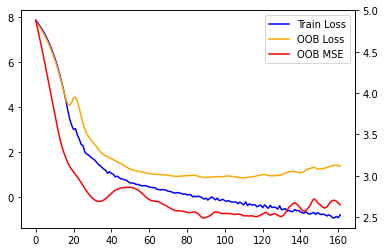

Bootstrap iteration 1 at time 2022-07-05 16:43:34.838830
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.406854152679443, MSE: 3.8232593536376953
Epoch: 0, Loss: 7.816903591156006, OOB Loss: 7.723159313201904, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.6519958972930908, MSE: 2.454744577407837
Epoch: 40, Loss: 1.299145221710205, OOB Loss: 1.3394994735717773, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.1196560859680176, MSE: 2.570542573928833
Epoch: 80, Loss: 0.19193220138549805, OOB Loss: 0.8317131996154785, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.0146615505218506, MSE: 2.388849973678589
Epoch: 120, Loss: -0.28406548500061035, OOB Loss: 0.6783919334411621, LR: 0.00036934432610923556
Early stopped, best epoch: 106, train loss: -0.13690519332885742, best OOB loss: 0.6256108283996582, LR: 0.00033667346834210566


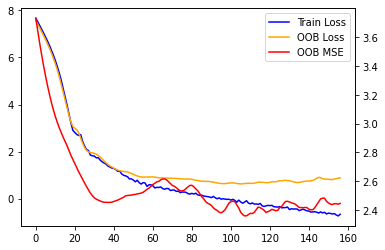

Bootstrap iteration 2 at time 2022-07-05 16:43:52.946356
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.407447814941406, MSE: 2.8716461658477783
Epoch: 0, Loss: 7.916141033172607, OOB Loss: 7.64878511428833, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.853200078010559, MSE: 1.6080148220062256
Epoch: 40, Loss: 1.541945457458496, OOB Loss: 0.8826249837875366, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.822230100631714, MSE: 1.4890646934509277
Epoch: 80, Loss: 0.2591569423675537, OOB Loss: 0.7064847946166992, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.9941322803497314, MSE: 1.4636574983596802
Epoch: 120, Loss: -0.30278968811035156, OOB Loss: 0.716728687286377, LR: 0.00036934432610923556
Early stopped, best epoch: 99, train loss: -0.04902195930480957, best OOB loss: 0.6412181854248047, LR: 0.00034262461655602014


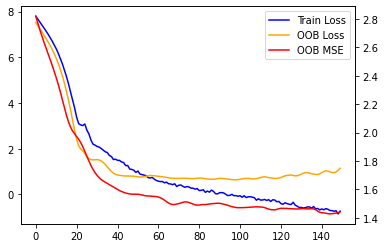

Bootstrap iteration 3 at time 2022-07-05 16:44:09.390538
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.654818058013916, MSE: 2.216369390487671
Epoch: 0, Loss: 8.083948135375977, OOB Loss: 7.833279132843018, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.410917282104492, MSE: 1.8174790143966675
Epoch: 40, Loss: 1.3839426040649414, OOB Loss: 0.7047765254974365, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.4499154090881348, MSE: 1.8029403686523438
Epoch: 80, Loss: 0.08327555656433105, OOB Loss: 0.9222478866577148, LR: 0.00040823971994699836
Early stopped, best epoch: 57, train loss: 0.6285414695739746, best OOB loss: 0.4544963836669922, LR: 0.00038060683174957196


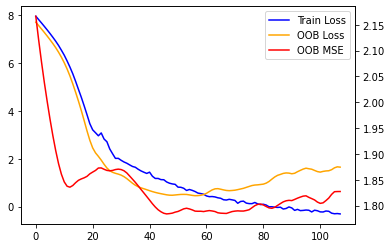

Bootstrap iteration 4 at time 2022-07-05 16:44:21.606009
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -6.838070869445801, MSE: 1.946747899055481
Epoch: 0, Loss: 7.37281608581543, OOB Loss: 7.063384532928467, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.396652936935425, MSE: 1.5556060075759888
Epoch: 40, Loss: 1.4093639850616455, OOB Loss: 0.6020421981811523, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.920158863067627, MSE: 1.5066014528274536
Epoch: 80, Loss: 0.2702631950378418, OOB Loss: 0.1962740421295166, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.2759487628936768, MSE: 1.6442664861679077
Epoch: 120, Loss: -0.23663783073425293, OOB Loss: 0.4844818115234375, LR: 0.00036934432610923556
Early stopped, best epoch: 80, train loss: 0.2702631950378418, best OOB loss: 0.1962740421295166, LR: 0.00035931337178194805


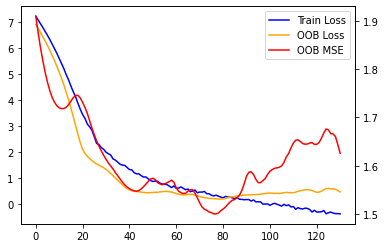

Bootstrap iteration 5 at time 2022-07-05 16:44:36.433232
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -6.862144470214844, MSE: 1.9107375144958496
Epoch: 0, Loss: 7.385133743286133, OOB Loss: 7.053093910217285, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.1187331676483154, MSE: 1.6552220582962036
Epoch: 40, Loss: 1.5367140769958496, OOB Loss: 0.6391375064849854, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.035553455352783, MSE: 1.6115444898605347
Epoch: 80, Loss: 0.28115105628967285, OOB Loss: 0.02043294906616211, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.1639647483825684, MSE: 1.6252822875976562
Epoch: 120, Loss: -0.34455132484436035, OOB Loss: 0.1877584457397461, LR: 0.00036934432610923556
Early stopped, best epoch: 85, train loss: 0.25069308280944824, best OOB loss: 0.006127119064331055, LR: 0.0003548443556478391


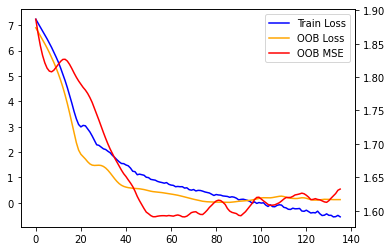

Bootstrap iteration 6 at time 2022-07-05 16:44:53.259872
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.942082405090332, MSE: 6.22678279876709
Epoch: 0, Loss: 8.26859188079834, OOB Loss: 8.415313720703125, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.3501393795013428, MSE: 4.132200717926025
Epoch: 40, Loss: 0.8614344596862793, OOB Loss: 5.802577018737793, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.8190438747406006, MSE: 4.780369281768799
Epoch: 80, Loss: 0.10583806037902832, OOB Loss: 2.8466298580169678, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.5003113746643066, MSE: 4.998931407928467
Epoch: 120, Loss: -0.5929419994354248, OOB Loss: 3.5168490409851074, LR: 0.00036934432610923556
Early stopped, best epoch: 77, train loss: 0.10210490226745605, best OOB loss: 2.563107490539551, LR: 0.0003620217526757433


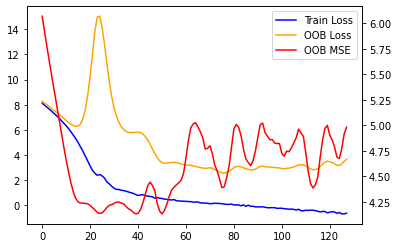

Bootstrap iteration 7 at time 2022-07-05 16:45:07.207359
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.54025411605835, MSE: 3.6888740062713623
Epoch: 0, Loss: 7.925194263458252, OOB Loss: 7.833069324493408, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.284796714782715, MSE: 3.208994150161743
Epoch: 40, Loss: 0.8820803165435791, OOB Loss: 2.645202159881592, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.6556763648986816, MSE: 3.471735954284668
Epoch: 80, Loss: 0.0448763370513916, OOB Loss: 2.0915322303771973, LR: 0.00040823971994699836
Early stopped, best epoch: 66, train loss: 0.21128630638122559, best OOB loss: 1.793701171875, LR: 0.0003721283168945075


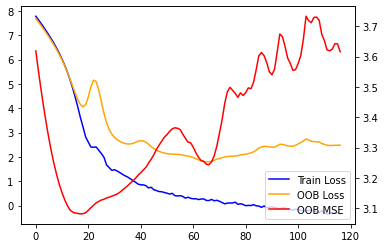

Bootstrap iteration 8 at time 2022-07-05 16:45:20.103826
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.51630973815918, MSE: 2.968198537826538
Epoch: 0, Loss: 7.98176383972168, OOB Loss: 7.803159713745117, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.436432361602783, MSE: 2.222841501235962
Epoch: 40, Loss: 1.2373218536376953, OOB Loss: 1.3449561595916748, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.038548469543457, MSE: 2.284855842590332
Epoch: 80, Loss: 0.23472833633422852, OOB Loss: 1.1150550842285156, LR: 0.00040823971994699836
Early stopped, best epoch: 56, train loss: 0.6516332626342773, best OOB loss: 1.064237356185913, LR: 0.00038156073358353075


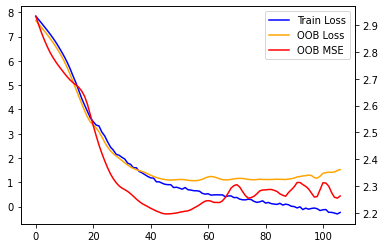

Bootstrap iteration 9 at time 2022-07-05 16:45:32.035288
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -6.980381011962891, MSE: 1.415363073348999
Epoch: 0, Loss: 7.528904438018799, OOB Loss: 7.159248352050781, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.540433645248413, MSE: 1.3107926845550537
Epoch: 40, Loss: 1.5825812816619873, OOB Loss: -0.06326532363891602, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 4.061697483062744, MSE: 1.209720492362976
Epoch: 80, Loss: 0.6052000522613525, OOB Loss: -0.7122392654418945, LR: 0.00040823971994699836
Early stopped, best epoch: 88, train loss: 0.4919424057006836, best OOB loss: -0.8106176853179932, LR: 0.00039914564637483674


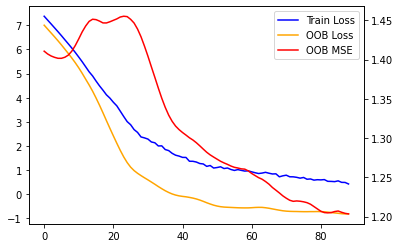

Bootstrap iteration 10 at time 2022-07-05 16:45:43.141005
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.168269634246826, MSE: 2.3473126888275146
Epoch: 0, Loss: 7.660451889038086, OOB Loss: 7.372472286224365, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.6079447269439697, MSE: 1.9328099489212036
Epoch: 40, Loss: 1.4491775035858154, OOB Loss: 0.9792041778564453, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.3947980403900146, MSE: 1.8781713247299194
Epoch: 80, Loss: 0.06980538368225098, OOB Loss: 0.5572423934936523, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.8572776317596436, MSE: 1.8355395793914795
Epoch: 120, Loss: -0.4795854091644287, OOB Loss: 0.6569380760192871, LR: 0.00036934432610923556
Early stopped, best epoch: 94, train loss: -0.0678396224975586, best OOB loss: 0.45775604248046875, LR: 0.0003469397336347074


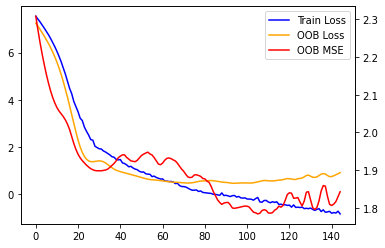

Bootstrap iteration 11 at time 2022-07-05 16:45:59.095113
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -6.943138122558594, MSE: 4.322861671447754
Epoch: 0, Loss: 7.420719146728516, OOB Loss: 7.444510459899902, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.504347562789917, MSE: 3.034313201904297
Epoch: 40, Loss: 1.1241395473480225, OOB Loss: 3.2387192249298096, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.988743305206299, MSE: 2.9222493171691895
Epoch: 80, Loss: 0.04247641563415527, OOB Loss: 2.006503105163574, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.8269734382629395, MSE: 3.022825241088867
Epoch: 120, Loss: -0.5363366603851318, OOB Loss: 3.0324764251708984, LR: 0.00036934432610923556
Early stopped, best epoch: 71, train loss: 0.21434736251831055, best OOB loss: 1.867344617843628, LR: 0.0003674999128807276


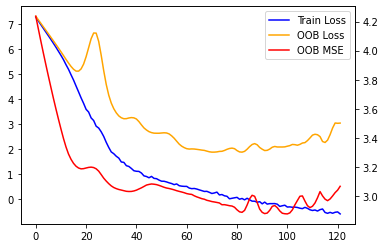

Bootstrap iteration 12 at time 2022-07-05 16:46:12.460342
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -6.735715866088867, MSE: 3.2668821811676025
Epoch: 0, Loss: 7.2484331130981445, OOB Loss: 7.139090538024902, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.2193074226379395, MSE: 2.1857216358184814
Epoch: 40, Loss: 1.1927356719970703, OOB Loss: 1.2913377285003662, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.433445453643799, MSE: 2.1692159175872803
Epoch: 80, Loss: 0.1226651668548584, OOB Loss: 1.0249888896942139, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.959606170654297, MSE: 2.1757278442382812
Epoch: 120, Loss: -0.36452364921569824, OOB Loss: 0.7893438339233398, LR: 0.00036934432610923556
OOB Mean Log Det Precision: 3.555312395095825, MSE: 2.2111496925354004
Epoch: 160, Loss: -0.8662624359130859, OOB Loss: 0.9814703464508057, LR: 0.0003341547246965484
OOB Mean Log Det Precision: 4.0348286628723145, MSE: 2.208472490310669

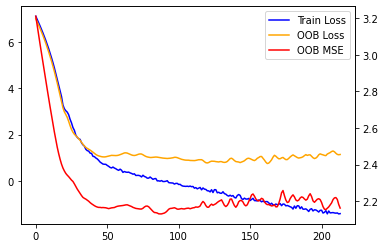

Bootstrap iteration 13 at time 2022-07-05 16:46:34.423970
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.317645072937012, MSE: 5.150360107421875
Epoch: 0, Loss: 7.7232489585876465, OOB Loss: 7.771048069000244, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.2015726566314697, MSE: 3.726069927215576
Epoch: 40, Loss: 0.932532787322998, OOB Loss: 5.509803771972656, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.480573892593384, MSE: 3.803194761276245
Epoch: 80, Loss: -0.04395484924316406, OOB Loss: 2.53252911567688, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.179478406906128, MSE: 4.393789291381836
Epoch: 120, Loss: -0.5445318222045898, OOB Loss: 3.9569265842437744, LR: 0.00036934432610923556
Early stopped, best epoch: 74, train loss: 0.02469325065612793, best OOB loss: 2.3272767066955566, LR: 0.0003656647101907795


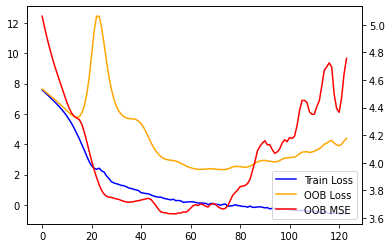

Bootstrap iteration 14 at time 2022-07-05 16:46:47.552408
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.44067907333374, MSE: 2.7458202838897705
Epoch: 0, Loss: 7.895483493804932, OOB Loss: 7.659492492675781, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.507009983062744, MSE: 2.1690351963043213
Epoch: 40, Loss: 1.0729284286499023, OOB Loss: 2.5659923553466797, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.5714526176452637, MSE: 2.0343425273895264
Epoch: 80, Loss: -0.09085726737976074, OOB Loss: 3.2454915046691895, LR: 0.00040823971994699836
Early stopped, best epoch: 44, train loss: 0.8247501850128174, best OOB loss: 2.22670316696167, LR: 0.0003931957570841881


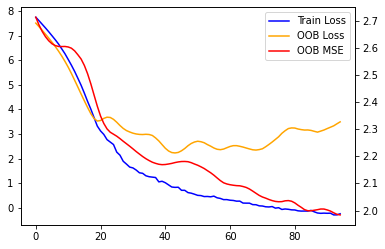

Bootstrap iteration 15 at time 2022-07-05 16:46:57.773382
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.0822272300720215, MSE: 2.380917549133301
Epoch: 0, Loss: 7.606392860412598, OOB Loss: 7.318312644958496, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.9599450826644897, MSE: 1.718953251838684
Epoch: 40, Loss: 1.439568042755127, OOB Loss: 0.6793504953384399, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.7635607719421387, MSE: 1.6825981140136719
Epoch: 80, Loss: 0.4803895950317383, OOB Loss: 0.3686671257019043, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.973876714706421, MSE: 1.7318739891052246
Epoch: 120, Loss: -0.05539393424987793, OOB Loss: 0.4573047161102295, LR: 0.00036934432610923556
Early stopped, best epoch: 103, train loss: 0.21930813789367676, best OOB loss: 0.15341901779174805, LR: 0.0003392111974129261


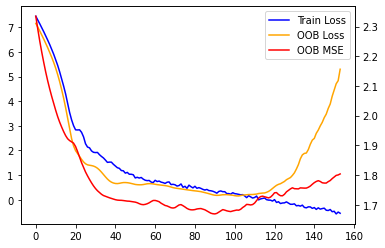

Bootstrap iteration 16 at time 2022-07-05 16:47:14.801832
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.8020782470703125, MSE: 4.909057140350342
Epoch: 0, Loss: 8.14137077331543, OOB Loss: 8.312867164611816, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.190650701522827, MSE: 3.424656867980957
Epoch: 40, Loss: 1.2203922271728516, OOB Loss: 3.852705240249634, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.377021074295044, MSE: 3.3510401248931885
Epoch: 80, Loss: 0.30288100242614746, OOB Loss: 1.4743561744689941, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.084075689315796, MSE: 3.286850690841675
Epoch: 120, Loss: -0.20824122428894043, OOB Loss: 1.3704960346221924, LR: 0.00036934432610923556
Early stopped, best epoch: 99, train loss: 0.09719991683959961, best OOB loss: 1.2430171966552734, LR: 0.00034262461655602014


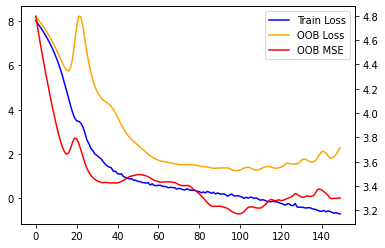

Bootstrap iteration 17 at time 2022-07-05 16:47:31.073990
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -6.555590629577637, MSE: 2.1059327125549316
Epoch: 0, Loss: 7.258162021636963, OOB Loss: 6.822484970092773, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.7547427415847778, MSE: 1.476875901222229
Epoch: 40, Loss: 1.5728943347930908, OOB Loss: 0.5762563943862915, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.8593764305114746, MSE: 1.4027806520462036
Epoch: 80, Loss: 0.2943854331970215, OOB Loss: 0.23578476905822754, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.6088829040527344, MSE: 1.398563265800476
Epoch: 120, Loss: -0.1494152545928955, OOB Loss: 0.16350603103637695, LR: 0.00036934432610923556
OOB Mean Log Det Precision: 4.000038146972656, MSE: 1.4130988121032715
Epoch: 160, Loss: -0.6340417861938477, OOB Loss: 0.11050891876220703, LR: 0.0003341547246965484
OOB Mean Log Det Precision: 4.3097991943359375, MSE: 1.41286361217498

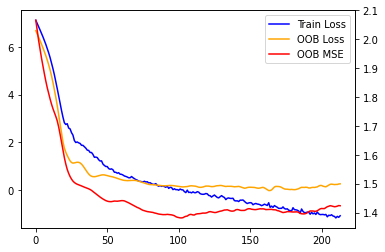

Bootstrap iteration 18 at time 2022-07-05 16:47:53.452613
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.115063190460205, MSE: 2.4047739505767822
Epoch: 0, Loss: 7.603629112243652, OOB Loss: 7.321048736572266, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 3.830366849899292, MSE: 2.0112321376800537
Epoch: 40, Loss: 1.2054078578948975, OOB Loss: 3.42899489402771, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.943065881729126, MSE: 1.87568998336792
Epoch: 80, Loss: 0.19618558883666992, OOB Loss: 1.8539378643035889, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 4.729825496673584, MSE: 1.7957671880722046
Epoch: 120, Loss: -0.3242640495300293, OOB Loss: 3.893362522125244, LR: 0.00036934432610923556
Early stopped, best epoch: 75, train loss: 0.29823875427246094, best OOB loss: 1.7510762214660645, LR: 0.0003638386720442643


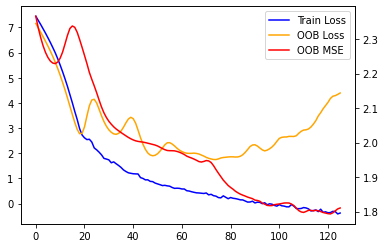

Bootstrap iteration 19 at time 2022-07-05 16:48:06.285086
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -6.809304714202881, MSE: 2.3786239624023438
Epoch: 0, Loss: 7.298624515533447, OOB Loss: 7.047038555145264, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.9338126182556152, MSE: 2.0383694171905518
Epoch: 40, Loss: 1.334777593612671, OOB Loss: 2.275367259979248, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.9499433040618896, MSE: 2.093468189239502
Epoch: 80, Loss: 0.19221878051757812, OOB Loss: 1.9658477306365967, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 4.73551607131958, MSE: 2.07038950920105
Epoch: 120, Loss: -0.3413701057434082, OOB Loss: 3.446990489959717, LR: 0.00036934432610923556
Early stopped, best epoch: 72, train loss: 0.2894895076751709, best OOB loss: 1.6849822998046875, LR: 0.0003665811630985258


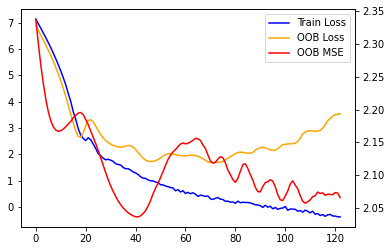

Time 0, 2022-07-05 16:48:20.399002
Time 5, 2022-07-05 16:53:19.378112
Time 10, 2022-07-05 16:58:19.680128
Time 15, 2022-07-05 17:03:19.237363
Time 20, 2022-07-05 17:08:15.807694
Time 25, 2022-07-05 17:13:10.678803
Size of x_mat before appending MARX (731, 6)
Size of x_mat_marx (731, 24)
x_mat_all size (731, 30)
Size of X_train afer appending time (731, 153) Time dummy setting: 2
x_pos {'inf': [0, 3], 'unrate': [1, 4], 'DGS3': [2, 5]}
Size of X_train (701, 153)
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 1

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


Epoch: 0, Loss: 0.8483585119247437, OOB Loss: 1.1895030736923218
Epoch: 40, Loss: 0.5739874243736267, OOB Loss: 1.0518121719360352
Early stopped, best epoch: 27, train loss: 0.5802574753761292, best OOB loss: 0.9712986946105957, LR: 0.00041028859863643906


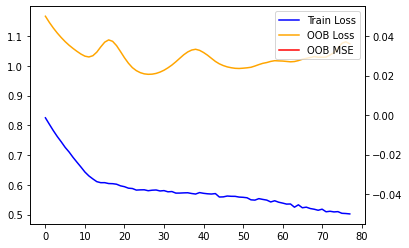

Bootstrap iteration 1 at time 2022-07-05 17:18:19.772000
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.1474627256393433, OOB Loss: 1.2843310832977295
Epoch: 40, Loss: 0.647300124168396, OOB Loss: 0.624056339263916
Epoch: 80, Loss: 0.5807347297668457, OOB Loss: 0.7030829787254333
Early stopped, best epoch: 43, train loss: 0.6390376091003418, best OOB loss: 0.6225217580795288, LR: 0.00039418121010946174


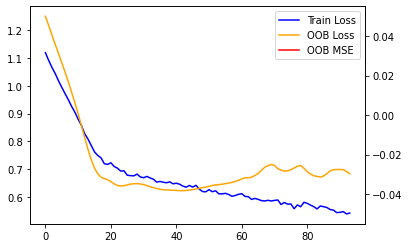

Bootstrap iteration 2 at time 2022-07-05 17:18:38.335463
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.0952355861663818, OOB Loss: 0.6166577339172363
Epoch: 40, Loss: 0.6645373106002808, OOB Loss: 0.5199587345123291
Epoch: 80, Loss: 0.5997523069381714, OOB Loss: 0.49220332503318787
Epoch: 120, Loss: 0.5104475021362305, OOB Loss: 0.4902333617210388
Epoch: 160, Loss: 0.462927907705307, OOB Loss: 0.5051620006561279
Early stopped, best epoch: 114, train loss: 0.5352394580841064, best OOB loss: 0.48422449827194214, LR: 0.00032999862316169143


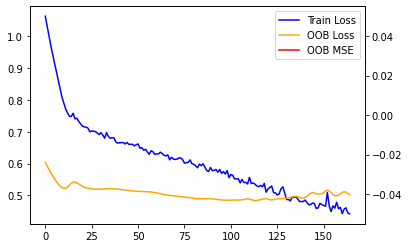

Bootstrap iteration 3 at time 2022-07-05 17:19:11.176289
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.9090254306793213, OOB Loss: 0.7386178970336914
Epoch: 40, Loss: 0.6341353058815002, OOB Loss: 0.6217162609100342
Early stopped, best epoch: 15, train loss: 0.6985300779342651, best OOB loss: 0.6111400127410889, LR: 0.0004227996278567497


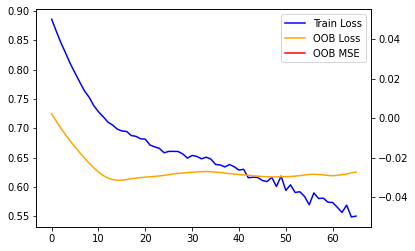

Bootstrap iteration 4 at time 2022-07-05 17:19:24.835841
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.8940331935882568, OOB Loss: 0.9580204486846924
Epoch: 40, Loss: 0.6115662455558777, OOB Loss: 0.6641730070114136
Epoch: 80, Loss: 0.5172311663627625, OOB Loss: 0.7641967535018921
Early stopped, best epoch: 39, train loss: 0.6065158843994141, best OOB loss: 0.6639589071273804, LR: 0.00039814778225889965


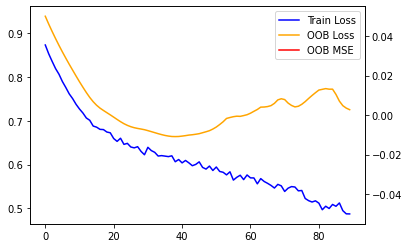

Bootstrap iteration 5 at time 2022-07-05 17:19:43.665391
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.0493202209472656, OOB Loss: 0.43603527545928955
Epoch: 40, Loss: 0.719393253326416, OOB Loss: 0.3583091199398041
Epoch: 80, Loss: 0.6251944303512573, OOB Loss: 0.3298969268798828
Epoch: 120, Loss: 0.5221542716026306, OOB Loss: 0.32542309165000916
Epoch: 160, Loss: 0.4746363162994385, OOB Loss: 0.32385796308517456
Epoch: 200, Loss: 0.41927963495254517, OOB Loss: 0.32034942507743835
Epoch: 240, Loss: 0.3962726593017578, OOB Loss: 0.32513105869293213
Early stopped, best epoch: 200, train loss: 0.41927963495254517, best OOB loss: 0.32034942507743835, LR: 0.00026608592513852796


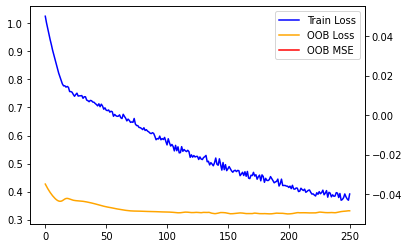

Bootstrap iteration 6 at time 2022-07-05 17:20:35.187461
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.623534619808197, OOB Loss: 1.7924857139587402
Epoch: 40, Loss: 0.45167168974876404, OOB Loss: 1.3801755905151367
Epoch: 80, Loss: 0.3941132426261902, OOB Loss: 1.695651888847351
Early stopped, best epoch: 42, train loss: 0.4534812569618225, best OOB loss: 1.3787429332733154, LR: 0.00039516913294181626


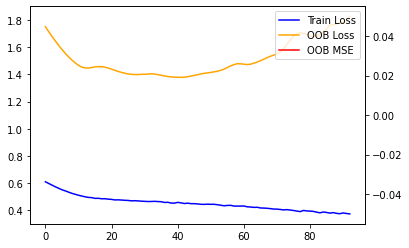

Bootstrap iteration 7 at time 2022-07-05 17:20:53.822205
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.8161531686782837, OOB Loss: 1.5819891691207886
Epoch: 40, Loss: 0.5517098307609558, OOB Loss: 0.9998239278793335
Epoch: 80, Loss: 0.5033931136131287, OOB Loss: 0.9972638487815857
Epoch: 120, Loss: 0.4190557897090912, OOB Loss: 1.0867708921432495
Early stopped, best epoch: 86, train loss: 0.47834691405296326, best OOB loss: 0.9931380152702332, LR: 0.0003539572447587195


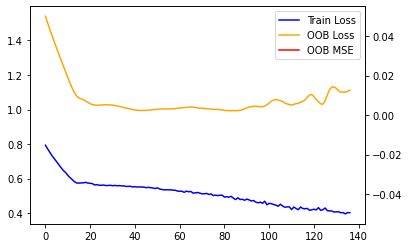

Bootstrap iteration 8 at time 2022-07-05 17:21:21.196298
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.8795950412750244, OOB Loss: 1.4998968839645386
Epoch: 40, Loss: 0.5767897963523865, OOB Loss: 0.8776940703392029
Epoch: 80, Loss: 0.5064773559570312, OOB Loss: 0.9647437334060669
Early stopped, best epoch: 42, train loss: 0.5759613513946533, best OOB loss: 0.8767719268798828, LR: 0.00039516913294181626


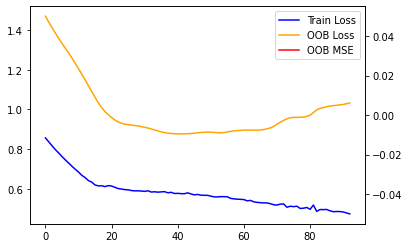

Bootstrap iteration 9 at time 2022-07-05 17:21:40.302808
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.1502145528793335, OOB Loss: 0.40529853105545044
Epoch: 40, Loss: 0.7404239177703857, OOB Loss: 0.3456815481185913
Epoch: 80, Loss: 0.6593831777572632, OOB Loss: 0.32100868225097656
Epoch: 120, Loss: 0.534730851650238, OOB Loss: 0.305328369140625
Epoch: 160, Loss: 0.47072529792785645, OOB Loss: 0.30657023191452026
Early stopped, best epoch: 150, train loss: 0.46979472041130066, best OOB loss: 0.3043884038925171, LR: 0.00030459661127491027


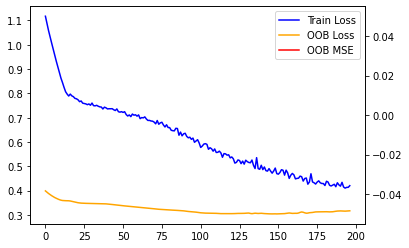

Bootstrap iteration 10 at time 2022-07-05 17:22:21.036658
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.9260745048522949, OOB Loss: 1.12233567237854
Epoch: 40, Loss: 0.585854709148407, OOB Loss: 0.7696160078048706
Epoch: 80, Loss: 0.5143746733665466, OOB Loss: 0.7994261980056763
Early stopped, best epoch: 39, train loss: 0.5870071649551392, best OOB loss: 0.7688971757888794, LR: 0.00039814778225889965


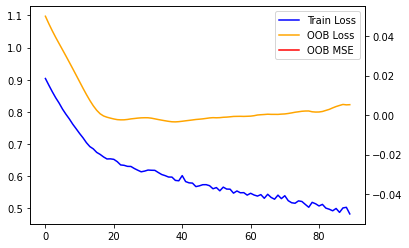

Bootstrap iteration 11 at time 2022-07-05 17:22:39.428529
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.8335697054862976, OOB Loss: 1.4127262830734253
Epoch: 40, Loss: 0.54301518201828, OOB Loss: 0.9458922743797302
Epoch: 80, Loss: 0.5080465078353882, OOB Loss: 0.989973247051239
Early stopped, best epoch: 36, train loss: 0.5482444167137146, best OOB loss: 0.9432282447814941, LR: 0.00040215426928559


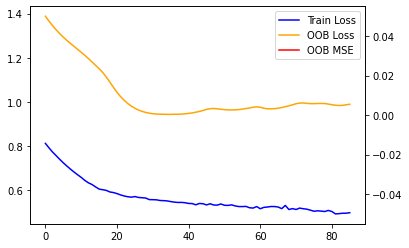

Bootstrap iteration 12 at time 2022-07-05 17:22:57.172090
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.042269229888916, OOB Loss: 0.6850473284721375
Epoch: 40, Loss: 0.6789189577102661, OOB Loss: 0.4835459589958191
Epoch: 80, Loss: 0.5698754787445068, OOB Loss: 0.4832704961299896
Epoch: 120, Loss: 0.5007323622703552, OOB Loss: 0.47326797246932983
Epoch: 160, Loss: 0.4456942081451416, OOB Loss: 0.4671720266342163
Early stopped, best epoch: 144, train loss: 0.46472620964050293, best OOB loss: 0.45671242475509644, LR: 0.00030612532461470494


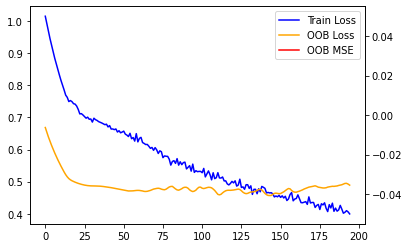

Bootstrap iteration 13 at time 2022-07-05 17:23:36.426839
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.0101921558380127, OOB Loss: 0.7517813444137573
Epoch: 40, Loss: 0.6509612798690796, OOB Loss: 0.6500720977783203
Epoch: 80, Loss: 0.5588304996490479, OOB Loss: 0.6566515564918518
Early stopped, best epoch: 61, train loss: 0.609980583190918, best OOB loss: 0.6325377225875854, LR: 0.00037775941094256375


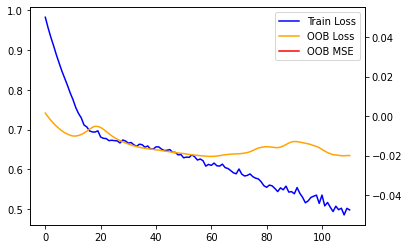

Bootstrap iteration 14 at time 2022-07-05 17:23:59.329476
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.7060576677322388, OOB Loss: 1.190786600112915
Epoch: 40, Loss: 0.5439118146896362, OOB Loss: 0.948544442653656
Epoch: 80, Loss: 0.47599124908447266, OOB Loss: 0.9544321894645691
Early stopped, best epoch: 55, train loss: 0.5247531533241272, best OOB loss: 0.918303906917572, LR: 0.000382517026148903


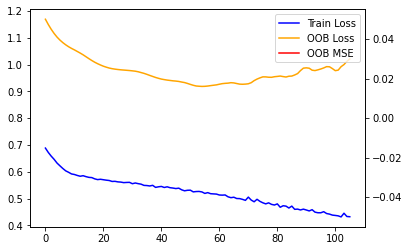

Bootstrap iteration 15 at time 2022-07-05 17:24:21.664592
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.9174805879592896, OOB Loss: 1.0738029479980469
Epoch: 40, Loss: 0.5667634010314941, OOB Loss: 0.8891433477401733
Epoch: 80, Loss: 0.4945058226585388, OOB Loss: 0.9859488010406494
Early stopped, best epoch: 29, train loss: 0.5864269733428955, best OOB loss: 0.85899817943573, LR: 0.00040823971994699836


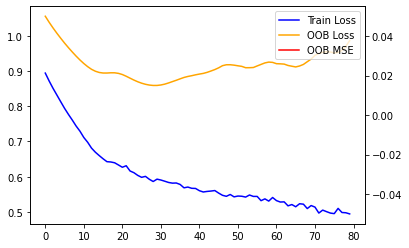

Bootstrap iteration 16 at time 2022-07-05 17:24:37.955666
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.745639979839325, OOB Loss: 1.172356367111206
Epoch: 40, Loss: 0.5457367897033691, OOB Loss: 0.9241654872894287
Epoch: 80, Loss: 0.44388577342033386, OOB Loss: 0.9204052686691284
Epoch: 120, Loss: 0.37736380100250244, OOB Loss: 1.0093698501586914
Early stopped, best epoch: 72, train loss: 0.4556606709957123, best OOB loss: 0.9044010639190674, LR: 0.0003665811630985258


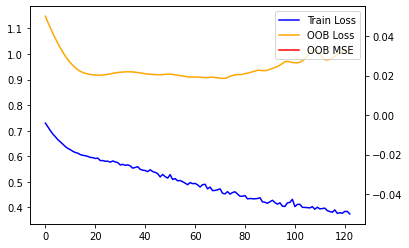

Bootstrap iteration 17 at time 2022-07-05 17:25:02.998088
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.845380961894989, OOB Loss: 0.6768761873245239
Epoch: 40, Loss: 0.6529912948608398, OOB Loss: 0.5631476640701294
Epoch: 80, Loss: 0.5607513189315796, OOB Loss: 0.5417724251747131
Epoch: 120, Loss: 0.5037714242935181, OOB Loss: 0.5578593015670776
Early stopped, best epoch: 93, train loss: 0.5382093787193298, best OOB loss: 0.5347777605056763, LR: 0.000347809256776649


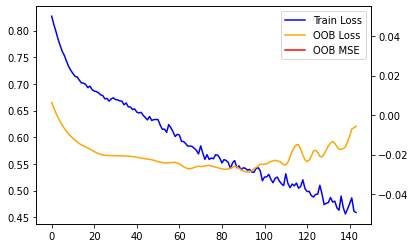

Bootstrap iteration 18 at time 2022-07-05 17:25:32.850424
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.8471325635910034, OOB Loss: 1.1615538597106934
Epoch: 40, Loss: 0.5701252222061157, OOB Loss: 0.8882138133049011
Epoch: 80, Loss: 0.4798651337623596, OOB Loss: 0.9524590969085693
Early stopped, best epoch: 47, train loss: 0.5545777082443237, best OOB loss: 0.885753333568573, LR: 0.00039123223577224893


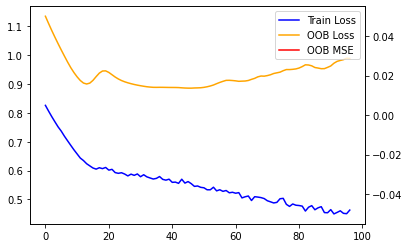

Bootstrap iteration 19 at time 2022-07-05 17:25:52.291828
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.085828185081482, OOB Loss: 0.8468942642211914
Epoch: 40, Loss: 0.6471207141876221, OOB Loss: 0.5904896259307861
Epoch: 80, Loss: 0.5652894973754883, OOB Loss: 0.6824270486831665
Early stopped, best epoch: 35, train loss: 0.6563211679458618, best OOB loss: 0.5880203247070312, LR: 0.00040215426928559


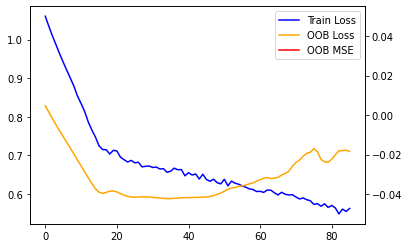

Time 0, 2022-07-05 17:26:10.932178
Time 5, 2022-07-05 17:31:16.582977
Time 10, 2022-07-05 17:36:16.116596
Time 15, 2022-07-05 17:41:15.540250
Time 20, 2022-07-05 17:46:11.642003
Time 25, 2022-07-05 17:51:06.385422
Size of x_mat before appending MARX (731, 6)
Size of x_mat_marx (731, 24)
x_mat_all size (731, 30)
Size of X_train afer appending time (731, 153) Time dummy setting: 2
x_pos {'inf': [0, 3], 'unrate': [1, 4], 'DGS3': [2, 5]}
Size of X_train (701, 153)
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 1

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


Epoch: 0, Loss: 7.477919101715088, OOB Loss: 7.239621162414551, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.837977409362793, MSE: 2.1866509914398193
Epoch: 40, Loss: 1.1975834369659424, OOB Loss: 2.2700819969177246, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.3541741371154785, MSE: 2.5718934535980225
Epoch: 80, Loss: 0.006233692169189453, OOB Loss: 2.1975111961364746, LR: 0.00040823971994699836
Early stopped, best epoch: 49, train loss: 0.7645840644836426, best OOB loss: 1.8535141944885254, LR: 0.0003883053234953742


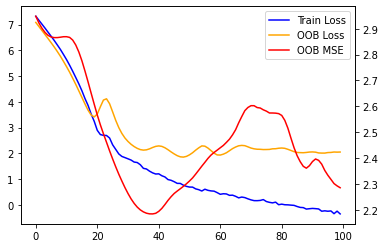

Bootstrap iteration 1 at time 2022-07-05 17:56:12.604558
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.404508590698242, MSE: 3.798426866531372
Epoch: 0, Loss: 7.81461238861084, OOB Loss: 7.7757439613342285, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.2095746994018555, MSE: 3.0753235816955566
Epoch: 40, Loss: 1.1239908933639526, OOB Loss: 2.9697604179382324, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.6079094409942627, MSE: 3.402270793914795
Epoch: 80, Loss: 0.22164368629455566, OOB Loss: 2.1224710941314697, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.8208274841308594, MSE: 3.6400928497314453
Epoch: 120, Loss: -0.37110209465026855, OOB Loss: 3.15863037109375, LR: 0.00036934432610923556
Early stopped, best epoch: 82, train loss: 0.21187496185302734, best OOB loss: 2.1078100204467773, LR: 0.00035751905063161196


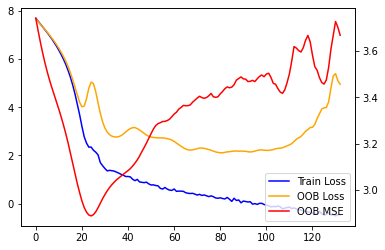

Bootstrap iteration 2 at time 2022-07-05 17:56:26.957728
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.5732831954956055, MSE: 2.725320339202881
Epoch: 0, Loss: 7.998683452606201, OOB Loss: 7.821771621704102, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.540370225906372, MSE: 2.2932419776916504
Epoch: 40, Loss: 1.1235566139221191, OOB Loss: 1.5158140659332275, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 1.8060940504074097, MSE: 2.2684359550476074
Epoch: 80, Loss: -0.040644168853759766, OOB Loss: 0.9728258848190308, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.485300302505493, MSE: 2.3341784477233887
Epoch: 120, Loss: -0.6915385723114014, OOB Loss: 1.203312873840332, LR: 0.00036934432610923556
Early stopped, best epoch: 82, train loss: -0.07384634017944336, best OOB loss: 0.9557818174362183, LR: 0.00035751905063161196


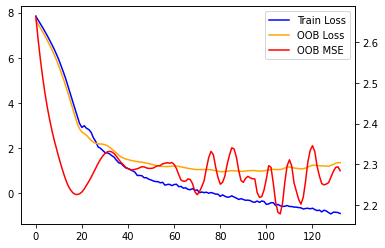

Bootstrap iteration 3 at time 2022-07-05 17:56:41.732866
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.826783180236816, MSE: 4.022572040557861
Epoch: 0, Loss: 8.226045608520508, OOB Loss: 8.156386375427246, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.1532270908355713, MSE: 3.0400426387786865
Epoch: 40, Loss: 0.9578325748443604, OOB Loss: 3.7545859813690186, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.4354662895202637, MSE: 2.836930990219116
Epoch: 80, Loss: -0.1876659393310547, OOB Loss: 2.838388442993164, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.0269088745117188, MSE: 2.959369659423828
Epoch: 120, Loss: -0.7251348495483398, OOB Loss: 3.869192600250244, LR: 0.00036934432610923556
Early stopped, best epoch: 79, train loss: -0.18352389335632324, best OOB loss: 2.831700325012207, LR: 0.00036021390654831885


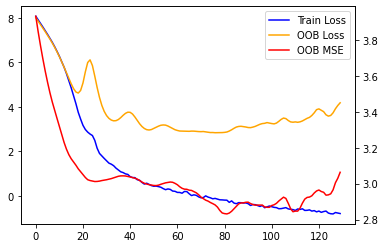

Bootstrap iteration 4 at time 2022-07-05 17:56:55.295423
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.3561272621154785, MSE: 2.781672716140747
Epoch: 0, Loss: 7.7794036865234375, OOB Loss: 7.6095075607299805, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.784547805786133, MSE: 2.224666118621826
Epoch: 40, Loss: 1.0161285400390625, OOB Loss: 2.603461742401123, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.310459852218628, MSE: 2.0940933227539062
Epoch: 80, Loss: -0.01581263542175293, OOB Loss: 1.618225336074829, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 4.066898345947266, MSE: 2.0793004035949707
Epoch: 120, Loss: -0.5247058868408203, OOB Loss: 2.5092825889587402, LR: 0.00036934432610923556
Early stopped, best epoch: 89, train loss: -0.10274815559387207, best OOB loss: 1.512786626815796, LR: 0.00035130919659078646


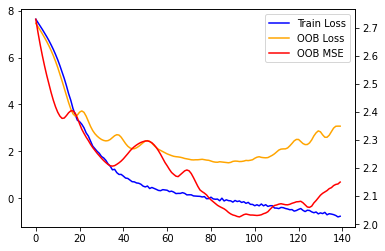

Bootstrap iteration 5 at time 2022-07-05 17:57:10.327738
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.7194976806640625, MSE: 3.0629289150238037
Epoch: 0, Loss: 8.103230476379395, OOB Loss: 7.984942436218262, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.3751251697540283, MSE: 2.5917277336120605
Epoch: 40, Loss: 1.123960256576538, OOB Loss: 2.3621838092803955, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.3491530418395996, MSE: 2.7111029624938965
Epoch: 80, Loss: 0.18945789337158203, OOB Loss: 1.8045411109924316, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.804518222808838, MSE: 2.669893980026245
Epoch: 120, Loss: -0.43739819526672363, OOB Loss: 1.6411676406860352, LR: 0.00036934432610923556
Early stopped, best epoch: 100, train loss: -0.08036160469055176, best OOB loss: 1.5542690753936768, LR: 0.0003417680550146301


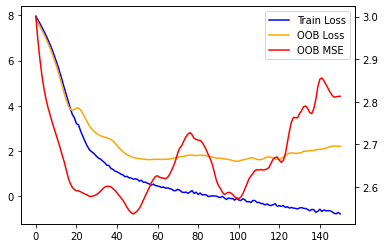

Bootstrap iteration 6 at time 2022-07-05 17:57:26.375367
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.385853290557861, MSE: 3.6960766315460205
Epoch: 0, Loss: 7.788491725921631, OOB Loss: 7.713573932647705, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.3070852756500244, MSE: 2.769578456878662
Epoch: 40, Loss: 1.1275019645690918, OOB Loss: 1.9433023929595947, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 1.8334280252456665, MSE: 2.4727635383605957
Epoch: 80, Loss: 0.01876044273376465, OOB Loss: 0.9400674104690552, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.546053171157837, MSE: 2.504456043243408
Epoch: 120, Loss: -0.508657693862915, OOB Loss: 1.1007697582244873, LR: 0.00036934432610923556
Early stopped, best epoch: 79, train loss: 0.07625699043273926, best OOB loss: 0.9229671955108643, LR: 0.00036111669829405396


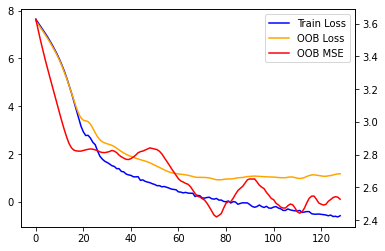

Bootstrap iteration 7 at time 2022-07-05 17:57:41.052741
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -8.042490005493164, MSE: 3.2450923919677734
Epoch: 0, Loss: 8.382599830627441, OOB Loss: 8.270957946777344, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.516925096511841, MSE: 2.595219135284424
Epoch: 40, Loss: 1.0786747932434082, OOB Loss: 1.917639970779419, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.0273566246032715, MSE: 2.693375825881958
Epoch: 80, Loss: 0.21373796463012695, OOB Loss: 1.4325313568115234, LR: 0.00040823971994699836
Early stopped, best epoch: 68, train loss: 0.38872480392456055, best OOB loss: 1.2197034358978271, LR: 0.00037027000111201555


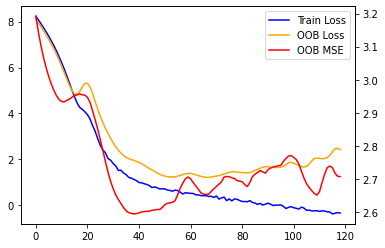

Bootstrap iteration 8 at time 2022-07-05 17:57:54.020439
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -6.747669219970703, MSE: 1.4288713932037354
Epoch: 0, Loss: 7.31863260269165, OOB Loss: 6.9020891189575195, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.724108934402466, MSE: 1.2390992641448975
Epoch: 40, Loss: 1.6249186992645264, OOB Loss: -0.13624930381774902, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 4.258537292480469, MSE: 1.137772560119629
Epoch: 80, Loss: 0.4979374408721924, OOB Loss: -0.6200716495513916, LR: 0.00040823971994699836
Early stopped, best epoch: 79, train loss: 0.517223596572876, best OOB loss: -0.622023344039917, LR: 0.0004001460114033451


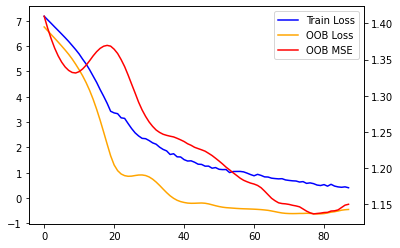

Bootstrap iteration 9 at time 2022-07-05 17:58:04.507169
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.657094478607178, MSE: 2.5548276901245117
Epoch: 0, Loss: 8.066903114318848, OOB Loss: 7.845950603485107, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.9403395652770996, MSE: 1.738128662109375
Epoch: 40, Loss: 1.4696296453475952, OOB Loss: 0.8103253841400146, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.9169492721557617, MSE: 1.7997541427612305
Epoch: 80, Loss: 0.4201927185058594, OOB Loss: 0.11209583282470703, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.442922353744507, MSE: 1.8506464958190918
Epoch: 120, Loss: -0.09933352470397949, OOB Loss: 0.1982126235961914, LR: 0.00036934432610923556
Early stopped, best epoch: 79, train loss: 0.45192980766296387, best OOB loss: 0.10958075523376465, LR: 0.00036021390654831885


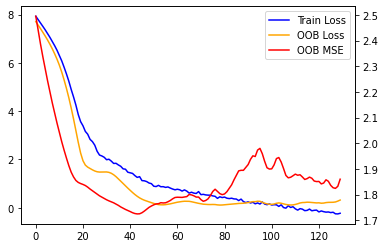

Bootstrap iteration 10 at time 2022-07-05 17:58:18.572765
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.582784175872803, MSE: 2.0806407928466797
Epoch: 0, Loss: 7.959314823150635, OOB Loss: 7.753398418426514, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.558351516723633, MSE: 1.9150112867355347
Epoch: 40, Loss: 1.2433180809020996, OOB Loss: 1.0136325359344482, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.300424098968506, MSE: 1.8254895210266113
Epoch: 80, Loss: 0.10218143463134766, OOB Loss: 0.7165226936340332, LR: 0.00040823971994699836
Early stopped, best epoch: 58, train loss: 0.5071401596069336, best OOB loss: 0.677154541015625, LR: 0.00037965531467019806


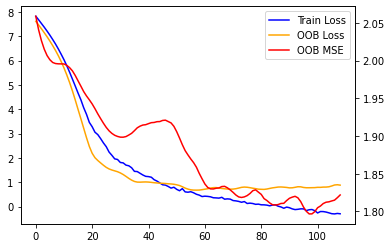

Bootstrap iteration 11 at time 2022-07-05 17:58:30.764305
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -6.6314377784729, MSE: 2.2297117710113525
Epoch: 0, Loss: 7.144979000091553, OOB Loss: 6.865405082702637, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.7625144720077515, MSE: 1.9098665714263916
Epoch: 40, Loss: 1.5752665996551514, OOB Loss: 1.0759412050247192, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.546858787536621, MSE: 1.8965468406677246
Epoch: 80, Loss: 0.2993428707122803, OOB Loss: 0.44346094131469727, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.357612371444702, MSE: 1.9147415161132812
Epoch: 120, Loss: -0.21199774742126465, OOB Loss: 0.4922354221343994, LR: 0.00036934432610923556
Early stopped, best epoch: 99, train loss: 0.045832157135009766, best OOB loss: 0.42116403579711914, LR: 0.00034262461655602014


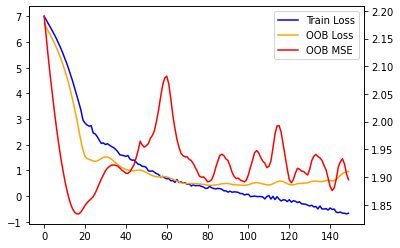

Bootstrap iteration 12 at time 2022-07-05 17:58:47.085536
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -8.173882484436035, MSE: 3.5295214653015137
Epoch: 0, Loss: 8.509541511535645, OOB Loss: 8.403342247009277, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.0551661252975464, MSE: 2.6038601398468018
Epoch: 40, Loss: 1.2438123226165771, OOB Loss: 1.9594448804855347, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 1.1795012950897217, MSE: 2.4330477714538574
Epoch: 80, Loss: 0.06644749641418457, OOB Loss: 1.5600695610046387, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 1.7761163711547852, MSE: 2.45784592628479
Epoch: 120, Loss: -0.28034138679504395, OOB Loss: 1.5200443267822266, LR: 0.00036934432610923556
Early stopped, best epoch: 97, train loss: -0.12540602684020996, best OOB loss: 1.4486453533172607, LR: 0.0003443441853315194


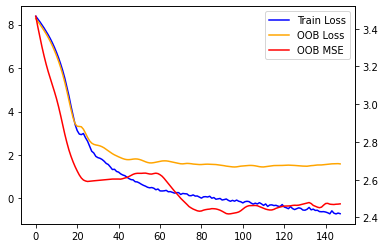

Bootstrap iteration 13 at time 2022-07-05 17:59:03.334421
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -8.20993709564209, MSE: 3.7254815101623535
Epoch: 0, Loss: 8.508766174316406, OOB Loss: 8.460850715637207, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.1164748668670654, MSE: 2.8341939449310303
Epoch: 40, Loss: 0.9841947555541992, OOB Loss: 2.521127462387085, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.446882486343384, MSE: 2.8651092052459717
Epoch: 80, Loss: -0.13419389724731445, OOB Loss: 2.293102502822876, LR: 0.00040823971994699836
Early stopped, best epoch: 50, train loss: 0.5130383968353271, best OOB loss: 1.7693887948989868, LR: 0.00038733456018663577


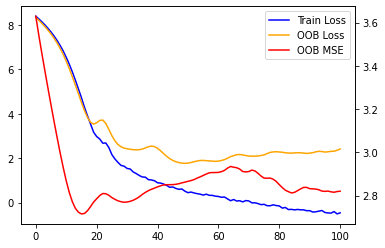

Bootstrap iteration 14 at time 2022-07-05 17:59:14.283993
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.408428192138672, MSE: 2.094937801361084
Epoch: 0, Loss: 7.903902053833008, OOB Loss: 7.61171293258667, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.899958848953247, MSE: 1.453996181488037
Epoch: 40, Loss: 1.4301197528839111, OOB Loss: 0.2808403968811035, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.5690205097198486, MSE: 1.3202987909317017
Epoch: 80, Loss: 0.41727280616760254, OOB Loss: 0.007408618927001953, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.1929736137390137, MSE: 1.286765217781067
Epoch: 120, Loss: -0.2277669906616211, OOB Loss: 1.5151152610778809, LR: 0.00036934432610923556
Early stopped, best epoch: 77, train loss: 0.4892997741699219, best OOB loss: -0.03818798065185547, LR: 0.0003656647101907795


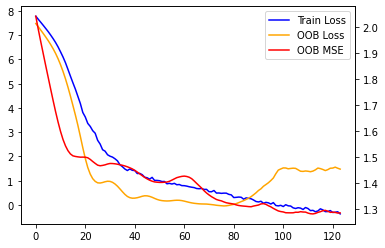

Bootstrap iteration 15 at time 2022-07-05 17:59:27.951570
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -6.730329990386963, MSE: 1.7256795167922974
Epoch: 0, Loss: 7.264317512512207, OOB Loss: 6.942783832550049, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.460556983947754, MSE: 1.3655728101730347
Epoch: 40, Loss: 1.5758121013641357, OOB Loss: 0.28521299362182617, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.480638027191162, MSE: 1.2926663160324097
Epoch: 80, Loss: 0.281787633895874, OOB Loss: 0.33142852783203125, LR: 0.00040823971994699836
Early stopped, best epoch: 59, train loss: 0.6933050155639648, best OOB loss: 0.13785338401794434, LR: 0.00037870617638352256


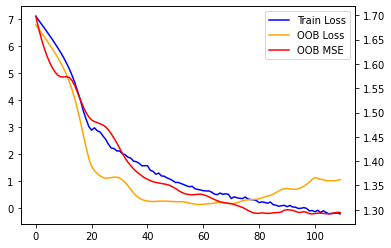

Bootstrap iteration 16 at time 2022-07-05 17:59:39.944865
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -6.21148157119751, MSE: 4.817753314971924
Epoch: 0, Loss: 6.751886367797852, OOB Loss: 6.803138256072998, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.2500839233398438, MSE: 2.9316389560699463
Epoch: 40, Loss: 1.0092525482177734, OOB Loss: 2.3340258598327637, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 1.1810989379882812, MSE: 3.336291551589966
Epoch: 80, Loss: 0.016824722290039062, OOB Loss: 1.7574257850646973, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.207887887954712, MSE: 3.505162477493286
Epoch: 120, Loss: -0.618786096572876, OOB Loss: 2.489800214767456, LR: 0.00036934432610923556
Early stopped, best epoch: 86, train loss: -0.0666191577911377, best OOB loss: 1.744534969329834, LR: 0.0003539572447587195


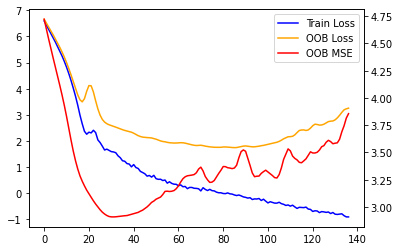

Bootstrap iteration 17 at time 2022-07-05 17:59:55.073586
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.380089282989502, MSE: 4.18304443359375
Epoch: 0, Loss: 7.761047840118408, OOB Loss: 7.765400409698486, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.9992839097976685, MSE: 3.6318531036376953
Epoch: 40, Loss: 1.1141014099121094, OOB Loss: 4.954136848449707, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.684645652770996, MSE: 3.769484758377075
Epoch: 80, Loss: 0.20025920867919922, OOB Loss: 2.673949718475342, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.200777530670166, MSE: 3.7146284580230713
Epoch: 120, Loss: -0.25693750381469727, OOB Loss: 2.3976759910583496, LR: 0.00036934432610923556
OOB Mean Log Det Precision: 3.7942826747894287, MSE: 4.1310625076293945
Epoch: 160, Loss: -0.7461044788360596, OOB Loss: 3.6075942516326904, LR: 0.0003341547246965484
Early stopped, best epoch: 121, train loss: -0.23594021797180176, best OOB

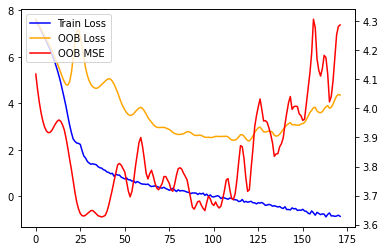

Bootstrap iteration 18 at time 2022-07-05 18:00:13.079656
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.765885829925537, MSE: 2.498206615447998
Epoch: 0, Loss: 8.201926231384277, OOB Loss: 7.942265510559082, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.2740025520324707, MSE: 1.7588527202606201
Epoch: 40, Loss: 1.5536751747131348, OOB Loss: 0.7415022850036621, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.9830007553100586, MSE: 1.7593913078308105
Epoch: 80, Loss: 0.3409848213195801, OOB Loss: 0.14826655387878418, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.564568042755127, MSE: 1.7241034507751465
Epoch: 120, Loss: -0.12083625793457031, OOB Loss: 0.053139686584472656, LR: 0.00036934432610923556
OOB Mean Log Det Precision: 4.2020039558410645, MSE: 1.7600493431091309
Epoch: 160, Loss: -0.5634176731109619, OOB Loss: 0.20083189010620117, LR: 0.0003341547246965484
Early stopped, best epoch: 139, train loss: -0.35574817657470703, 

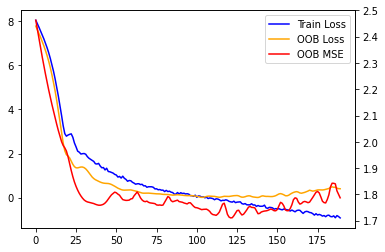

Bootstrap iteration 19 at time 2022-07-05 18:00:33.903381
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -6.743401050567627, MSE: 1.5622637271881104
Epoch: 0, Loss: 7.3190178871154785, OOB Loss: 6.90382194519043, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.558049201965332, MSE: 1.1738200187683105
Epoch: 40, Loss: 1.8336976766586304, OOB Loss: 0.17499792575836182, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.401337146759033, MSE: 1.1617722511291504
Epoch: 80, Loss: 0.2934110164642334, OOB Loss: -0.03385591506958008, LR: 0.00040823971994699836
Early stopped, best epoch: 99, train loss: -0.016434669494628906, best OOB loss: -0.17277002334594727, LR: 0.0003863662237861692


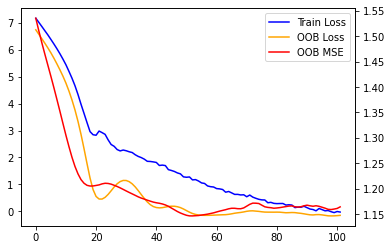

Time 0, 2022-07-05 18:00:46.228620
Time 5, 2022-07-05 18:05:46.370603
Time 10, 2022-07-05 18:10:42.301975
Time 15, 2022-07-05 18:15:38.852455
Time 20, 2022-07-05 18:20:34.312355
Time 25, 2022-07-05 18:25:35.162262
Size of x_mat before appending MARX (731, 6)
Size of x_mat_marx (731, 24)
x_mat_all size (731, 30)
Size of X_train afer appending time (731, 153) Time dummy setting: 2
x_pos {'inf': [0, 3], 'unrate': [1, 4], 'DGS3': [2, 5]}
Size of X_train (701, 153)
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 1

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


Epoch: 0, Loss: 0.871242880821228, OOB Loss: 0.9724027514457703
Epoch: 40, Loss: 0.5771660208702087, OOB Loss: 0.8409295082092285
Early stopped, best epoch: 16, train loss: 0.6413688063621521, best OOB loss: 0.8143616914749146, LR: 0.00042174262878710785


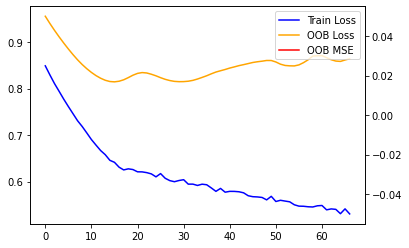

Bootstrap iteration 1 at time 2022-07-05 18:30:51.983882
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.9579199552536011, OOB Loss: 0.624178409576416
Epoch: 40, Loss: 0.6672884821891785, OOB Loss: 0.5090147852897644
Early stopped, best epoch: 25, train loss: 0.7125396728515625, best OOB loss: 0.48045724630355835, LR: 0.00041234776026425864


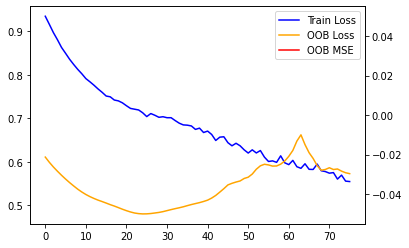

Bootstrap iteration 2 at time 2022-07-05 18:31:08.230135
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.9150471687316895, OOB Loss: 1.3058183193206787
Epoch: 40, Loss: 0.5756763219833374, OOB Loss: 0.825851559638977
Epoch: 80, Loss: 0.48081886768341064, OOB Loss: 0.934935450553894
Early stopped, best epoch: 52, train loss: 0.5553721189498901, best OOB loss: 0.8208075761795044, LR: 0.0003854003082267038


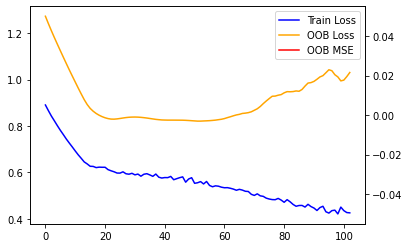

Bootstrap iteration 3 at time 2022-07-05 18:31:30.269979
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.1369845867156982, OOB Loss: 0.6526628732681274
Epoch: 40, Loss: 0.6650262475013733, OOB Loss: 0.5166330337524414
Epoch: 80, Loss: 0.5926231741905212, OOB Loss: 0.5283448696136475
Early stopped, best epoch: 36, train loss: 0.6686110496520996, best OOB loss: 0.5141118764877319, LR: 0.000401148883612376


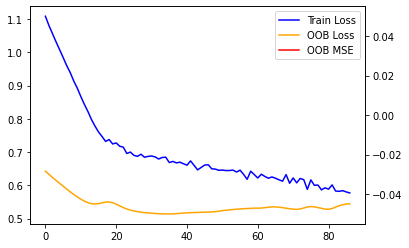

Bootstrap iteration 4 at time 2022-07-05 18:31:48.762992
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.0904042720794678, OOB Loss: 0.8795408010482788
Epoch: 40, Loss: 0.6523648500442505, OOB Loss: 0.604495644569397
Epoch: 80, Loss: 0.5707514882087708, OOB Loss: 0.613445520401001
Early stopped, best epoch: 50, train loss: 0.635262668132782, best OOB loss: 0.5960776209831238, LR: 0.00038733456018663577


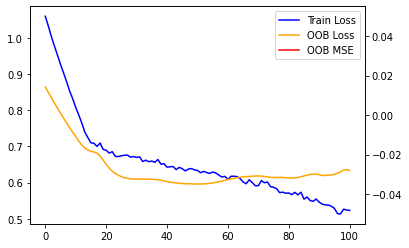

Bootstrap iteration 5 at time 2022-07-05 18:32:10.346195
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.0563312768936157, OOB Loss: 1.0016125440597534
Epoch: 40, Loss: 0.6467468738555908, OOB Loss: 0.6562796831130981
Epoch: 80, Loss: 0.5688873529434204, OOB Loss: 0.6542216539382935
Epoch: 120, Loss: 0.47849225997924805, OOB Loss: 0.6258470416069031
Early stopped, best epoch: 107, train loss: 0.5058356523513794, best OOB loss: 0.6165364980697632, LR: 0.0003358317846712504


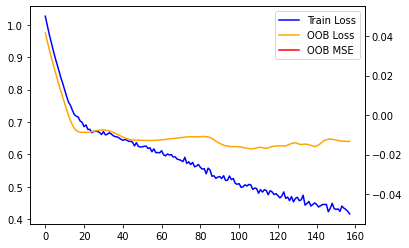

Bootstrap iteration 6 at time 2022-07-05 18:32:43.902512
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.0924098491668701, OOB Loss: 0.4139481484889984
Epoch: 40, Loss: 0.7231644988059998, OOB Loss: 0.4140259623527527
Epoch: 80, Loss: 0.6105811595916748, OOB Loss: 0.3838784694671631
Epoch: 120, Loss: 0.5362802743911743, OOB Loss: 0.3711313009262085
Epoch: 160, Loss: 0.4815630316734314, OOB Loss: 0.37624236941337585
Early stopped, best epoch: 128, train loss: 0.5166294574737549, best OOB loss: 0.3686665892601013, LR: 0.0003186344940399721


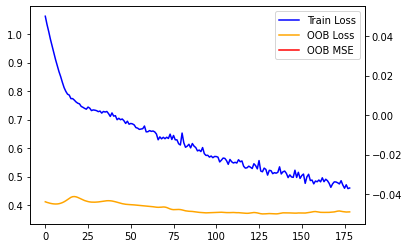

Bootstrap iteration 7 at time 2022-07-05 18:33:20.917569
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.9865206480026245, OOB Loss: 0.7150832414627075
Epoch: 40, Loss: 0.6747735738754272, OOB Loss: 0.48853373527526855
Epoch: 80, Loss: 0.5753545761108398, OOB Loss: 0.43554553389549255
Epoch: 120, Loss: 0.5060997009277344, OOB Loss: 0.42865049839019775
Epoch: 160, Loss: 0.42648565769195557, OOB Loss: 0.4377503991127014
Early stopped, best epoch: 113, train loss: 0.5099046230316162, best OOB loss: 0.4166460633277893, LR: 0.00033082568738014177


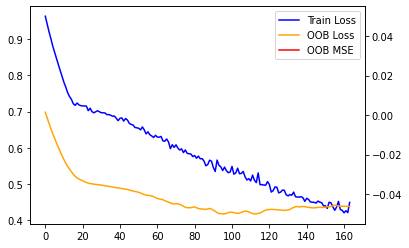

Bootstrap iteration 8 at time 2022-07-05 18:33:57.213485
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.0327839851379395, OOB Loss: 0.6631191968917847
Epoch: 40, Loss: 0.6840958595275879, OOB Loss: 0.43071526288986206
Epoch: 80, Loss: 0.5998492240905762, OOB Loss: 0.4042385518550873
Epoch: 120, Loss: 0.4922311305999756, OOB Loss: 0.4284157454967499
Early stopped, best epoch: 103, train loss: 0.5295580625534058, best OOB loss: 0.39872321486473083, LR: 0.0003392111974129261


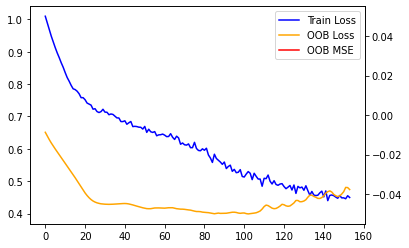

Bootstrap iteration 9 at time 2022-07-05 18:34:29.933436
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.9019426703453064, OOB Loss: 0.9334124326705933
Epoch: 40, Loss: 0.6358685493469238, OOB Loss: 0.6698319911956787
Early stopped, best epoch: 24, train loss: 0.6720741987228394, best OOB loss: 0.6363895535469055, LR: 0.00041441725643859886


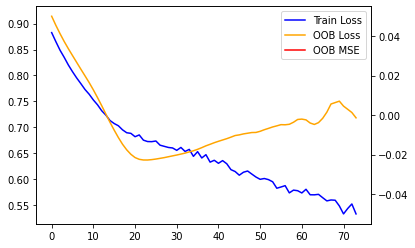

Bootstrap iteration 10 at time 2022-07-05 18:34:45.742164
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.9625970721244812, OOB Loss: 1.1370289325714111
Epoch: 40, Loss: 0.6005650758743286, OOB Loss: 0.7419679164886475
Epoch: 80, Loss: 0.5330309271812439, OOB Loss: 0.8013267517089844
Early stopped, best epoch: 60, train loss: 0.5795620679855347, best OOB loss: 0.7308027744293213, LR: 0.00037775941094256375


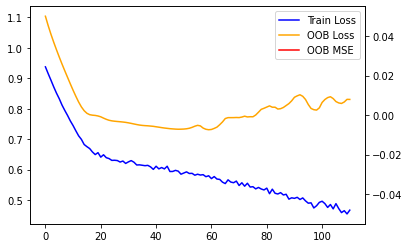

Bootstrap iteration 11 at time 2022-07-05 18:35:09.446622
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.2170751094818115, OOB Loss: 0.4806169867515564
Epoch: 40, Loss: 0.7010743618011475, OOB Loss: 0.42338258028030396
Epoch: 80, Loss: 0.6281951665878296, OOB Loss: 0.4001025855541229
Epoch: 120, Loss: 0.5525273680686951, OOB Loss: 0.3910255432128906
Epoch: 160, Loss: 0.511242151260376, OOB Loss: 0.4078214168548584
Early stopped, best epoch: 119, train loss: 0.5460411310195923, best OOB loss: 0.39091938734054565, LR: 0.0003258942137882537


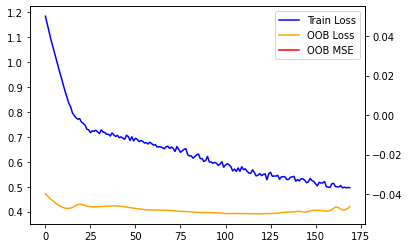

Bootstrap iteration 12 at time 2022-07-05 18:35:45.074489
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.1558079719543457, OOB Loss: 0.6705571413040161
Epoch: 40, Loss: 0.6811708211898804, OOB Loss: 0.5097424983978271
Epoch: 80, Loss: 0.5934523940086365, OOB Loss: 0.49137529730796814
Epoch: 120, Loss: 0.5060724020004272, OOB Loss: 0.4890623986721039
Epoch: 160, Loss: 0.4540019929409027, OOB Loss: 0.48760315775871277
Early stopped, best epoch: 142, train loss: 0.4728574752807617, best OOB loss: 0.48098787665367126, LR: 0.00030766171028041774


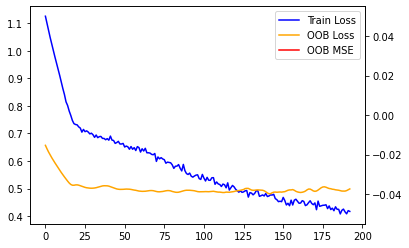

Bootstrap iteration 13 at time 2022-07-05 18:36:24.503706
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.1255569458007812, OOB Loss: 0.49711447954177856
Epoch: 40, Loss: 0.7123023271560669, OOB Loss: 0.4013582170009613
Epoch: 80, Loss: 0.6174964308738708, OOB Loss: 0.35944122076034546
Epoch: 120, Loss: 0.5451964735984802, OOB Loss: 0.35266023874282837
Epoch: 160, Loss: 0.4831430912017822, OOB Loss: 0.35654157400131226
Early stopped, best epoch: 124, train loss: 0.5484238862991333, best OOB loss: 0.3507862091064453, LR: 0.0003218408536469109


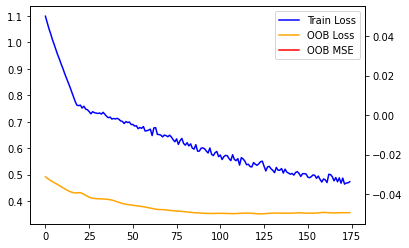

Bootstrap iteration 14 at time 2022-07-05 18:37:02.976091
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.84209144115448, OOB Loss: 1.5634359121322632
Epoch: 40, Loss: 0.5600727200508118, OOB Loss: 0.9288734197616577
Epoch: 80, Loss: 0.5031610727310181, OOB Loss: 0.8900965452194214
Epoch: 120, Loss: 0.41193267703056335, OOB Loss: 1.2177486419677734
Early stopped, best epoch: 76, train loss: 0.5080267190933228, best OOB loss: 0.8862107992172241, LR: 0.0003629290753641537


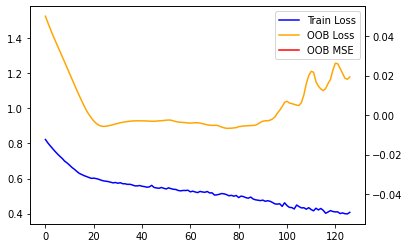

Bootstrap iteration 15 at time 2022-07-05 18:37:27.780484
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.7309918403625488, OOB Loss: 1.7920145988464355
Epoch: 40, Loss: 0.49073123931884766, OOB Loss: 1.3179725408554077
Early stopped, best epoch: 26, train loss: 0.5096308588981628, best OOB loss: 1.2996405363082886, LR: 0.000411316890863598


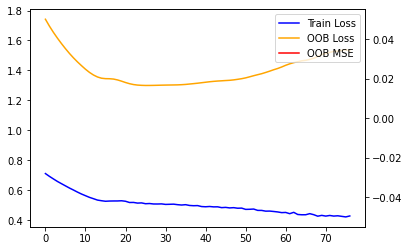

Bootstrap iteration 16 at time 2022-07-05 18:37:43.577957
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.1650848388671875, OOB Loss: 0.48553818464279175
Epoch: 40, Loss: 0.7145277261734009, OOB Loss: 0.40059131383895874
Epoch: 80, Loss: 0.6002601981163025, OOB Loss: 0.40225642919540405
Epoch: 120, Loss: 0.5161426663398743, OOB Loss: 0.4061899185180664
Early stopped, best epoch: 90, train loss: 0.5849518775939941, best OOB loss: 0.39932501316070557, LR: 0.0003504309235993095


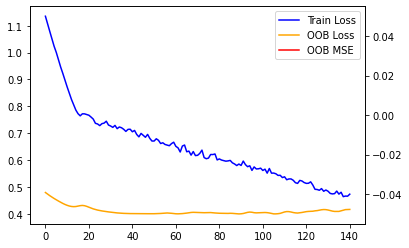

Bootstrap iteration 17 at time 2022-07-05 18:38:11.601160
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.103635549545288, OOB Loss: 0.4624910354614258
Epoch: 40, Loss: 0.7280354499816895, OOB Loss: 0.3742900490760803
Epoch: 80, Loss: 0.6323423981666565, OOB Loss: 0.3564393222332001
Epoch: 120, Loss: 0.529762864112854, OOB Loss: 0.3425954282283783
Epoch: 160, Loss: 0.44851547479629517, OOB Loss: 0.3582801818847656
Early stopped, best epoch: 139, train loss: 0.4870893359184265, best OOB loss: 0.33568844199180603, LR: 0.0003099807586747022


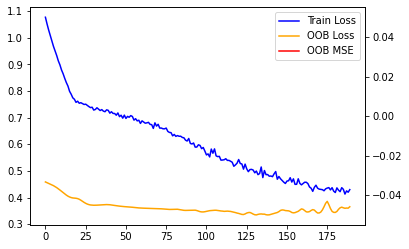

Bootstrap iteration 18 at time 2022-07-05 18:38:50.752715
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.9192403554916382, OOB Loss: 1.1244313716888428
Epoch: 40, Loss: 0.6430296301841736, OOB Loss: 0.6976157426834106
Epoch: 80, Loss: 0.5378537178039551, OOB Loss: 0.7446540594100952
Early stopped, best epoch: 54, train loss: 0.6207537651062012, best OOB loss: 0.6800144910812378, LR: 0.00038443680745613704


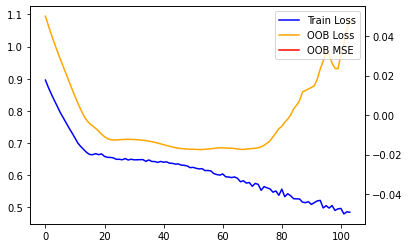

Bootstrap iteration 19 at time 2022-07-05 18:39:12.926251
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.8919323682785034, OOB Loss: 0.8985397219657898
Epoch: 40, Loss: 0.6059988737106323, OOB Loss: 0.7297604084014893
Epoch: 80, Loss: 0.5096556544303894, OOB Loss: 0.7570204138755798
Early stopped, best epoch: 59, train loss: 0.5464208126068115, best OOB loss: 0.7005822658538818, LR: 0.00037870617638352256


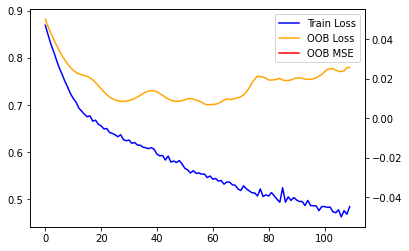

Time 0, 2022-07-05 18:39:37.654136
Time 5, 2022-07-05 18:44:43.701062
Time 10, 2022-07-05 18:49:46.506778
Time 15, 2022-07-05 18:54:45.692995
Time 20, 2022-07-05 18:59:42.388455
Time 25, 2022-07-05 19:04:37.799014
Size of x_mat before appending MARX (731, 6)
Size of x_mat_marx (731, 24)
x_mat_all size (731, 30)
Size of X_train afer appending time (731, 153) Time dummy setting: 2
x_pos {'inf': [0, 3], 'unrate': [1, 4], 'DGS3': [2, 5]}
Size of X_train (701, 153)
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 1

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


OOB Mean Log Det Precision: 2.2321813106536865, MSE: 1.8296784162521362
Epoch: 40, Loss: 1.4372344017028809, OOB Loss: 1.0331690311431885, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.1812424659729004, MSE: 1.693294882774353
Epoch: 80, Loss: 0.263181209564209, OOB Loss: 0.436643123626709, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.840118169784546, MSE: 1.744116187095642
Epoch: 120, Loss: -0.20762133598327637, OOB Loss: 0.4985196590423584, LR: 0.00036934432610923556
Early stopped, best epoch: 90, train loss: 0.08985686302185059, best OOB loss: 0.3154785633087158, LR: 0.0003504309235993095


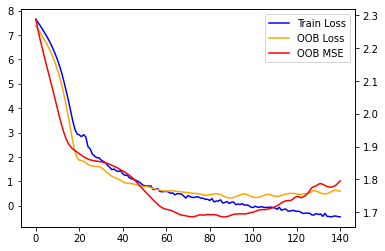

Bootstrap iteration 1 at time 2022-07-05 19:09:50.337135
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.838241100311279, MSE: 2.061113119125366
Epoch: 0, Loss: 8.27108097076416, OOB Loss: 7.9994378089904785, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.036597728729248, MSE: 1.8226937055587769
Epoch: 40, Loss: 1.458311676979065, OOB Loss: 0.888925313949585, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.094480276107788, MSE: 1.8013560771942139
Epoch: 80, Loss: 0.2655925750732422, OOB Loss: 0.4777817726135254, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 4.0171027183532715, MSE: 1.8770630359649658
Epoch: 120, Loss: -0.4225623607635498, OOB Loss: 1.7879376411437988, LR: 0.00036934432610923556
Early stopped, best epoch: 86, train loss: 0.21373653411865234, best OOB loss: 0.4456501007080078, LR: 0.0003539572447587195


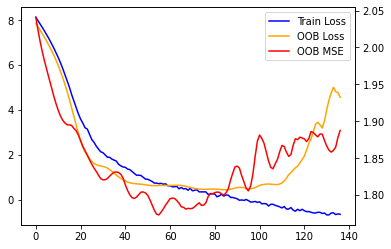

Bootstrap iteration 2 at time 2022-07-05 19:10:05.319529
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.279270172119141, MSE: 3.012044906616211
Epoch: 0, Loss: 7.765985488891602, OOB Loss: 7.545841217041016, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.4104104042053223, MSE: 2.363285541534424
Epoch: 40, Loss: 1.1393482685089111, OOB Loss: 1.7807612419128418, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 1.4735673666000366, MSE: 2.3229029178619385
Epoch: 80, Loss: 0.09753966331481934, OOB Loss: 1.4739373922348022, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.5307021141052246, MSE: 2.324276924133301
Epoch: 120, Loss: -0.5150661468505859, OOB Loss: 1.7497491836547852, LR: 0.00036934432610923556
Early stopped, best epoch: 79, train loss: 0.16896319389343262, best OOB loss: 1.4725743532180786, LR: 0.00036021390654831885


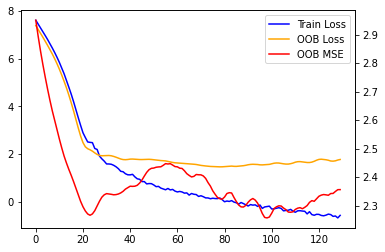

Bootstrap iteration 3 at time 2022-07-05 19:10:19.416496
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.50991678237915, MSE: 2.4422521591186523
Epoch: 0, Loss: 7.962369441986084, OOB Loss: 7.705607891082764, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.3652706146240234, MSE: 1.8085978031158447
Epoch: 40, Loss: 1.2701934576034546, OOB Loss: 0.9867823123931885, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.126471757888794, MSE: 1.7582063674926758
Epoch: 80, Loss: 0.07787775993347168, OOB Loss: 0.3851914405822754, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.3963890075683594, MSE: 1.6884769201278687
Epoch: 120, Loss: -0.48622846603393555, OOB Loss: 0.4566173553466797, LR: 0.00036934432610923556
Early stopped, best epoch: 83, train loss: 0.04691505432128906, best OOB loss: 0.372267484664917, LR: 0.00035662525300503295


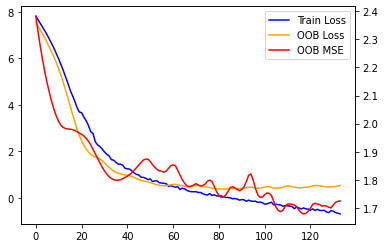

Bootstrap iteration 4 at time 2022-07-05 19:10:33.908183
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -6.167763710021973, MSE: 5.277920722961426
Epoch: 0, Loss: 6.691259384155273, OOB Loss: 7.1927690505981445, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.7883143424987793, MSE: 4.39662504196167
Epoch: 40, Loss: 0.9323606491088867, OOB Loss: 5.993010997772217, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.879284381866455, MSE: 3.8659965991973877
Epoch: 80, Loss: 0.01172018051147461, OOB Loss: 2.5928711891174316, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.2946059703826904, MSE: 4.433101177215576
Epoch: 120, Loss: -0.6639349460601807, OOB Loss: 3.682762384414673, LR: 0.00036934432610923556
Early stopped, best epoch: 76, train loss: 0.023477554321289062, best OOB loss: 2.4971084594726562, LR: 0.0003629290753641537


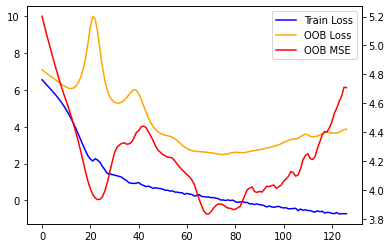

Bootstrap iteration 5 at time 2022-07-05 19:10:47.230082
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.412894248962402, MSE: 2.79156756401062
Epoch: 0, Loss: 7.85021448135376, OOB Loss: 7.6500020027160645, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.8840986490249634, MSE: 2.22581148147583
Epoch: 40, Loss: 1.1578750610351562, OOB Loss: 1.7417062520980835, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.6941871643066406, MSE: 2.128248453140259
Epoch: 80, Loss: 0.19462013244628906, OOB Loss: 1.3441162109375, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.8678839206695557, MSE: 2.0638601779937744
Epoch: 120, Loss: -0.43277978897094727, OOB Loss: 1.617224931716919, LR: 0.00036934432610923556
Early stopped, best epoch: 95, train loss: -0.06446146965026855, best OOB loss: 1.2229633331298828, LR: 0.0003460723843006206


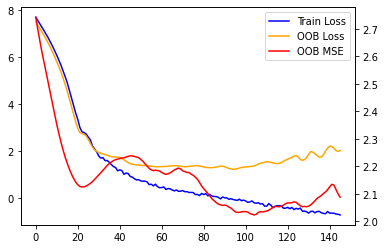

Bootstrap iteration 6 at time 2022-07-05 19:11:02.629984
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.327221393585205, MSE: 2.0818283557891846
Epoch: 0, Loss: 7.7860212326049805, OOB Loss: 7.530886173248291, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.2814289331436157, MSE: 1.7417279481887817
Epoch: 40, Loss: 1.3163352012634277, OOB Loss: 1.2628175020217896, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.5285069942474365, MSE: 1.5500085353851318
Epoch: 80, Loss: 0.03763008117675781, OOB Loss: 1.1080598831176758, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.051724433898926, MSE: 1.517281174659729
Epoch: 120, Loss: -0.7242379188537598, OOB Loss: 1.8713784217834473, LR: 0.00036934432610923556
Early stopped, best epoch: 80, train loss: 0.03763008117675781, best OOB loss: 1.1080598831176758, LR: 0.00035931337178194805


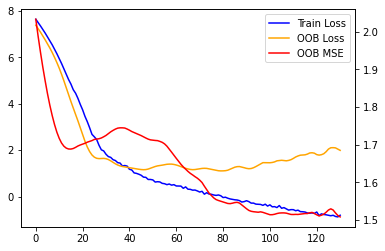

Bootstrap iteration 7 at time 2022-07-05 19:11:16.182676
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.49470853805542, MSE: 1.6033753156661987
Epoch: 0, Loss: 7.931239128112793, OOB Loss: 7.626953601837158, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.9109035730361938, MSE: 1.3486099243164062
Epoch: 40, Loss: 1.5698658227920532, OOB Loss: 0.14853394031524658, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.046790361404419, MSE: 1.3979116678237915
Epoch: 80, Loss: 0.32155871391296387, OOB Loss: -0.10045003890991211, LR: 0.00040823971994699836
Early stopped, best epoch: 62, train loss: 0.6989588737487793, best OOB loss: -0.358809232711792, LR: 0.0003883053234953742


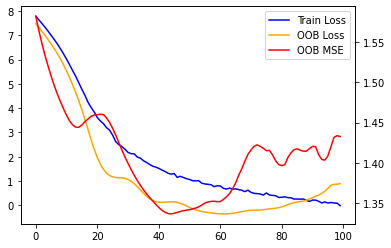

Bootstrap iteration 8 at time 2022-07-05 19:11:27.349901
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.358699798583984, MSE: 2.274012804031372
Epoch: 0, Loss: 7.85129451751709, OOB Loss: 7.560304164886475, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 3.0052714347839355, MSE: 1.7721189260482788
Epoch: 40, Loss: 1.2872674465179443, OOB Loss: 0.9112451076507568, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 4.089892864227295, MSE: 1.7842415571212769
Epoch: 80, Loss: 0.005581378936767578, OOB Loss: 2.1195273399353027, LR: 0.00040823971994699836
Early stopped, best epoch: 43, train loss: 1.0038864612579346, best OOB loss: 0.8272984027862549, LR: 0.00039418121010946174


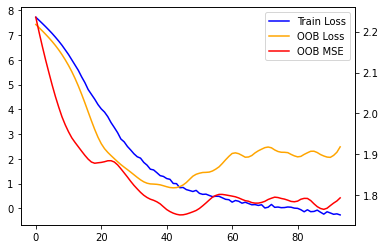

Bootstrap iteration 9 at time 2022-07-05 19:11:37.456489
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.578774452209473, MSE: 3.245697259902954
Epoch: 0, Loss: 8.014172554016113, OOB Loss: 7.8206562995910645, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.205160617828369, MSE: 2.1792759895324707
Epoch: 40, Loss: 1.4745995998382568, OOB Loss: 1.6325061321258545, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.5103163719177246, MSE: 2.1316239833831787
Epoch: 80, Loss: 0.20766735076904297, OOB Loss: 0.9684054851531982, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.435422658920288, MSE: 2.3992109298706055
Epoch: 120, Loss: -0.4700193405151367, OOB Loss: 1.5484883785247803, LR: 0.00036934432610923556
Early stopped, best epoch: 80, train loss: 0.20766735076904297, best OOB loss: 0.9684054851531982, LR: 0.00035931337178194805


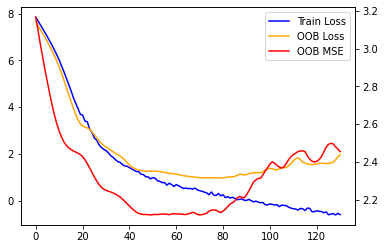

Bootstrap iteration 10 at time 2022-07-05 19:11:51.920654
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.425214767456055, MSE: 2.3177826404571533
Epoch: 0, Loss: 7.947334289550781, OOB Loss: 7.635678291320801, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.371400833129883, MSE: 1.781536340713501
Epoch: 40, Loss: 1.4060499668121338, OOB Loss: 1.594921588897705, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.182917356491089, MSE: 1.8507723808288574
Epoch: 80, Loss: 0.2230973243713379, OOB Loss: 1.0872023105621338, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.962747573852539, MSE: 1.784485101699829
Epoch: 120, Loss: -0.35437560081481934, OOB Loss: 2.7305073738098145, LR: 0.00036934432610923556
Early stopped, best epoch: 70, train loss: 0.4639272689819336, best OOB loss: 0.9085924625396729, LR: 0.0003684209652939625


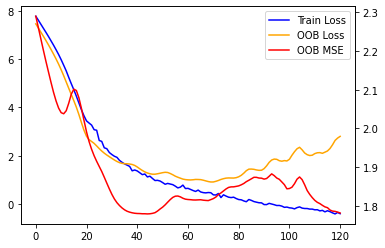

Bootstrap iteration 11 at time 2022-07-05 19:12:04.893975
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.912777900695801, MSE: 2.7256052494049072
Epoch: 0, Loss: 8.33263111114502, OOB Loss: 8.104390144348145, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.3341779708862305, MSE: 1.8173351287841797
Epoch: 40, Loss: 1.694560170173645, OOB Loss: 0.7459409236907959, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.3922505378723145, MSE: 1.9142872095108032
Epoch: 80, Loss: 0.41686224937438965, OOB Loss: 0.5922443866729736, LR: 0.00040823971994699836
Early stopped, best epoch: 60, train loss: 0.7468113899230957, best OOB loss: 0.5472583770751953, LR: 0.00037775941094256375


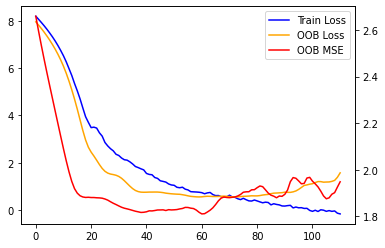

Bootstrap iteration 12 at time 2022-07-05 19:12:17.000204
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -6.463535785675049, MSE: 2.9244372844696045
Epoch: 0, Loss: 7.016383647918701, OOB Loss: 6.798181056976318, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.848551034927368, MSE: 2.3383872509002686
Epoch: 40, Loss: 1.1057438850402832, OOB Loss: 1.9797847270965576, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.4540038108825684, MSE: 2.3309152126312256
Epoch: 80, Loss: 0.013527631759643555, OOB Loss: 1.7965035438537598, LR: 0.00040823971994699836
Early stopped, best epoch: 48, train loss: 0.7054569721221924, best OOB loss: 1.5906407833099365, LR: 0.0003892785197948613


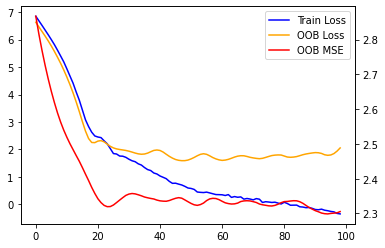

Bootstrap iteration 13 at time 2022-07-05 19:12:27.535854
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.871128559112549, MSE: 3.774519443511963
Epoch: 0, Loss: 8.21013069152832, OOB Loss: 8.173386573791504, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.9730137586593628, MSE: 3.0678465366363525
Epoch: 40, Loss: 1.1156044006347656, OOB Loss: 2.0246376991271973, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.498279333114624, MSE: 2.5188653469085693
Epoch: 80, Loss: 0.14655542373657227, OOB Loss: 1.0257248878479004, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.170778274536133, MSE: 2.7067549228668213
Epoch: 120, Loss: -0.4693605899810791, OOB Loss: 0.9978604316711426, LR: 0.00036934432610923556
OOB Mean Log Det Precision: 3.6301658153533936, MSE: 3.1183347702026367
Epoch: 160, Loss: -0.9390053749084473, OOB Loss: 1.6003901958465576, LR: 0.0003341547246965484
Early stopped, best epoch: 109, train loss: -0.3077864646911621, best OO

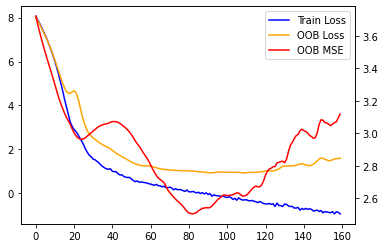

Bootstrap iteration 14 at time 2022-07-05 19:12:44.929395
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.975301742553711, MSE: 3.746149778366089
Epoch: 0, Loss: 8.35584545135498, OOB Loss: 8.245701789855957, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.7237920761108398, MSE: 2.573918581008911
Epoch: 40, Loss: 1.1493688821792603, OOB Loss: 1.8454101085662842, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.641172409057617, MSE: 2.7190611362457275
Epoch: 80, Loss: -0.1029958724975586, OOB Loss: 1.6655349731445312, LR: 0.00040823971994699836
Early stopped, best epoch: 65, train loss: 0.2355034351348877, best OOB loss: 1.5960078239440918, LR: 0.00037306096931780195


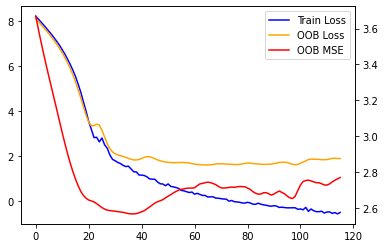

Bootstrap iteration 15 at time 2022-07-05 19:12:57.321284
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -6.975776672363281, MSE: 4.050402641296387
Epoch: 0, Loss: 7.432451248168945, OOB Loss: 7.419441223144531, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.7305352687835693, MSE: 2.9478092193603516
Epoch: 40, Loss: 1.0914735794067383, OOB Loss: 2.194133996963501, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.5431647300720215, MSE: 3.326493501663208
Epoch: 80, Loss: -0.062262535095214844, OOB Loss: 1.4545400142669678, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.0794849395751953, MSE: 3.3177828788757324
Epoch: 120, Loss: -0.42760562896728516, OOB Loss: 1.4937143325805664, LR: 0.00036934432610923556
Early stopped, best epoch: 101, train loss: -0.3102998733520508, best OOB loss: 1.2691154479980469, LR: 0.00034091363487709353


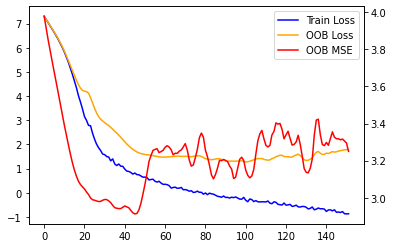

Bootstrap iteration 16 at time 2022-07-05 19:13:13.535632
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.537571430206299, MSE: 6.704060077667236
Epoch: 0, Loss: 7.8356475830078125, OOB Loss: 8.283767700195312, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.1406102180480957, MSE: 4.913618087768555
Epoch: 40, Loss: 0.40786099433898926, OOB Loss: 9.126457214355469, LR: 0.00045123116063007594
Early stopped, best epoch: 14, train loss: 5.2000627517700195, best OOB loss: 7.122371673583984, LR: 0.0004238592760468668


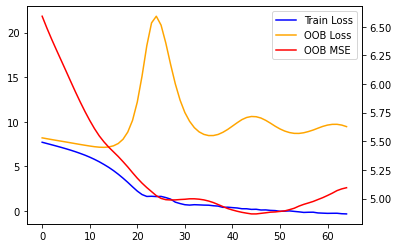

Bootstrap iteration 17 at time 2022-07-05 19:13:20.259355
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.1370415687561035, MSE: 1.9257371425628662
Epoch: 0, Loss: 7.600985050201416, OOB Loss: 7.331570625305176, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.9306927919387817, MSE: 1.661293625831604
Epoch: 40, Loss: 1.2877535820007324, OOB Loss: 0.699008584022522, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.5819082260131836, MSE: 1.5261132717132568
Epoch: 80, Loss: 0.19928598403930664, OOB Loss: 0.40860724449157715, LR: 0.00040823971994699836
Early stopped, best epoch: 53, train loss: 0.7256195545196533, best OOB loss: 0.1950976848602295, LR: 0.00038443680745613704


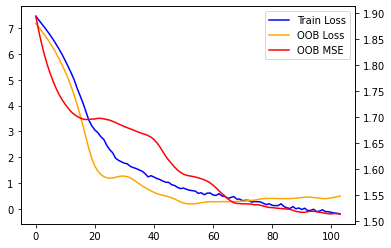

Bootstrap iteration 18 at time 2022-07-05 19:13:31.462190
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.361294269561768, MSE: 5.9264421463012695
Epoch: 0, Loss: 7.741405963897705, OOB Loss: 7.89979362487793, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.315673828125, MSE: 3.754310131072998
Epoch: 40, Loss: 0.6947762966156006, OOB Loss: 3.996293544769287, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.3443236351013184, MSE: 3.950165033340454
Epoch: 80, Loss: -0.2058403491973877, OOB Loss: 3.0441102981567383, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.1758899688720703, MSE: 4.143431186676025
Epoch: 120, Loss: -0.8303647041320801, OOB Loss: 5.597042083740234, LR: 0.00036934432610923556
Early stopped, best epoch: 73, train loss: -0.09466958045959473, best OOB loss: 2.8601901531219482, LR: 0.0003656647101907795


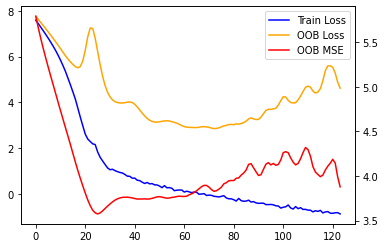

Bootstrap iteration 19 at time 2022-07-05 19:13:44.502037
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -6.918824195861816, MSE: 3.627770185470581
Epoch: 0, Loss: 7.423373699188232, OOB Loss: 7.335806846618652, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.465565800666809, MSE: 2.6602940559387207
Epoch: 40, Loss: 1.148573875427246, OOB Loss: 2.113560676574707, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.0471925735473633, MSE: 2.6298270225524902
Epoch: 80, Loss: -0.10308647155761719, OOB Loss: 1.5381810665130615, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.4769985675811768, MSE: 2.9469172954559326
Epoch: 120, Loss: -0.5244295597076416, OOB Loss: 1.590160608291626, LR: 0.00036934432610923556
Early stopped, best epoch: 79, train loss: -0.029393911361694336, best OOB loss: 1.5374634265899658, LR: 0.00036021390654831885


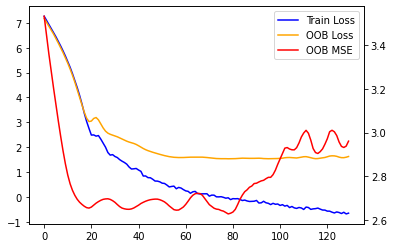

Time 0, 2022-07-05 19:13:59.815083
Time 5, 2022-07-05 19:18:56.095530
Time 10, 2022-07-05 19:23:53.368461
Time 15, 2022-07-05 19:28:50.443401
Time 20, 2022-07-05 19:33:45.916196
Time 25, 2022-07-05 19:38:40.151241
Size of x_mat before appending MARX (731, 6)
Size of x_mat_marx (731, 24)
x_mat_all size (731, 30)
Size of X_train afer appending time (731, 153) Time dummy setting: 2
x_pos {'inf': [0, 3], 'unrate': [1, 4], 'DGS3': [2, 5]}
Size of X_train (701, 153)
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 1

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


Epoch: 0, Loss: 0.9442771673202515, OOB Loss: 1.1727299690246582
Epoch: 40, Loss: 0.580407977104187, OOB Loss: 0.8317441940307617
Epoch: 80, Loss: 0.49261975288391113, OOB Loss: 0.9343751668930054
Early stopped, best epoch: 36, train loss: 0.5925072431564331, best OOB loss: 0.8295921683311462, LR: 0.000401148883612376


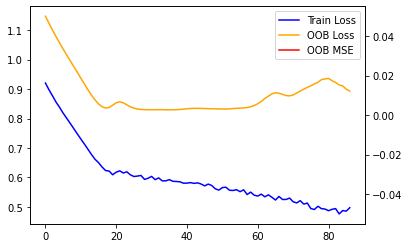

Bootstrap iteration 1 at time 2022-07-05 19:43:50.194055
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.1260933876037598, OOB Loss: 0.7436014413833618
Epoch: 40, Loss: 0.6951128840446472, OOB Loss: 0.47899556159973145
Epoch: 80, Loss: 0.6094600558280945, OOB Loss: 0.4374622702598572
Epoch: 120, Loss: 0.5347633361816406, OOB Loss: 0.43242114782333374
Early stopped, best epoch: 106, train loss: 0.5620158910751343, best OOB loss: 0.41795212030410767, LR: 0.00033667346834210566


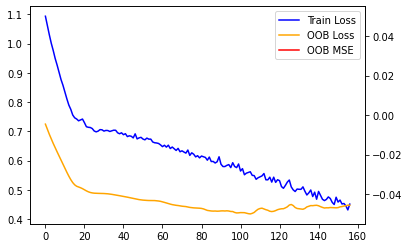

Bootstrap iteration 2 at time 2022-07-05 19:44:21.646245
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.0042269229888916, OOB Loss: 0.4903028905391693
Epoch: 40, Loss: 0.7109651565551758, OOB Loss: 0.40615949034690857
Epoch: 80, Loss: 0.6017771363258362, OOB Loss: 0.40017253160476685
Early stopped, best epoch: 67, train loss: 0.6347113847732544, best OOB loss: 0.39665350317955017, LR: 0.00037119799610227123


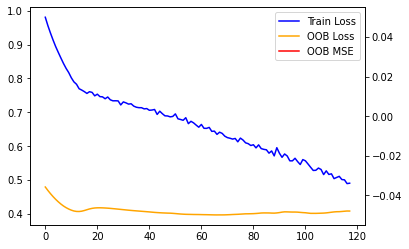

Bootstrap iteration 3 at time 2022-07-05 19:44:44.548529
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.913852870464325, OOB Loss: 1.3657492399215698
Epoch: 40, Loss: 0.5493662357330322, OOB Loss: 1.008966326713562
Epoch: 80, Loss: 0.44986194372177124, OOB Loss: 1.15230131149292
Early stopped, best epoch: 52, train loss: 0.5263141393661499, best OOB loss: 0.9980210065841675, LR: 0.0003854003082267038


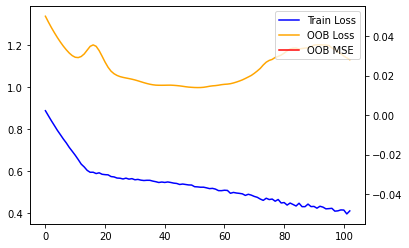

Bootstrap iteration 4 at time 2022-07-05 19:45:04.672864
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.8818345069885254, OOB Loss: 1.5466808080673218
Epoch: 40, Loss: 0.5333524942398071, OOB Loss: 1.0096176862716675
Epoch: 80, Loss: 0.47714942693710327, OOB Loss: 1.039926290512085
Early stopped, best epoch: 50, train loss: 0.5207037329673767, best OOB loss: 0.99733966588974, LR: 0.00038733456018663577


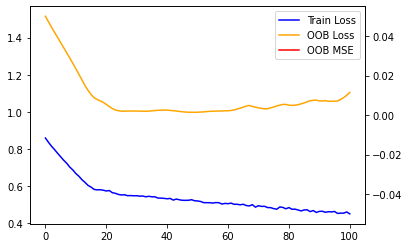

Bootstrap iteration 5 at time 2022-07-05 19:45:24.472840
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.8486434817314148, OOB Loss: 0.9287946224212646
Epoch: 40, Loss: 0.6252027153968811, OOB Loss: 0.6548759937286377
Epoch: 80, Loss: 0.5225225687026978, OOB Loss: 0.6873501539230347
Early stopped, best epoch: 55, train loss: 0.577703595161438, best OOB loss: 0.6365265250205994, LR: 0.000382517026148903


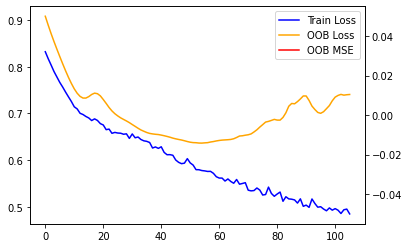

Bootstrap iteration 6 at time 2022-07-05 19:45:46.012367
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.9949326515197754, OOB Loss: 0.7745847702026367
Epoch: 40, Loss: 0.6558093428611755, OOB Loss: 0.603547215461731
Epoch: 80, Loss: 0.5816823840141296, OOB Loss: 0.5931898355484009
Epoch: 120, Loss: 0.48514029383659363, OOB Loss: 0.5944544076919556
Epoch: 160, Loss: 0.42188891768455505, OOB Loss: 0.595137894153595
Early stopped, best epoch: 114, train loss: 0.4929068982601166, best OOB loss: 0.5842975378036499, LR: 0.00032999862316169143


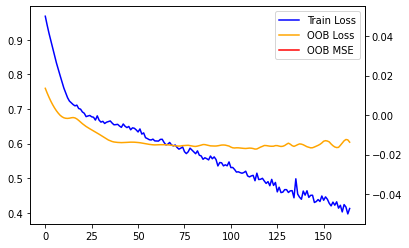

Bootstrap iteration 7 at time 2022-07-05 19:46:20.381325
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.7279011607170105, OOB Loss: 1.4474685192108154
Epoch: 40, Loss: 0.49771785736083984, OOB Loss: 1.1570115089416504
Epoch: 80, Loss: 0.4036000669002533, OOB Loss: 1.2830150127410889
Early stopped, best epoch: 31, train loss: 0.5140759944915771, best OOB loss: 1.1428894996643066, LR: 0.0004062010728455131


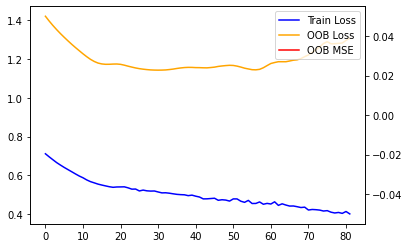

Bootstrap iteration 8 at time 2022-07-05 19:46:36.784632
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.7982262969017029, OOB Loss: 1.3577611446380615
Epoch: 40, Loss: 0.5546537637710571, OOB Loss: 0.9970952868461609
Epoch: 80, Loss: 0.48974713683128357, OOB Loss: 0.9950391054153442
Epoch: 120, Loss: 0.4267430901527405, OOB Loss: 0.9706218242645264
Epoch: 160, Loss: 0.38047799468040466, OOB Loss: 1.0010130405426025
Early stopped, best epoch: 133, train loss: 0.410148561000824, best OOB loss: 0.8990363478660583, LR: 0.00031467142779591256


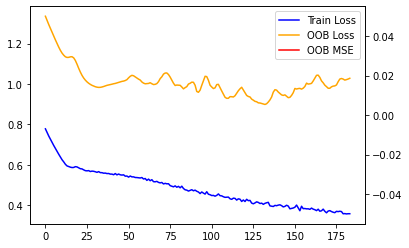

Bootstrap iteration 9 at time 2022-07-05 19:47:11.989395
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.7973710894584656, OOB Loss: 1.097079873085022
Epoch: 40, Loss: 0.5583771467208862, OOB Loss: 0.8881311416625977
Early stopped, best epoch: 24, train loss: 0.5944288372993469, best OOB loss: 0.8798826932907104, LR: 0.0004133812132975024


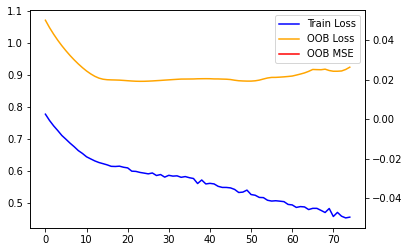

Bootstrap iteration 10 at time 2022-07-05 19:47:26.900263
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.0505908727645874, OOB Loss: 0.826183021068573
Epoch: 40, Loss: 0.6757512092590332, OOB Loss: 0.5299139618873596
Epoch: 80, Loss: 0.5649117827415466, OOB Loss: 0.6296408176422119
Early stopped, best epoch: 35, train loss: 0.6831099390983582, best OOB loss: 0.5262913107872009, LR: 0.00040215426928559


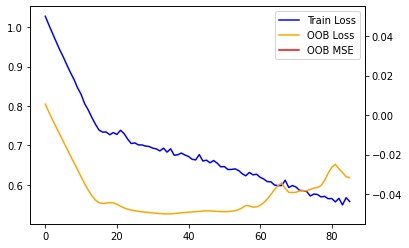

Bootstrap iteration 11 at time 2022-07-05 19:47:44.084674
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.06146240234375, OOB Loss: 0.4284360408782959
Epoch: 40, Loss: 0.7092279195785522, OOB Loss: 0.4162674844264984
Epoch: 80, Loss: 0.6107046604156494, OOB Loss: 0.39542216062545776
Epoch: 120, Loss: 0.49001020193099976, OOB Loss: 0.39465126395225525
Early stopped, best epoch: 98, train loss: 0.5311959981918335, best OOB loss: 0.388477087020874, LR: 0.0003434833248681906


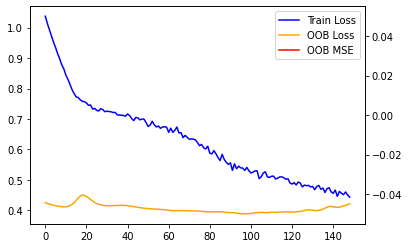

Bootstrap iteration 12 at time 2022-07-05 19:48:13.301297
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.075912356376648, OOB Loss: 0.8149559497833252
Epoch: 40, Loss: 0.6435714960098267, OOB Loss: 0.5893210172653198
Epoch: 80, Loss: 0.5752167701721191, OOB Loss: 0.6187081336975098
Early stopped, best epoch: 43, train loss: 0.6442438364028931, best OOB loss: 0.587519109249115, LR: 0.00039418121010946174


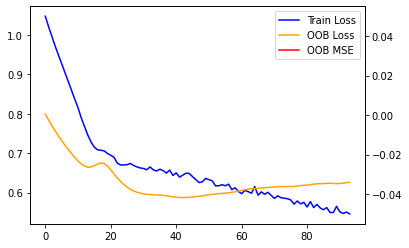

Bootstrap iteration 13 at time 2022-07-05 19:48:31.948647
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.9934737086296082, OOB Loss: 0.9905073046684265
Epoch: 40, Loss: 0.6499714255332947, OOB Loss: 0.6855210661888123
Early stopped, best epoch: 24, train loss: 0.666406512260437, best OOB loss: 0.6574348211288452, LR: 0.00041441725643859886


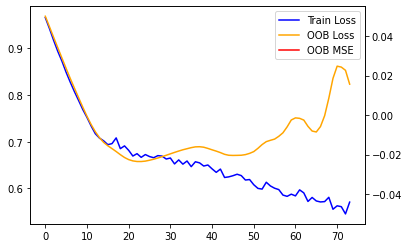

Bootstrap iteration 14 at time 2022-07-05 19:48:46.755383
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.9285463094711304, OOB Loss: 0.8516041040420532
Epoch: 40, Loss: 0.6277868151664734, OOB Loss: 0.6400567293167114
Early stopped, best epoch: 15, train loss: 0.6887804865837097, best OOB loss: 0.6153659820556641, LR: 0.0004227996278567497


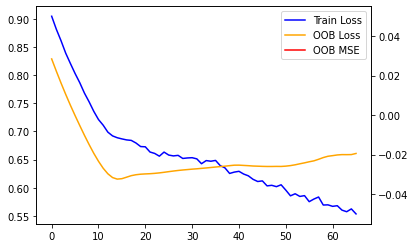

Bootstrap iteration 15 at time 2022-07-05 19:49:00.011282
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.0367262363433838, OOB Loss: 0.6465684175491333
Epoch: 40, Loss: 0.6558989882469177, OOB Loss: 0.5656650066375732
Epoch: 80, Loss: 0.5733959674835205, OOB Loss: 0.5296518802642822
Epoch: 120, Loss: 0.48613566160202026, OOB Loss: 0.5553102493286133
Early stopped, best epoch: 80, train loss: 0.5733959674835205, best OOB loss: 0.5296518802642822, LR: 0.00035931337178194805


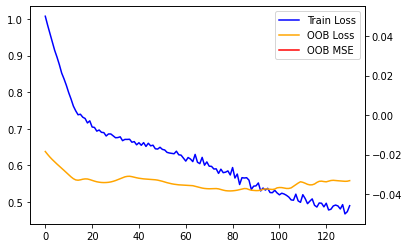

Bootstrap iteration 16 at time 2022-07-05 19:49:25.931916
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.7621957659721375, OOB Loss: 0.8525751829147339
Epoch: 40, Loss: 0.6198968291282654, OOB Loss: 0.7114263772964478
Epoch: 80, Loss: 0.5068820118904114, OOB Loss: 0.8043717741966248
Early stopped, best epoch: 47, train loss: 0.5925440788269043, best OOB loss: 0.6823381185531616, LR: 0.00039025415518281834


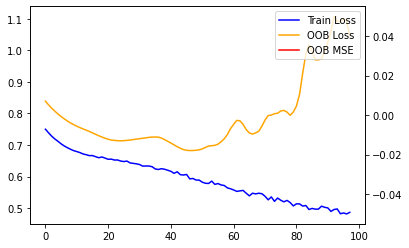

Bootstrap iteration 17 at time 2022-07-05 19:49:45.338754
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.8022576570510864, OOB Loss: 1.313430666923523
Epoch: 40, Loss: 0.5783356428146362, OOB Loss: 0.8549304008483887
Epoch: 80, Loss: 0.5018879175186157, OOB Loss: 0.8936497569084167
Early stopped, best epoch: 39, train loss: 0.588184118270874, best OOB loss: 0.8549036979675293, LR: 0.00039814778225889965


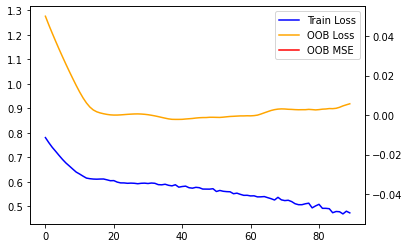

Bootstrap iteration 18 at time 2022-07-05 19:50:03.318413
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.0536165237426758, OOB Loss: 1.0490281581878662
Epoch: 40, Loss: 0.6412696838378906, OOB Loss: 0.5969616174697876
Epoch: 80, Loss: 0.5542442798614502, OOB Loss: 0.6116409301757812
Early stopped, best epoch: 42, train loss: 0.6425480842590332, best OOB loss: 0.5962660312652588, LR: 0.00039516913294181626


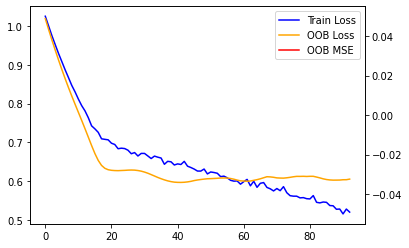

Bootstrap iteration 19 at time 2022-07-05 19:50:21.946037
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.015724539756775, OOB Loss: 0.9549158811569214
Epoch: 40, Loss: 0.6397823691368103, OOB Loss: 0.6128031611442566
Epoch: 80, Loss: 0.5525830984115601, OOB Loss: 0.5814878940582275
Epoch: 120, Loss: 0.4600865840911865, OOB Loss: 0.6080291271209717
Early stopped, best epoch: 85, train loss: 0.5377392172813416, best OOB loss: 0.5722723007202148, LR: 0.0003548443556478391


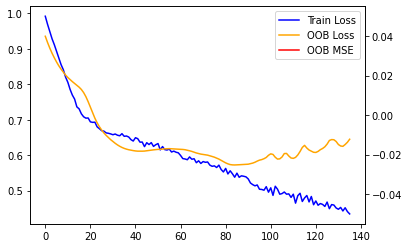

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1120: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


Time 0, 2022-07-05 19:50:50.455626
Time 5, 2022-07-05 19:55:48.312795
Time 10, 2022-07-05 20:00:49.904662
Time 15, 2022-07-05 20:05:48.439299
Time 20, 2022-07-05 20:10:50.505938
Time 25, 2022-07-05 20:15:51.133603
Size of x_mat before appending MARX (731, 6)
Size of x_mat_marx (731, 24)
x_mat_all size (731, 30)
Size of X_train afer appending time (731, 153) Time dummy setting: 2
x_pos {'inf': [0, 3], 'unrate': [1, 4], 'DGS3': [2, 5]}
Size of X_train (701, 153)
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 1

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


OOB Mean Log Det Precision: 2.9865643978118896, MSE: 2.2827091217041016
Epoch: 40, Loss: 0.9238171577453613, OOB Loss: 3.357621908187866, LR: 0.00045123116063007594


KeyboardInterrupt: ignored

In [ ]:
### Forecasting with VARNN

experiment_name = '5jul_multi_forecasting'
test_size = T
# Specify which forecasting method to use: New - joint estimation (using TV cov mat), Old: (drawing from OOB residuals)
forecast_method = 'Old'

folder_path = f'drive/MyDrive/EconML DL/2022 Experiments/{experiment_name}'
if os.path.isdir(folder_path) == False:
  os.mkdir(folder_path)
else:
  print('Folder already exists')

if forecast_method == 'New':
  predict_fn = predict_one_bootstrap_new
else:
  predict_fn = predict_one_bootstrap_old

for variable_list in variable_lists:
  # Select variables for experiment
  print('Variables', variable_list)
  x_d = x_d_all.copy()
  x_d = x_d[variable_list]
  x_d_colnames = x_d.columns
  var_names = x_d.columns
  n_var = len(var_names)
  nn_hyps['variable_list'] = variable_list

  train_size = x_d.shape[0] - test_size - nn_hyps['n_lag_d']
  if nn_hyps['fix_bootstrap'] == True:
    bootstrap_indices = get_bootstrap_indices(num_bootstrap = num_inner_bootstraps, n_obs = train_size, block_size = nn_hyps['block_size'], sampling_rate = nn_hyps['sampling_rate'], opt_bootstrap = nn_hyps['opt_bootstrap'])
    nn_hyps['bootstrap_indices'] = bootstrap_indices
  else:
    nn_hyps['bootstrap_indices'] = None

  # Save experiment param list
  with open(f'{folder_path}/params.npz', 'wb') as f:
      np.savez(f, params = experiment_params, date = datetime.now())

  for repeat in range(num_repeats):
    for i in range(len(experiment_params)):

      nn_hyps.update(experiment_params[i])

      n_betas = n_var * nn_hyps['n_lag_linear'] + 1
      n_inputs_wo_time = n_var * (nn_hyps['n_lag_linear'] + nn_hyps['n_lag_d'])

      X_train, X_test, Y_train, Y_test, x_mat_all, y_mat, nn_hyps = process_varnn_data(x_d, nn_hyps, test_size = test_size, n_time_trends = 100, time_dummy_setting = nn_hyps['time_dummy_setting'], marx = nn_hyps['marx'], dummy_interval = nn_hyps['dummy_interval'])

      n_inputs_total = X_train.shape[1]
      nn_hyps['neurons_weights'] = [nn_hyps['tvpl_archi'] for i in range(n_betas)]

      # If s_pos is already not defined (s_pos can be defined by user)
      if not nn_hyps.get('s_pos'):
        # s_pos_setting
        if nn_hyps['s_pos_setting']['is_hemi'] == False:
          nn_hyps['s_pos'] = [ list(range(n_inputs_total)) ]
        else:
          n_inputs_total_new = n_inputs_wo_time + nn_hyps['s_pos_setting']['n_times']
          nn_hyps['s_pos'] = [ list(range(n_inputs_wo_time)), list(range(n_inputs_wo_time, n_inputs_total_new))]
          # Subset the X_train and X_test to only the required columns
          X_train = X_train[:, :n_inputs_total_new]
          X_test = X_test[:, :n_inputs_total_new]
      print(nn_hyps['s_pos'])

      ### FORECASTING NEW CODE
      # Fix the shock ids across the different models
      error_ids = np.array(random.choices(range(X_train.shape[0]), k = h * B * T))
      error_ids = error_ids.reshape((h, B, T))

      # Test prediction array
      FCAST = np.zeros((h+1, n_var, B, T, R))
      FCAST[:] = np.nan

      for r in range(R):
        print(f'Re-estimation window {r}, {datetime.now()}')

        # Training data is the data available till that moment
        X_train = x_mat_all[:-(test_size - reestimation_window * r), :]
        Y_train = y_mat[:-(test_size - reestimation_window * r), :]

        results = conduct_bootstrap(X_train, X_test, Y_train, Y_test, nn_hyps, device)

        if r == 0:
          BETAS = results['betas_draws']
          BETAS_IN = results['betas_in_draws']
          SIGMAS = results['sigmas_draws']
          SIGMAS_IN = results['sigmas_in_draws']
          PRECISION = results['precision_draws']
          PRECISION_IN = results['precision_in_draws']
          CHOLESKY = results['cholesky_draws']
          CHOLESKY_IN = results['cholesky_in_draws']
          PREDS = results['pred_in_ensemble'] 
          PREDS_TEST = results['pred_ensemble']

          with open(f'{folder_path}/params_{i}_repeat_{repeat}.npz', 'wb') as f:
            np.savez(f, betas = BETAS, betas_in = BETAS_IN, 
                    sigmas = SIGMAS, sigmas_in = SIGMAS_IN,
                    precision = PRECISION, precision_in = PRECISION_IN,
                    cholesky = CHOLESKY, cholesky_in = CHOLESKY_IN,
                    train_preds = PREDS, test_preds = PREDS_TEST, 
                    y = Y_train, y_test = Y_test, 
                    params = nn_hyps)
            
        # For every timestep (in the future), for every bootstrap, get the h-th horizon prediction
        for t in range(r * reestimation_window, T):
          if t % 5 == 0:
            print(f'Time {t}, {datetime.now()}')
          for b in range(B):
            if t == r * reestimation_window: # first sample (X_train is continually changed so can take last value of X_train)
              FCAST[:, :, b, t, r] = predict_fn(X_train[-1, :], results, error_ids[:, b, t], nn_hyps)
            else: # not the first sample (X_test is unchanged so can just index t)
              FCAST[:, :, b, t, r] = predict_fn(X_test[t, :], results, error_ids[:, b, t], nn_hyps)
        
      del nn_hyps['s_pos']

      with open(f'{folder_path}/params_{i}_forecasting_repeat_{repeat}_old.npz', 'wb') as f:
        np.save(f, FCAST)

### Benchmarks to compare VARNN Against

In [ ]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA

n_lag_linear = 2

In [ ]:
experiment_name = '15jun_multi_forecasting'
test_size = T

folder_path = f'drive/MyDrive/EconML DL/2022 Experiments/{experiment_name}'
if os.path.isdir(folder_path) == False:
  os.mkdir(folder_path)
else:
  print('Folder already exists')

Folder already exists


In [ ]:
variable_list = variable_lists[0]
x_d = x_d_all.copy()
x_d = x_d[variable_list]
x_d_colnames = x_d.columns
var_names = x_d.columns
n_var = len(var_names)

In [ ]:
### Expanding Window VAR

# Test prediction array
FCAST = np.zeros((h+1, n_var, T, R))
FCAST[:] = np.nan

data = np.array(data)
Y_test = data[-T:, :]

# For every time through the re-estimation window
for r in range(R):
  print(f'Re-estimation window {r}, {datetime.now()}')
  data = np.array(x_d)
  # Training data is the data available till that moment
  Y_train = data[:-(T - reestimation_window * r), :]
  
  # Estimate the VAR model with available data
  var_model = VAR(Y_train)
  results = var_model.fit(n_lag_linear)
  for t in range(reestimation_window * r, T):
    if t == reestimation_window * r:
      FCAST[1:, :, t, r] = results.forecast(Y_train[-n_lag_linear:, :], steps = h)
    # In between case when you need to combine Y_train and some bit of Y_test
    elif t < reestimation_window * r + n_lag_linear:
      train_obs_needed = n_lag_linear - (t - reestimation_window * r)
      test_obs_needed = t - reestimation_window * r
      Y_in = np.concatenate([Y_train[-train_obs_needed:, :], Y_test[:test_obs_needed, :]], axis = 0)
      FCAST[1:, :, t, r] = results.forecast(Y_in, steps = h)
    else:
      FCAST[1:, :, t, r] = results.forecast(Y_test[(t-n_lag_linear):t, :], steps = h)

with open(f'{folder_path}/expanding_var_forecasting.npz', 'wb') as f:
    np.save(f, FCAST)

Re-estimation window 0, 2022-06-17 21:40:33.311614
(2, 3)


In [ ]:
### Rolling Window VAR

# Test prediction array
FCAST = np.zeros((h+1, n_var, T, R))
FCAST[:] = np.nan

window_length = 40
Y_test = data[-T:, :]

# For every time through the re-estimation window
for r in range(R):
  print(f'Re-estimation window {r}, {datetime.now()}')
  data = np.array(x_d)
  # Training data is the data available till that moment - *restricted to the length of window
  Y_train = data[-(T - reestimation_window * r + window_length):-(T - reestimation_window * r), :]
  # Estimate the VAR model with available data
  var_model = VAR(Y_train)
  results = var_model.fit(n_lag_linear)
  for t in range(reestimation_window * r, T):
    if t == reestimation_window * r:
      FCAST[1:, :, t, r] = results.forecast(Y_train[-n_lag_linear:, :], steps = h)
    # In between case when you need to combine Y_train and some bit of Y_test
    elif t < reestimation_window * r + n_lag_linear:
      train_obs_needed = n_lag_linear - (t - reestimation_window * r)
      test_obs_needed = t - reestimation_window * r
      Y_in = np.concatenate([Y_train[-train_obs_needed:, :], Y_test[:test_obs_needed, :]], axis = 0)
      FCAST[1:, :, t, r] = results.forecast(Y_in, steps = h)
    else:
      FCAST[1:, :, t, r] = results.forecast(Y_test[(t-n_lag_linear):t, :], steps = h)

with open(f'{folder_path}/rolling_var_forecasting.npz', 'wb') as f:
    np.save(f, FCAST)

Re-estimation window 0, 2022-06-17 21:41:09.851281


In [ ]:
def get_ar_forecasts(y_in, results_coefs, h):
  # y_in should be of length 'ar_lags' - all you need to start iterating forward
  
  # Store both train and test 
  y_all = np.zeros((y_in.shape[0] + h))
  y_all[:] = np.nan
  y_all[:y_in.shape[0]] = y_in

  for horizon in range(1, h+1):
    # Get the input lags for 
    y_in_this = y_all[(y_in.shape[0] -1 -4 + horizon):(y_in.shape[0] -1 + horizon)]
    # Evaluate the AR equation to get the prediction
    y_all[y_in.shape[0] - 1 + horizon] = results_coefs[0] + np.dot(results_coefs[1:], y_in)

  # Return h predictions
  return y_all[y_in.shape[0]:]

In [ ]:
### Expanding Window AR(4)

reestimation_window = 1
R = int(T / reestimation_window)

ar_lags = 4

FCAST = np.zeros((h+1, n_var, T, R))
FCAST[:] = np.nan

Y_test = data[-T:, :]

# For every time through the re-estimation window
for r in range(R):
  print(f'Re-estimation window {r}, {datetime.now()}')
  data = np.array(x_d)
  # Training data is the data available till that moment
  Y_train = data[:-(T - reestimation_window * r), :]

  if Y_train.shape[0] != 0:

    for var in range(n_var):
      y_train = Y_train[:, var]
      y_test = Y_test[:, var]
      arima_model = ARIMA(y_train, order = (ar_lags,0,0))
      results = arima_model.fit()
      results_coefs = results.params[0:(ar_lags + 1)]
    
      for t in range(reestimation_window * r, T):
        # Different cases of getting the input y_in
        if t == reestimation_window * r:
          y_in = y_train[-ar_lags:]
        # In between case when you need to combine Y_train and some bit of Y_test
        elif t < reestimation_window * r + ar_lags:
          train_obs_needed = ar_lags - (t - reestimation_window * r)
          test_obs_needed = t - reestimation_window * r
          y_in = np.concatenate([y_train[-train_obs_needed:], y_test[:test_obs_needed]], axis = 0)
        else:
          y_in = y_test[(t-ar_lags):t]

        FCAST[1:, var, t, r] = get_ar_forecasts(y_in, results_coefs, h)

with open(f'{folder_path}/expanding_ar_forecasting.npz', 'wb') as f:
    np.save(f, FCAST)

Re-estimation window 0, 2022-06-17 23:24:52.252451
Re-estimation window 1, 2022-06-17 23:24:54.397479


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 2, 2022-06-17 23:24:57.622641
Re-estimation window 3, 2022-06-17 23:24:59.114346
Re-estimation window 4, 2022-06-17 23:25:00.689837
Re-estimation window 5, 2022-06-17 23:25:02.065021
Re-estimation window 6, 2022-06-17 23:25:03.579679
Re-estimation window 7, 2022-06-17 23:25:04.899740
Re-estimation window 8, 2022-06-17 23:25:06.142552
Re-estimation window 9, 2022-06-17 23:25:07.304450
Re-estimation window 10, 2022-06-17 23:25:09.435681
Re-estimation window 11, 2022-06-17 23:25:11.055106
Re-estimation window 12, 2022-06-17 23:25:12.773911
Re-estimation window 13, 2022-06-17 23:25:14.351466
Re-estimation window 14, 2022-06-17 23:25:15.578412
Re-estimation window 15, 2022-06-17 23:25:16.812903
Re-estimation window 16, 2022-06-17 23:25:18.376501


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 17, 2022-06-17 23:25:20.458416
Re-estimation window 18, 2022-06-17 23:25:21.941324


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 19, 2022-06-17 23:25:23.980050
Re-estimation window 20, 2022-06-17 23:25:25.614310
Re-estimation window 21, 2022-06-17 23:25:26.862580
Re-estimation window 22, 2022-06-17 23:25:28.382334
Re-estimation window 23, 2022-06-17 23:25:29.771904
Re-estimation window 24, 2022-06-17 23:25:31.051674
Re-estimation window 25, 2022-06-17 23:25:32.773161
Re-estimation window 26, 2022-06-17 23:25:34.609915
Re-estimation window 27, 2022-06-17 23:25:36.125466
Re-estimation window 28, 2022-06-17 23:25:37.683670


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 29, 2022-06-17 23:25:39.779743
Re-estimation window 30, 2022-06-17 23:25:41.256862
Re-estimation window 31, 2022-06-17 23:25:42.804874
Re-estimation window 32, 2022-06-17 23:25:44.347131
Re-estimation window 33, 2022-06-17 23:25:45.975145
Re-estimation window 34, 2022-06-17 23:25:47.543781
Re-estimation window 35, 2022-06-17 23:25:49.141360


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 36, 2022-06-17 23:25:51.244459


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 37, 2022-06-17 23:25:53.785401
Re-estimation window 38, 2022-06-17 23:25:56.434199
Re-estimation window 39, 2022-06-17 23:25:58.008241
Re-estimation window 40, 2022-06-17 23:25:59.268038
Re-estimation window 41, 2022-06-17 23:26:00.605628
Re-estimation window 42, 2022-06-17 23:26:02.004803
Re-estimation window 43, 2022-06-17 23:26:03.696986
Re-estimation window 44, 2022-06-17 23:26:05.344045
Re-estimation window 45, 2022-06-17 23:26:06.888347
Re-estimation window 46, 2022-06-17 23:26:08.850990
Re-estimation window 47, 2022-06-17 23:26:10.490944
Re-estimation window 48, 2022-06-17 23:26:12.048801
Re-estimation window 49, 2022-06-17 23:26:13.603358
Re-estimation window 50, 2022-06-17 23:26:15.217145
Re-estimation window 51, 2022-06-17 23:26:16.784168


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 52, 2022-06-17 23:26:18.940851


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 53, 2022-06-17 23:26:21.066308


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 54, 2022-06-17 23:26:23.218578
Re-estimation window 55, 2022-06-17 23:26:24.845132
Re-estimation window 56, 2022-06-17 23:26:26.389276
Re-estimation window 57, 2022-06-17 23:26:28.012853
Re-estimation window 58, 2022-06-17 23:26:29.676621
Re-estimation window 59, 2022-06-17 23:26:31.093597
Re-estimation window 60, 2022-06-17 23:26:32.448542
Re-estimation window 61, 2022-06-17 23:26:34.003367


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 62, 2022-06-17 23:26:36.199417
Re-estimation window 63, 2022-06-17 23:26:37.776925
Re-estimation window 64, 2022-06-17 23:26:39.457674
Re-estimation window 65, 2022-06-17 23:26:41.090028


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 66, 2022-06-17 23:26:43.367393
Re-estimation window 67, 2022-06-17 23:26:44.987638
Re-estimation window 68, 2022-06-17 23:26:46.676053


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 69, 2022-06-17 23:26:48.905837


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 70, 2022-06-17 23:26:51.163711
Re-estimation window 71, 2022-06-17 23:26:52.874610
Re-estimation window 72, 2022-06-17 23:26:54.485997
Re-estimation window 73, 2022-06-17 23:26:56.119959
Re-estimation window 74, 2022-06-17 23:26:57.674946
Re-estimation window 75, 2022-06-17 23:26:59.133415
Re-estimation window 76, 2022-06-17 23:27:00.620656


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 77, 2022-06-17 23:27:02.644137


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 78, 2022-06-17 23:27:04.679967
Re-estimation window 79, 2022-06-17 23:27:05.568896
Re-estimation window 80, 2022-06-17 23:27:06.404287


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 81, 2022-06-17 23:27:08.324612
Re-estimation window 82, 2022-06-17 23:27:09.596942
Re-estimation window 83, 2022-06-17 23:27:10.389944
Re-estimation window 84, 2022-06-17 23:27:11.200983
Re-estimation window 85, 2022-06-17 23:27:12.572045
Re-estimation window 86, 2022-06-17 23:27:13.874660


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 87, 2022-06-17 23:27:15.716057


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 88, 2022-06-17 23:27:17.604162
Re-estimation window 89, 2022-06-17 23:27:18.386204


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [ ]:
### Rolling Window AR(4)

reestimation_window = 1
R = int(T / reestimation_window)

ar_lags = 4

FCAST = np.zeros((h+1, n_var, T, R))
FCAST[:] = np.nan

window_length = 40

Y_test = data[-T:, :]

# For every time through the re-estimation window
for r in range(R):
  print(f'Re-estimation window {r}, {datetime.now()}')
  data = np.array(x_d)
  # Training data is the data available till that moment
  Y_train = data[-(T - reestimation_window * r + window_length):-(T - reestimation_window * r), :]

  if Y_train.shape[0] != 0:

    for var in range(n_var):
      y_train = Y_train[:, var]
      y_test = Y_test[:, var]
      arima_model = ARIMA(y_train, order = (ar_lags,0,0))
      results = arima_model.fit()
      results_coefs = results.params[0:(ar_lags + 1)]
    
      for t in range(reestimation_window * r, T):
        # Different cases of getting the input y_in
        if t == reestimation_window * r:
          y_in = y_train[-ar_lags:]
        # In between case when you need to combine Y_train and some bit of Y_test
        elif t < reestimation_window * r + ar_lags:
          train_obs_needed = ar_lags - (t - reestimation_window * r)
          test_obs_needed = t - reestimation_window * r
          y_in = np.concatenate([y_train[-train_obs_needed:], y_test[:test_obs_needed]], axis = 0)
        else:
          y_in = y_test[(t-ar_lags):t]

        FCAST[1:, var, t, r] = get_ar_forecasts(y_in, results_coefs, h)

with open(f'{folder_path}/rolling_ar_forecasting.npz', 'wb') as f:
    np.save(f, FCAST)

Re-estimation window 0, 2022-06-17 23:27:20.311823
Re-estimation window 1, 2022-06-17 23:27:20.861230
Re-estimation window 2, 2022-06-17 23:27:21.458066
Re-estimation window 3, 2022-06-17 23:27:21.978616
Re-estimation window 4, 2022-06-17 23:27:22.395175


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 5, 2022-06-17 23:27:23.072218
Re-estimation window 6, 2022-06-17 23:27:23.595624
Re-estimation window 7, 2022-06-17 23:27:24.169657
Re-estimation window 8, 2022-06-17 23:27:24.681305


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 9, 2022-06-17 23:27:25.188307
Re-estimation window 10, 2022-06-17 23:27:25.678996
Re-estimation window 11, 2022-06-17 23:27:26.318459
Re-estimation window 12, 2022-06-17 23:27:26.769336
Re-estimation window 13, 2022-06-17 23:27:27.252183
Re-estimation window 14, 2022-06-17 23:27:27.839497
Re-estimation window 15, 2022-06-17 23:27:28.468849
Re-estimation window 16, 2022-06-17 23:27:28.978554


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 17, 2022-06-17 23:27:29.714852
Re-estimation window 18, 2022-06-17 23:27:30.221754
Re-estimation window 19, 2022-06-17 23:27:30.734674
Re-estimation window 20, 2022-06-17 23:27:31.207311


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 21, 2022-06-17 23:27:31.935252
Re-estimation window 22, 2022-06-17 23:27:32.452791


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 23, 2022-06-17 23:27:33.021121


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 24, 2022-06-17 23:27:33.798915


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 25, 2022-06-17 23:27:34.506926
Re-estimation window 26, 2022-06-17 23:27:34.967206
Re-estimation window 27, 2022-06-17 23:27:35.484977
Re-estimation window 28, 2022-06-17 23:27:36.130552
Re-estimation window 29, 2022-06-17 23:27:36.629028
Re-estimation window 30, 2022-06-17 23:27:37.083155
Re-estimation window 31, 2022-06-17 23:27:37.583866
Re-estimation window 32, 2022-06-17 23:27:38.104987
Re-estimation window 33, 2022-06-17 23:27:38.550956
Re-estimation window 34, 2022-06-17 23:27:38.912299


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 35, 2022-06-17 23:27:39.526692
Re-estimation window 36, 2022-06-17 23:27:39.968459
Re-estimation window 37, 2022-06-17 23:27:40.408157


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 38, 2022-06-17 23:27:41.149059
Re-estimation window 39, 2022-06-17 23:27:41.713192
Re-estimation window 40, 2022-06-17 23:27:42.211568
Re-estimation window 41, 2022-06-17 23:27:42.820441
Re-estimation window 42, 2022-06-17 23:27:43.318791
Re-estimation window 43, 2022-06-17 23:27:43.684195


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 44, 2022-06-17 23:27:44.320323


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 45, 2022-06-17 23:27:45.009821
Re-estimation window 46, 2022-06-17 23:27:45.503288


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 47, 2022-06-17 23:27:46.176892
Re-estimation window 48, 2022-06-17 23:27:46.759602
Re-estimation window 49, 2022-06-17 23:27:47.317481
Re-estimation window 50, 2022-06-17 23:27:47.751399
Re-estimation window 51, 2022-06-17 23:27:48.172699
Re-estimation window 52, 2022-06-17 23:27:48.638321
Re-estimation window 53, 2022-06-17 23:27:49.117807
Re-estimation window 54, 2022-06-17 23:27:49.653963
Re-estimation window 55, 2022-06-17 23:27:50.155964


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 56, 2022-06-17 23:27:50.779165
Re-estimation window 57, 2022-06-17 23:27:51.234150
Re-estimation window 58, 2022-06-17 23:27:51.781141


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 59, 2022-06-17 23:27:52.377245
Re-estimation window 60, 2022-06-17 23:27:52.810226
Re-estimation window 61, 2022-06-17 23:27:53.181989
Re-estimation window 62, 2022-06-17 23:27:53.657103
Re-estimation window 63, 2022-06-17 23:27:54.142951
Re-estimation window 64, 2022-06-17 23:27:54.573528
Re-estimation window 65, 2022-06-17 23:27:55.161607
Re-estimation window 66, 2022-06-17 23:27:55.655850
Re-estimation window 67, 2022-06-17 23:27:56.173597


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 68, 2022-06-17 23:27:56.931513
Re-estimation window 69, 2022-06-17 23:27:57.414559
Re-estimation window 70, 2022-06-17 23:27:57.994520
Re-estimation window 71, 2022-06-17 23:27:58.573584
Re-estimation window 72, 2022-06-17 23:27:59.134235


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 73, 2022-06-17 23:27:59.732783
Re-estimation window 74, 2022-06-17 23:28:00.253203
Re-estimation window 75, 2022-06-17 23:28:00.685940
Re-estimation window 76, 2022-06-17 23:28:01.081956
Re-estimation window 77, 2022-06-17 23:28:01.440098
Re-estimation window 78, 2022-06-17 23:28:01.735054
Re-estimation window 79, 2022-06-17 23:28:02.207312
Re-estimation window 80, 2022-06-17 23:28:02.484433


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 81, 2022-06-17 23:28:03.033137
Re-estimation window 82, 2022-06-17 23:28:03.448717
Re-estimation window 83, 2022-06-17 23:28:03.730336
Re-estimation window 84, 2022-06-17 23:28:04.101932
Re-estimation window 85, 2022-06-17 23:28:04.386564
Re-estimation window 86, 2022-06-17 23:28:04.760113


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 87, 2022-06-17 23:28:05.175030
Re-estimation window 88, 2022-06-17 23:28:05.422355
Re-estimation window 89, 2022-06-17 23:28:05.686064
